# Energy Analysis
We will be using the new energy layer to analyze a variety of PV module futures.

We will use a literture-sourced global scale deployment schedule through 2050, then assume that capacity increases at a lower constant rate through 2100.

Module specific module and material input files are stored in the baselines\Energy_CellModuleTechCompare folder.

In [3]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'EnergyAnalysis')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')
altBaselinesfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'Energy_CellModuleTechCompare')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [4]:
from platform import python_version 
print(python_version())

3.8.8


Graphing settings

In [5]:
#https://www.learnui.design/tools/data-color-picker.html#palette
#color pallette - modify here for all graphs below
colorpalette=['#000000', #PV ICE baseline
              '#595959', '#7F7F7F', '#A6A6A6', '#D9D9D9', #BAU, 4 grays, perc, shj, topcon, irena
              #'#067872','#0aa39e','#09d0cd','#00ffff', #realistic cases (4) teals, perc, shj, topcon, irena
              '#0579C1','#C00000','#FFC000', #extreme cases (3) long life, high eff, circular
                '#6E30A0','#00B3B5','#10C483', #ambitious modules (5) high eff+ long life, 50 yr perc, recycleSi, 
               '#97CB3F','#FF7E00' #circular perovskite+life, circular perovkiste+ high eff
                ] 

colormats = ['#00bfbf','#ff7f0e','#1f77be','#2ca02c','#d62728','#9467BD','#8C564B'] #colors for material plots       

import matplotlib as mpl #import matplotlib
from cycler import cycler #import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorpalette) #reset the default color palette of mpl

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8, 6)

scennames_labels = ['PV_ICE','PERC','SHJ','TOPCon','IRENA\nreg. loss',
                         'Long-Lived','High Eff','Circular',
                        'High Eff\n+ Long-life','Long-Life\n+ Recycling',
                         'Recycled-Si\n+ Long-life','Circular\n+ Long-life',
                        'Circular\n+ High Eff'
                    ]  

scennames_labels_flat = ['PV_ICE','PERC','SHJ','TOPCon','IRENA reg. loss',
                         'Long-Lived','High Eff','Circular',
                        'High Eff + Long-life','Long-Life + Recycling',
                         'Recycled-Si + Long-life','Circular + Long-life',
                        'Circular + High Eff'
                    ] 
#,'Lightweight'


scennames_labels = ['PV_ICE','PERC','SHJ','TOPCon','IRENA reg. loss',
                         'Extreme\nLong-Lived','Extreme\nHigh Eff','Extreme\nCircular',
                        'Ambitious\nHigh Eff\n+ Long-life','Ambitious\n50-year PERC',
                         'Ambitious Circular\n+ Long-life','Ambitious Recycled-Si\n+ Long-life',
                        'Ambitious Circular\n+ High Eff'
                    ]  

scennames_labels_flat = ['PV_ICE','PERC','SHJ','TOPCon','IRENA reg. loss',
                         'Extreme Long-Lived','Extreme High Eff','Extreme Circular',
                        'Ambitious High Eff + Long-life','Ambitious 50-year PERC',
                         'Ambitious Circular + Long-life','Ambitious Recycled-Si + Long-life',
                        'Ambitious Circular + High Eff'
                    ]

Scenarios and materials

In [6]:
MATERIALS = ['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet']
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

We will be deploying based on power (not area) because each of these have different efficiencies, and those differences should be accounted for in the simulation. Additionally, we will run the installation compensation to simulate the required replacements for each module type.

In [7]:
import PV_ICE
PV_ICE.__version__


'v0.2.0+465.g0bca32c.dirty'

In [8]:
#load in a baseline and materials for modification
sim1 = PV_ICE.Simulation(name='sim1', path=testfolder)

sim1.createScenario(name='PV_ICE', massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
for mat in range (0, len(MATERIALS)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
    sim1.scenario['PV_ICE'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)


path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\EnergyAnalysis
Baseline folder directed to default:  C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\baselines


# 1. Module & Scenario Creation
Starting modifications in 2022, using PV ICE baseline as historical for all modules

**NOTE: Currently have to modify all scenarios before extending the years to avoid errors.**

**NOTE: all dynamic values changed with PV ICE modify functions must feed in a Pandas Series**

In [9]:
celltech_modeff = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-modeffimprovements.csv'),index_col=0) #pull in module eff
celltech_aguse = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-Agusageimprovements.csv'),index_col=0) #pull in Ag use

In [10]:
celltech_modeff.loc[2020]

PERC      22.8
SHJ       23.5
TOPCon    23.2
Name: 2020, dtype: float64

In [11]:
#glass-glass package mass per area calculation
#ITRPV 2022 Figs 36 and 38, we are assuming that the front and back glass heave equal thickness of 2.5mm
density_glass = 2500*1000 # g/m^3 
glassperm2 = (2.5/1000)* 2 * density_glass
print('The mass per module area of glass is '+str(glassperm2)+' g/m^2 for all modules with a glass-glass package')

The mass per module area of glass is 12500.0 g/m^2 for all modules with a glass-glass package


In [12]:
timeshift = 2022-1995

In [13]:
idx_temp = pd.RangeIndex(start=2000,stop=2051,step=1)

## 1.1 Business as Usual
Commercialized Modules with Expected Continued Improvement
- PERC
- SHJ
- TOPCon
- IRENA reg. loss/mc-Si/vintage modules

For all these modules, we assume improving recycling slightly behind the EU WEEE Directive:
- 2022: 15% collection, 75% recycled module, 100% downcycled glass, 100% HQ al frames, 20% closed loop
- 2030: 30% collection, 80% recycled module, 30% closed-loop glass, 30% closed-loop silicon, 30% closed-loop silver, 50% closed loop Al frames
- 2050: 75% collection, 95% recycled module, 75% closed loop recycled glass, 75% closed loop recycled silicon, 75% closed-loop silver, 100% closed loop al frames

### 1.1.1 PERC

In [14]:
#modified module
moduleinput_m_r_PERC = os.path.join(altBaselinesfolder, 'mod_r_PERC.csv')
sim1.createScenario(name='r_PERC', massmodulefile=moduleinput_m_r_PERC, energymodulefile=moduleFile_e) 

In [15]:
#module efficiency modify for PERC
sim1.modifyScenario('r_PERC', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [16]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_PERC'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_PERC'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_PERC'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_PERC'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_PERC'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [17]:
#modify silver usage for PERC
sim1.scenario['r_PERC'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'PERC'], start_year=2022)

In [18]:
#modify package to glass glass
sim1.scenario['r_PERC'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['r_PERC'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

### 1.1.2 SHJ
This is a modern SHJ module with expected silver and module efficiency improvements taken from Zhang et al 2021, Gervais et al 2021, and ITPRV 2022. See PERC vs SHJ vs TOPCon for a more detailed evaluation.

In [19]:
#modified module
moduleinput_m_r_SHJ = os.path.join(altBaselinesfolder, 'mod_r_SHJ.csv')
sim1.createScenario(name='r_SHJ', massmodulefile=moduleinput_m_r_SHJ, energymodulefile=moduleFile_e) 

In [20]:
#module efficiency modify for SHJ
sim1.modifyScenario('r_SHJ', 'mod_eff', celltech_modeff.loc[2022:,'SHJ'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [21]:
#load modified materials
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_SHJ'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_SHJ'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_SHJ'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_SHJ'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_SHJ'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [22]:
#modify silver usage for SHJ
sim1.scenario['r_SHJ'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'SHJ'], start_year=2022)

In [23]:
#modify package to glass glass
sim1.scenario['r_SHJ'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['r_SHJ'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

### 1.1.3 TOPCon

In [24]:
#modified module
moduleinput_m_r_TOPCon = os.path.join(altBaselinesfolder, 'mod_r_TOPCon.csv')
sim1.createScenario(name='r_TOPCon', massmodulefile=moduleinput_m_r_TOPCon, energymodulefile=moduleFile_e) 

In [25]:
#module efficiency modify
sim1.modifyScenario('r_TOPCon', 'mod_eff', celltech_modeff.loc[2022:,'TOPCon'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [26]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_TOPCon'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_TOPCon'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_TOPCon'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_TOPCon'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_TOPCon'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [27]:
#modify silver usage for PERC
sim1.scenario['r_TOPCon'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'TOPCon'], start_year=2022)

In [28]:
#modify package to glass glass
sim1.scenario['r_TOPCon'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['r_TOPCon'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

### 1.1.4 IRENA Reg. Loss with improved recycling
This scenario uses the IRENA 2016 regular loss scenario results, or a low quality module, and assumes the same EoL recycling improvement as the previous three scenarios. We're assuming this is a mc-Si, therefore, changing the ingot energy to reflect the lower energy intensity.

In [29]:
#modified module
moduleinput_m_r_IRENA = os.path.join(altBaselinesfolder, 'mod_r_IRENAregloss.csv')
sim1.createScenario(name='r_IRENA', massmodulefile=moduleinput_m_r_IRENA, energymodulefile=moduleFile_e) 

In [30]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_IRENA'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_IRENA'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_IRENA'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_IRENA'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_IRENA'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [31]:
#modify silicon mfging energy to be mc-Si only
altmfgSi_mcSi = pd.read_csv(os.path.join(supportMatfolder, 'output_energy_silicon_MFG_mcSi.csv'), index_col=0)
#modify silicon recycling energy
sim1.scenario['r_IRENA'].modifyMaterialEnergy('silicon', 'e_mat_MFG', 
                                              altmfgSi_mcSi.loc[2022:,'E_MFG_kWhpkg'], start_year=2022)
sim1.scenario['r_IRENA'].modifyMaterialEnergy('silicon', 'e_mat_MFG_fuelfraction', 
                                              altmfgSi_mcSi.loc[2022:,'E_mfgFuelFraction'], start_year=2022)


In [32]:
sim1.scenario['r_IRENA'].material['silicon'].matdataIn_e.iloc[25:30,]

year  e_mat_extraction   e_mat_MFG  e_mat_MFG_fuelfraction  \
25  2020            0.0062  169.060000                0.220000   
26  2021            0.0062  170.730000                0.210000   
27  2022            0.0062  144.532276                0.236169   
28  2023            0.0062  144.418207                0.236356   
29  2024            0.0062  144.304139                0.236542   

    e_mat_MFGScrap_LQ  e_mat_MFGScrap_HQ  e_mat_Landfill  \
25               24.5              600.0            0.09   
26               24.5              600.0            0.09   
27               24.5              600.0            0.09   
28               24.5              600.0            0.09   
29               24.5              600.0            0.09   

    e_mat_Landfill_fuelfraction  e_mat_EoL_ReMFG_clean  e_mat_Recycled_LQ  \
25                          0.0                    0.4                1.6   
26                          0.0                    0.4                1.6   
27                          0.0                    0.4                1.6   
28                          0.0                    0.4                1.6   
29                          0.0                    0.4                1.6   

    e_mat_Recycled_HQ  e_mat_Recycled_HQ_fuelfraction  
25             138.38                            0.20  
26             143.04                            0.19  
27             144.33                            0.19  
28             144.20                            0.19  
29             144.60                            0.19

## 1.2 Extreme modules
What if you could have 1/3 design aspects perfectly optimized right now, but at the expense of the other two?

In [33]:
#names for extreme set of scenarios
scennames_ex = ['ex_Life', 'ex_High_eff', 'ex_Circular'] #extreme boundaries

In [34]:
for scen in scennames_ex:  #creates the PV ICE Baseline and extreme scenarios first
    sim1.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim1.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

### 1.2.1 Extreme Lifetime - 50 year module
This module represents current PERC technology if it were to have it's lifetime extended significantly. Glass-glass technology is assumed, expected decreases in silver usage and increases in module efficiency are derived from Zhang et al 2021, Gervais et al 2021 and ITRPV 2022. Merchant tail is set to 100%, while material circularity is set to 0 after 2022.

In [35]:
#module efficiency modify for PERC
#evolves at the same rate as the baseline comparison
sim1.modifyScenario('ex_Life', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #PERC 2030 module eff

In [36]:
#silver modify for PERC
sim1.scenario['ex_Life'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'PERC'], start_year=2022)
#old way
#sim1.scenario['PERC_50'].material['silver'].matdataIn_m.loc[timeshift:,'mat_massperm2'] = celltech_aguse.loc[2022:,'PERC'].values

In [37]:
#modify package to glass glass
sim1.scenario['ex_Life'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022) #
sim1.scenario['ex_Life'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [38]:
#Lifetime and Degradation
#degradation rate from Theristis et al 2022
#failure is T10 at 50 years
#degradation rate:
sim1.modifyScenario('ex_Life', 'mod_degradation', 0.4, start_year=2022) #annual power degradation to reach 80% at 55 yrs
#T50
sim1.modifyScenario('ex_Life', 'mod_reliability_t50', 56.07, start_year=2022)
#t90
sim1.modifyScenario('ex_Life', 'mod_reliability_t90', 59.15, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('ex_Life', 'mod_lifetime', 50, start_year=2022) #project lifetime of 50 years


In [39]:
#Merchant Tail set high
sim1.modifyScenario('ex_Life', 'mod_MerchantTail', 100, start_year=2022) #all installations stay for merchant tail

#Set to no material circularity after 2022
sim1.modifyScenario('ex_Life', 'mod_EOL_collection_eff', 0.0, start_year=2022)
for mat in sim1.scenario['ex_Life'].material:
        sim1.scenario['ex_Life'].modifyMaterials(mat, 'mat_MFG_scrap_Recycled', 0.0, start_year=2022) #        

### 1.2.2 Extreme High Efficiency
This represents a current 25 year lifetime module warranty where efficiency has been prioritized. This could represent a silicon based tandem, along the lines of a heterojunction, multijunction or tandem structure. This will also be assumed to be bifacial at 0.92, the highest projection from ITRPV 2023.

In [40]:
sim1.modifyScenario('ex_High_eff', 'mod_eff', 30.0, start_year=2022) #changing module eff

In [41]:
#Lifetime and Degradation
#degradation rate:
sim1.modifyScenario('ex_High_eff', 'mod_degradation', 0.75, start_year=2022) #standard current degrdation
#T50
sim1.modifyScenario('ex_High_eff', 'mod_reliability_t50', 30.7, start_year=2022)
#t90
sim1.modifyScenario('ex_High_eff', 'mod_reliability_t90', 35, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('ex_High_eff', 'mod_lifetime', 25, start_year=2022) #project lifetime of 25 years

In [42]:
#modify package to glass glass
sim1.scenario['ex_High_eff'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['ex_High_eff'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [43]:
#Set to no material circularity after 2022
sim1.modifyScenario('ex_High_eff', 'mod_EOL_collection_eff', 0.0, start_year=2022)
for mat in sim1.scenario['ex_High_eff'].material:
        sim1.scenario['ex_High_eff'].modifyMaterials(mat, 'mat_MFG_scrap_Recycled', 0.0, start_year=2022) #    

### 1.2.3 Extreme Circular 
There are currently no circular modules, so this extreme case is based on hypothetical perovskite Si tandems modules. This module uses current best perovskite si tandem module and cell efficiencies, has a prospective life of 15 years and 1.47% degradation rate, and is highly circular. This is the extreme module proposed by perovskite tandems [Jean et al. 2019]. This maximizes material circularity, through remanufacturing glass and silicon wafers, and recycling the al frames closed loop.

In [44]:
#2022 module eff = 17.9% #https://www.nrel.gov/pv/assets/pdfs/champion-module-efficiencies-rev220401b.pdf
#2050 module eff = 19.1-26.1% for cheap on mc-Si, 21-27.3% for high eff on SHJ, Sofia et al 2019
idx_perovskite_eff = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_perovskite_eff = pd.DataFrame(index=idx_perovskite_eff, columns=['mod_eff_p'], dtype=float)
df_perovskite_eff.loc[2022] = 17.9 #current champion mini module
df_perovskite_eff.loc[2030] = 19.1 #using the low efficiency, cheap and circular plan
df_perovskite_eff.loc[2050] = 19.1
df_perovskite_eff.interpolate(inplace=True)

In [45]:
#module efficiency modify for PERC
sim1.modifyScenario('ex_Circular', 'mod_eff', df_perovskite_eff.loc[2022:,'mod_eff_p'], start_year=2022) 

In [46]:
#modify package to glass glass
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['ex_Circular'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [47]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('ex_Circular', 'mod_degradation', 1.47, start_year=2022) #annual power degradation
#Mod Project Lifetime
sim1.modifyScenario('ex_Circular', 'mod_lifetime', 15, start_year=2022) #project lifetime of 15 years
#T50
sim1.modifyScenario('ex_Circular', 'mod_reliability_t50', 20.49, start_year=2022)
#t90
sim1.modifyScenario('ex_Circular', 'mod_reliability_t90', 25, start_year=2022) 

In [48]:
#remfg glass, remfg si, recycle Al, near perfect levels
#100% collection rate
sim1.modifyScenario('ex_Circular', 'mod_EOL_collection_eff', 100.0, start_year=2022) #100% collection
sim1.modifyScenario('ex_Circular', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) #100% collection
sim1.modifyScenario('ex_Circular', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) #100% collection

# remanufacturing
sim1.modifyScenario('ex_Circular', 'mod_EOL_pg3_reMFG', 100.0, start_year=2022) #all modules attempt remfg
sim1.modifyScenario('ex_Circular', 'mod_EOL_sp_reMFG_recycle', 100.0, start_year=2022) # recycle if can't remfg
sim1.modifyScenario('ex_Circular', 'mod_EOL_pb3_reMFG', 100.0, start_year=2022) # remfg bad mods too
sim1.modifyScenario('ex_Circular', 'mod_EOL_reMFG_yield', 98.0, start_year=2022) # REMFG YIELD 98%

#set all other paths to 0
sim1.modifyScenario('ex_Circular', 'mod_EOL_pg0_resell', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Circular', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Circular', 'mod_EOL_pg2_stored', 0.0, start_year=2022) #
sim1.modifyScenario('ex_Circular', 'mod_EOL_pg4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Circular', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Circular', 'mod_EOL_pb2_stored', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Circular', 'mod_EOL_pb4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Circular', 'mod_Repair', 0.0, start_year=2022) #
sim1.modifyScenario('ex_Circular', 'mod_MerchantTail', 0.0, start_year=2022) #


#Material Remanufacture
#Glass
#mfg scrap
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 100.0, start_year=2022) #send all to remfg
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #any breakage gets recycled
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_ReMFG_yield', 98.0, start_year=2022) #98% yeild
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_Recycling_yield', 98.0, start_year=2022) #98% yeild


#silicon ReMFG 
#mfg scrap
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 100.0, start_year=2022) #send to remfg
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_ReMFG_yield', 98.0, start_year=2022) #98% yeild
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #remfg breakage gets recycled
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


#aluminium_frames recycle
#mfg scrap
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_ReMFG_yield', 0.0, start_year=2022) #0% yeild
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop



### Lightweighting
- 10% Si
- 50% encapsulant
- 2mm glass
- frameless
- possibly reduced reliability

Could represent a thin film. This does work, it looks very good on Energy basis, however, we need a more realistic existing module to include this further, with more realistic energy demands (e.g.; CdTe).

In [49]:
#module efficiency modify for PERC
#sim1.modifyScenario('ex_Lightweight', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #changing module eff

In [50]:
#2mm glass calculation
#lightweightglass = (2.0/1000)* 1 * density_glass

#50% encapsulant
#light_encap = pd.Series(sim1.scenario['PV_ICE'].material['encapsulant'].matdataIn_m.loc[timeshift:,'mat_massperm2']*0.5)

#10% silicon
#light_Si = pd.Series(sim1.scenario['PV_ICE'].material['silicon'].matdataIn_m.loc[timeshift:,'mat_massperm2']*0.1)

#modify BOM
#sim1.scenario['ex_Lightweight'].modifyMaterials('glass', 'mat_massperm2', lightweightglass, start_year=2022) #glass
#sim1.scenario['ex_Lightweight'].modifyMaterials('aluminium_frames', 'mat_massperm2', 0.0, start_year=2022) #frameless
#sim1.scenario['ex_Lightweight'].modifyMaterials('encapsulant', 'mat_massperm2', light_encap, start_year=2022) #50% encapsulant
#sim1.scenario['ex_Lightweight'].modifyMaterials('silicon', 'mat_massperm2', light_Si, start_year=2022) #10% silicon


In [51]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
#sim1.modifyScenario('ex_Lightweight', 'mod_degradation', 0.7, start_year=2022) #annual power degradation
#Mod Project Lifetime
#sim1.modifyScenario('ex_Lightweight', 'mod_lifetime', 25, start_year=2022) #project lifetime of 15 years
#T50
#sim1.modifyScenario('ex_Lightweight', 'mod_reliability_t50', 29, start_year=2022) #this will get changed with IRENA alpha/b
#t90
#sim1.modifyScenario('ex_Lightweight', 'mod_reliability_t90', 32, start_year=2022) #this will get changed with IRENA alpha/b

In [52]:
#len(sim1.scenario['ex_Lightweight'].material['silicon'].matdataIn_m)

## 1.3 Ambitious Hypothetical Modules

"What if we could have 2/3 design aspects improved?" These are modules which have a basis in laboratory or field but have not yet been fully/completely demonstrated or commercialized. They are the mix and match of the extreme design aspects. Typically one of the two design aspects is emphasized more heavily.
- High Eff + Long Life; 30% efficient bifacial tandem with 40 year lifetimes
- 50 year PERC module; this is the closest to an existing module, but we don't yet have 50 years worth of data to assert that this exists yet.
- Recycled Silicon PERC; this was a demonstration from Fraunhofer to recycle a silicon cell by skipping the mg-Si step, which has energy and carbon implications
- Circular + Long life Pervoskite tandems; in addition to circularizing the materials, improvements to 25 year lifetimes is made, but little improvements to efficiency.
- Circular + Efficient Perovskite tandems; instead of increasing lifetime and reliability, high efficiency is persued [Sofia] in addition to circularizing the materials

### 1.3.1 High Efficiency + Long Life
What if we made long lived tandem modules?
- Lifetime: 25-40 years
- Eff: current SHJ to 30%, 0.9
- Mod. CE: 0%
- Mat. CE: 0%

In [53]:
#modified module
moduleinput_m_r_EffLife = os.path.join(altBaselinesfolder, 'mod_r_EffLife.csv')
sim1.createScenario(name='h_EffLife', massmodulefile=moduleinput_m_r_EffLife, energymodulefile=moduleFile_e) 

#load standard materials
for mat in range (0, len(MATERIALS)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
    sim1.scenario['h_EffLife'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [54]:
#sim1.modifyScenario('ex_High_eff', 'mod_eff', 30.0, start_year=2022) #changing module eff
#module efficiency in the module file from 23.86 to 30% in 2040
#also lifetime and reliabiltiy in mod file, from 25-40 years in 2050

In [55]:
#modify package to glass glass
sim1.scenario['h_EffLife'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['h_EffLife'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [56]:
#Set to no material circularity after 2022
sim1.modifyScenario('h_EffLife', 'mod_EOL_collection_eff', 0.0, start_year=2022)
for mat in sim1.scenario['h_EffLife'].material:
        sim1.scenario['h_EffLife'].modifyMaterials(mat, 'mat_MFG_scrap_Recycled', 0.0, start_year=2022) # 

### 1.3.2 50-year PERC
What if long lived modules were eventually recycled?
- Lifetime: 40-50 years
- Eff: PERC 23.1%-24.5%
- Mod. CE: 75-100%
- Mat. CE: 0-50%

In [57]:
#modified module
moduleinput_m_r_50PERC = os.path.join(altBaselinesfolder, 'mod_r_50PERC.csv')
sim1.createScenario(name='h_50PERC', massmodulefile=moduleinput_m_r_50PERC, energymodulefile=moduleFile_e) 

#load standard materials
for mat in range (0, len(MATERIALS)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
    sim1.scenario['h_50PERC'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [58]:
#modify package to glass glass
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['h_50PERC'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [59]:
#glass recycling, 50% closed loop recycle in 2050
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_glass_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_glass_target.loc[2022] = 0
df_glass_target.loc[2030] = 100
df_glass_target.loc[2050] = 100
df_glass_target.interpolate(inplace=True)

df_glass_lowrecycle = pd.DataFrame(index=idx_temp, columns=['mat_EOL_Recycled_into_HQ'], dtype=float)
df_glass_lowrecycle.loc[2022] = 0
df_glass_lowrecycle.loc[2030] = 0
df_glass_lowrecycle.loc[2050] = 50
df_glass_lowrecycle.interpolate(inplace=True)

#eol
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 
                                          df_glass_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle

sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_EOL_Recycled_into_HQ', 
                                          df_glass_lowrecycle.loc[2022:,'mat_EOL_Recycled_into_HQ'], start_year=2022) #all HQ
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


In [60]:
#silicon recycled, 50% closed loop in 2050
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_si_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_si_target.loc[2022] = 0
df_si_target.loc[2030] = 0
df_si_target.loc[2050] = 50
df_si_target.interpolate(inplace=True)

#eol
sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 
                                          df_si_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle

sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop



In [61]:
#aluminium_frames recycle, 50% closed loop in 2050
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_al_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_al_target.loc[2022] = 0
df_al_target.loc[2030] = 100
df_al_target.loc[2050] = 100
df_al_target.interpolate(inplace=True)

df_al_lowrecycle = pd.DataFrame(index=idx_temp, columns=['mat_EOL_Recycled_into_HQ'], dtype=float)
df_al_lowrecycle.loc[2022] = 0
df_al_lowrecycle.loc[2030] = 100
df_al_lowrecycle.loc[2050] = 100
df_al_lowrecycle.interpolate(inplace=True)

df_al_lowCL = pd.DataFrame(index=idx_temp, columns=['mat_EOL_RecycledHQ_Reused4MFG'], dtype=float)
df_al_lowCL.loc[2022] = 0
df_al_lowCL.loc[2030] = 20
df_al_lowCL.loc[2050] = 50
df_al_lowCL.interpolate(inplace=True)

#eol
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 
                                          df_al_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 
                                          df_al_lowrecycle.loc[2022:,'mat_EOL_Recycled_into_HQ'], start_year=2022) #all HQ
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 
                                          df_al_lowCL.loc[2022:,'mat_EOL_RecycledHQ_Reused4MFG'], start_year=2022) #closed-loop


### 1.3.3 Recycled Silicon PERC
This module is based on the recent test from Fraunhofer ISE in which an old module was dissassembled, and the silicon wafer cleaned, put into a Cz ingot growth process and made using standard PERC processing, creating a 19% efficient module.
https://www.ise.fraunhofer.de/en/press-media/press-releases/2022/solar-cells-from-recycled-silicon.html
We will assume this is a low quality module, like a mc-Si module, thus changing the mfging energy, and that the module efficiency improves slightly slower than mc-Si expectations (22% by 2050, ITRPV 2023).

- Lifetime: 20-32 years
- Eff: 19% - 22% 
- Mod. CE: 0%
- Mat. CE: 100% silicon recycling at reduced energy, 0-71% glass, silver, Al frame

In [62]:
#modified module
moduleinput_m_r_RecyclePERC = os.path.join(altBaselinesfolder, 'mod_r_PERCrecycleSi.csv')
sim1.createScenario(name='h_RecycledPERC', massmodulefile=moduleinput_m_r_RecyclePERC, energymodulefile=moduleFile_e) 

#for mat in range (0, len(MATERIALS)):
#    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
#    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
#    sim1.scenario['h_RecycledPERC'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [63]:
#modified materials for 71% closed loop recycling in 2050 
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['h_RecycledPERC'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['h_RecycledPERC'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['h_RecycledPERC'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['h_RecycledPERC'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['h_RecycledPERC'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [64]:
#silicon Fraunhofer test recycled
#mfg scrap
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


In [65]:
#silicon mfging energy to be mc-Si only for the virgin manufacturing
altmfgSi_mcSi = pd.read_csv(os.path.join(supportMatfolder, 'output_energy_silicon_MFG_mcSi.csv'), index_col=0)
#modify
sim1.scenario['h_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_MFG', 
                                              altmfgSi_mcSi.loc[2022:,'E_MFG_kWhpkg'], start_year=2022)
sim1.scenario['h_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_MFG_fuelfraction', 
                                              altmfgSi_mcSi.loc[2022:,'E_mfgFuelFraction'], start_year=2022)


In [66]:
#the cool feature of this module was that the wafer was directly put into the Cz process
#therefore, we need to modify the recycling energy to reflect this
#this energy profile is output by the (baseline development) Energy Silicon Manufacturing journal.
altHQRecycle_e = pd.read_csv(os.path.join(supportMatfolder, 'output_energy_silicon_eol_recycleHQ_ALT.csv'), index_col=0)
#altHQRecycle_e

#modify silicon recycling energy to match Fraunhofer ISE CZ process
sim1.scenario['h_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ', 
                                                     altHQRecycle_e.loc[2022:,'E_MFG_kWhpkg'], start_year=2022)
sim1.scenario['h_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ_fuelfraction', 
                                                     altHQRecycle_e.loc[2022:,'E_mfgFuelFraction'], start_year=2022)


In [67]:
#check all modifications made
sim1.scenario['h_RecycledPERC'].material['silicon'].matdataIn_e.iloc[25:30,]

year  e_mat_extraction   e_mat_MFG  e_mat_MFG_fuelfraction  \
25  2020            0.0062  169.060000                0.220000   
26  2021            0.0062  170.730000                0.210000   
27  2022            0.0062  144.532276                0.236169   
28  2023            0.0062  144.418207                0.236356   
29  2024            0.0062  144.304139                0.236542   

    e_mat_MFGScrap_LQ  e_mat_MFGScrap_HQ  e_mat_Landfill  \
25               24.5              600.0            0.09   
26               24.5              600.0            0.09   
27               24.5              600.0            0.09   
28               24.5              600.0            0.09   
29               24.5              600.0            0.09   

    e_mat_Landfill_fuelfraction  e_mat_EoL_ReMFG_clean  e_mat_Recycled_LQ  \
25                          0.0                    0.4                1.6   
26                          0.0                    0.4                1.6   
27                          0.0                    0.4                1.6   
28                          0.0                    0.4                1.6   
29                          0.0                    0.4                1.6   

    e_mat_Recycled_HQ  e_mat_Recycled_HQ_fuelfraction  
25         138.380000                        0.200000  
26         143.040000                        0.190000  
27          77.837724                        0.055738  
28          77.837724                        0.055738  
29          77.837724                        0.055738

### 1.3.4 Circular + Long Life Perovskite Tandem
What if perovskite silicon tandems focused on circularity and lifetime improvements?
- Lifetime: 15-25 year
- Eff: 17.9%-19.1%
- Mod. CE: 0%
- Mat. CE: 100% remanufacture glass, 20% recycle Si to 72% remfg Si, 98% recycle Al frame

In [68]:
#modified module
moduleinput_m_r_perovskite = os.path.join(altBaselinesfolder, 'mod_r_perovskite_life.csv')
sim1.createScenario(name='h_Perovskite_life', massmodulefile=moduleinput_m_r_perovskite, energymodulefile=moduleFile_e) 

#modified materials
#glass
matinput_glass_m_remfg = os.path.join(altBaselinesfolder,'material_mass_glass_r_perovskite.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['h_Perovskite_life'].addMaterial('glass', massmatfile=matinput_glass_m_remfg, energymatfile=matbaseline_e_glass)

#silicon
matinput_silicon_m_remfg = os.path.join(altBaselinesfolder,'material_mass_silicon_r_perovskite.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['h_Perovskite_life'].addMaterial('silicon', massmatfile=matinput_silicon_m_remfg, energymatfile=matbaseline_e_si)

#load standard materials
subMats =['silver', 'aluminium_frames','copper','encapsulant', 'backsheet']
for mat in range (0, len(subMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+subMats[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+subMats[mat]+'.csv')
    sim1.scenario['h_Perovskite_life'].addMaterial(subMats[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [69]:
sim1.scenario['h_Perovskite_life'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['h_Perovskite_life'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [70]:
#aluminium_frames recycle
#eol
sim1.scenario['h_Perovskite_life'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_Perovskite_life'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['h_Perovskite_life'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_Perovskite_life'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_Perovskite_life'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG',100.0, start_year=2022) #closed-loop


### 1.3.5 Circular + High Efficiency Perovskite Si Tandem
What if perovskite Si tandems focused on circularity and efficiency?
- Lifetime: 15 year
- Eff: 17.9%-27.3%
- Mod. CE: 0%
- Mat. CE: 100% remanufacture glass, 20% recycle Si to 72% remfg Si, 98% recycle Al frame

In [71]:
#modified module
moduleinput_m_r_perovskite = os.path.join(altBaselinesfolder, 'mod_r_perovskite_eff.csv')
sim1.createScenario(name='h_Perovskite_Eff', massmodulefile=moduleinput_m_r_perovskite, energymodulefile=moduleFile_e) 

#modified materials
#glass
matinput_glass_m_remfg = os.path.join(altBaselinesfolder,'material_mass_glass_r_perovskite.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['h_Perovskite_Eff'].addMaterial('glass', massmatfile=matinput_glass_m_remfg, energymatfile=matbaseline_e_glass)

#silicon
matinput_silicon_m_remfg = os.path.join(altBaselinesfolder,'material_mass_silicon_r_perovskite.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['h_Perovskite_Eff'].addMaterial('silicon', massmatfile=matinput_silicon_m_remfg, energymatfile=matbaseline_e_si)

#load standard materials
subMats =['silver', 'aluminium_frames','copper','encapsulant', 'backsheet']
for mat in range (0, len(subMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+subMats[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+subMats[mat]+'.csv')
    sim1.scenario['h_Perovskite_Eff'].addMaterial(subMats[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [72]:
#package to glass-glass
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [73]:
#aluminium_frames recycle
#eol
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG',100.0, start_year=2022) #closed-loop


## 1.4 Extend Years and Apply Deployment Curve
### 1.4.1 Time Period for study: 2000 to 2100
We do this after we modify the baselines to propogate the modified 2050 values forward

In [74]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim1.trim_Years(startYear=2000, endYear=2100)

Trimming and extending  PV_ICE
PV_ICE glass : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE silicon : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE silver : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE aluminium_frames : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE copper : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE encapsulant : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE backsheet : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE backsheet : Data trimmed for Mass, years now encompass  2000  to  2100
Trimming and extending  r_PERC
r_PERC glass : Data trimmed for Energy, years now encompass  2000  to  2100
r_PERC silicon : Data trimmed for Energy, years now encompass  2000  to  2100
r_PERC silver : Data trimmed for Energy, years now encompass  2000  to  2100
r_PERC aluminium_frames : Data trimmed for Energy, years now encompass  

In [75]:
#check
#sim1.scenario['h_Perovskite'].dataIn_m

### 1.4.2 Apply deployment curve
For the full derivation of the deployment curve, see the "PV Installations - Global" development journal. Essentially, the projection is 2000-2021 IRENA historical installation data, 2022 through 2050 is a quadratic fit to achieve 75 TW in 2050, and from 2050 to 2100 is a linear increase to 86 TW based on 2000-2021 global increase in electricity capacity.

This is the deployment curve applied to all PV technologies - however, it will be modified for each PV tech using the installation compensation method, increasing it for any replacement modules required to maintain capacity.

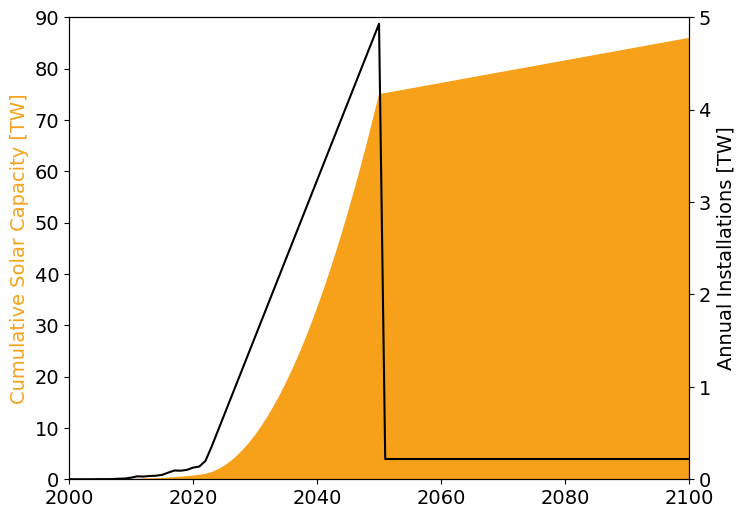

In [76]:
global_projection = pd.read_csv(os.path.join(supportMatfolder,'output-globalInstallsProjection.csv'), index_col=0)

fig, ax1 = plt.subplots()

ax1.stackplot(global_projection.index, global_projection['World_cum']/1e6, color='#F7A11A')
ax1.set_ylabel('Cumulative Solar Capacity [TW]', color='#F7A11A')
ax1.set_ylim(0,90)
ax1.set_xlim(2000,2100)
ax2 = ax1.twinx()
ax2.plot(global_projection['World_annual_[MWdc]']/1e6)
ax2.set_ylabel('Annual Installations [TW]')
ax2.set_ylim(0,5)
plt.show()

fig.savefig('energyresults-deployment.png', dpi=300, bbox_inches='tight')

In [77]:
#deployment projection for all scenarios
sim1.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', 
                    value= global_projection['World_annual_[MWdc]'], start_year=2000)
#for scen in scennames:
#    sim1.scenario[scen].dataIn_m.loc[0:len(global_projection.index-1),'new_Installed_Capacity_[MW]'] = global_projection['World_annual_[MWdc]'].values

# 2. Calculate Mass flow: Identical Installations
Can just calc mass here (exclude energy) because we're going to immediately do Install Compensation.

In [78]:
sim1.scenario.keys()

dict_keys(['PV_ICE', 'r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA', 'ex_Life', 'ex_High_eff', 'ex_Circular', 'h_EffLife', 'h_50PERC', 'h_RecycledPERC', 'h_Perovskite_life', 'h_Perovskite_Eff'])

In [79]:
for scen in sim1.scenario.keys():
    print(sim1.scenario[scen].material.keys())

dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])


#evolving weibulls

idx_temp = pd.RangeIndex(start=2022,stop=2101,step=1) #create the index
evolve_weibull = pd.DataFrame(index=idx_temp, columns=['alpha','beta'], dtype=float)
evolve_weibull.loc[2022] = [5.3759,30]
evolve_weibull.loc[2030] = [5.1   ,35]
evolve_weibull.loc[2050] = [4.602 ,40.767]

evolve_weibull.interpolate(inplace=True)
evolve_weibull = round(evolve_weibull,3)
#evolve_weibull_temp = evolve_weibull.reset_index(drop=True)
#evolve_weibull_temp.to_dict(orient='dict')
#dict([(i,[a,b,c ]) for i, a,b,c in zip(df.ID, df.A,df.B,df.C)])
dict_weibull = {'alpha':evolve_weibull['alpha'].tolist(),
                'beta':evolve_weibull['beta'].tolist()}
evolve_weibull.to_csv(os.path.join(altBaselinesfolder,'evolve_weibull.csv'))

In [80]:
IRENAregloss = {'alpha':5.3759,
                   'beta':30} #IRENA values

In [81]:
bifiFactors = {'PV_ICE':0.0,
               'ex_Life':0.35, # ITRPV 2022, Fig. 58, 0.7 but only 50% of market share is bifi 
               'ex_High_eff': 0.92,
               'ex_Circular': 0.0,
               'h_EffLife': 0.92,
               'h_50PERC':0.35,
               'h_RecycledPERC': 0.0,
               'h_Perovskite_life': 0.0,
               'h_Perovskite_Eff': 0.0,
               'r_PERC':0.7,
               'r_SHJ':0.9, # ITRPV 2022, Fig. 58
               'r_TOPCon':0.8, # ITRPV 2022, Fig. 58              
                'r_IRENA':0.0 } 

#MAY NEED TO CHANGE TO BE DYNAMIC

In [82]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
idx_temp = pd.RangeIndex(start=2000,stop=2101,step=1) #create the index
df_temp = pd.DataFrame(index=idx_temp, columns=['bifi'], dtype=float)
bifiPathDict={}

for f in bifiFactors.keys(): #loop over module types
    bifi = df_temp.copy() #copy of df
    bifi['bifi'] = bifiFactors[f] #assign column
    bifipath = os.path.join(testfolder,'bifi_'+str(f)+'.csv') #create file path
    bifi.to_csv(path_or_buf=bifipath, index_label='year') #create file
    bifiPathDict[str(f)] = bifipath
    #append bifi path to dict? or list?


In [83]:
#CALCULATE MASS FLOWs
#13 scenarios, 7 mats = 

for scen in sim1.scenario.keys(): #loop over scenarios
    if scen in ['r_IRENA']: #,'ex_Lightweight'
        sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], weibullInputParams=IRENAregloss)
    #elif scen in ['ex_Life','h_50PERC']:
    #    sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], nameplatedeglimit=0.0) 
    else:
        sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen]) 


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames 

==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon 

In [84]:
ii_yearly, ii_cumu = sim1.aggregateResults() #have to do this to get auto plots

In [85]:
sim1.saveSimulation(customname='_EnergyAnalysis_identicalinstalls')

:) Saved Input and Output Dataframes


In [86]:
effective_capacity = ii_yearly.filter(like='ActiveCapacity')
#plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, label='Capacity Target', color='black', ls='--')
#plt.plot(effective_capacity/1e6, label=sim1.scenario.keys())
#plt.legend()
#plt.ylabel('Effective Capacity [TW]')
#plt.title('Effective Capacity: No Replacements')
#plt.ylim(0,)

In [87]:
scennames_labels_flat[5:8]

['Long-Lived', 'High Eff', 'Circular']

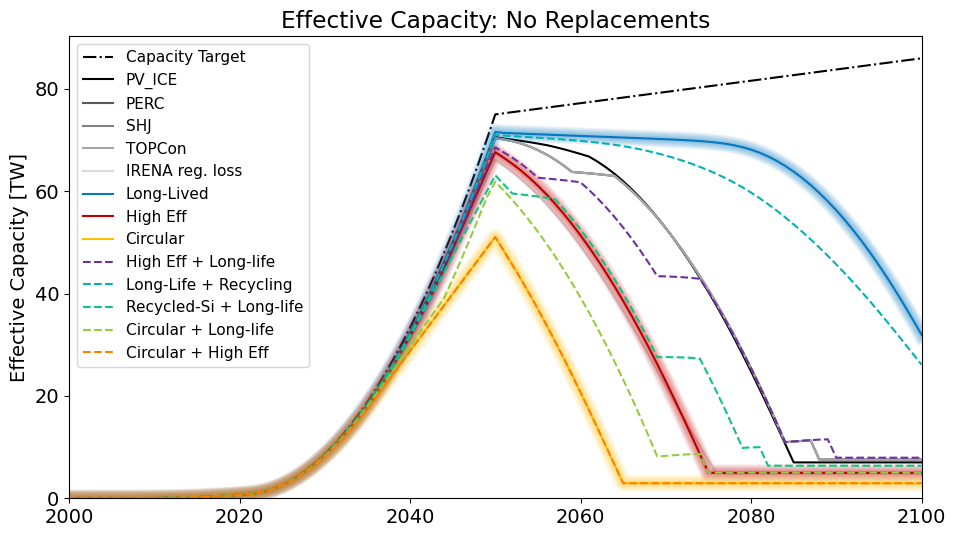

In [88]:
effective_capacity_tw = ii_yearly.filter(like='ActiveCapacity')/1e6

plt.rcParams['figure.figsize'] = (11, 6)

#capacity target
plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, 
         label='Capacity Target', color='black', ls='dashdot')

#BAU
plt.plot(effective_capacity_tw.iloc[:,0], label=scennames_labels_flat[0]) #, ls='dotted')
plt.plot(effective_capacity_tw.iloc[:,1:5], label=scennames_labels_flat[1:5])

#Extreme
plt.plot(effective_capacity_tw.iloc[:,5:8], label=scennames_labels_flat[5:8])
#create glowlines for extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    plt.plot(effective_capacity_tw.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    plt.plot(effective_capacity_tw.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    plt.plot(effective_capacity_tw.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

#Ambitious
plt.plot(effective_capacity_tw.iloc[:,8:], label=scennames_labels_flat[8:],  ls='--') #color=colorpalette[4:7],

#plt.plot(effective_capacity/1e6, label=sim1.scenario.keys())
plt.legend(prop={'size': 11}) #bbox_to_anchor=(1,1.02), 
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: No Replacements')
plt.ylim(0,)
plt.xlim(2000,2100)

plt.savefig('energyresults-effectivecapacity.png', dpi=300, bbox_inches='tight')

In [89]:
plt.rcParams['figure.figsize'] = (8, 6)

effective_capacity = ii_yearly.filter(like='ActiveCapacity')

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, label='Capacity Target', color='black', ls='--')
plt.plot(effective_capacity/1e6, label=sim1.scenario.keys())

plt.subplot(1, 3, 2)


plt.subplot(1, 3, 3)


plt.legend()
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: No Replacements')
plt.ylim(0,)

# 3. Calculate Mass and Energy Flow: Installation Compensation
Make the installations always match up to the cumulative capacity deployment schedule. 

In [97]:
#13 scenarios with 7 materials
#currently takes: 3:05-
UnderInstall_df = pd.DataFrame()


for row in range (0,len(sim1.scenario['PV_ICE'].dataIn_m)): #loop over length of years
    print(row)
    for scen in sim1.scenario.keys(): #loop over scenarios
        print(scen)
        Under_Installment = global_projection.iloc[row,0] - ((sim1.scenario[scen].dataOut_m['Effective_Capacity_[W]'][row])/1e6)  # MWATTS
        sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed
        UnderInstall_df.loc[row,scen] = Under_Installment #save the underinstallment as df
        #calculate flows for that scenario with it's bifi factor and modified weibull
        if scen in ['r_IRENA']: #,'ex_Lightweight'
            sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], weibullInputParams=IRENAregloss)
        #elif scen in ['ex_Life','h_50PERC']:
        #    sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], nameplatedeglimit=0.0) 
        else:
            sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen]) 


0
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silve

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_li

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7292922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81764921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755349806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.37270325  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.5024743  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722774157  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18082033  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026860701  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.90885967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1257532  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91403817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.1507256558  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.5437068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.138596  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41947569  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.9462202634  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.97914314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2493834  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03637608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023395037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.0978157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243143948.0481982  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43538085.16738363  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258587.2551268905  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230897294.9713057  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.49503281  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6212807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64849886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.76855570154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8498501  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.509713  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50828737  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.3352521025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.2852865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209839.50857876305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369842.86644672893  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243143948.0481982  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43538085.16738363  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258587.2551268905  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230897294.9713057  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.495032825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6212807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64849886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.76855570154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8498501  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.509713  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50828737  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.3352521025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.2852865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209895.40357867477  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188339048.300161  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369957.91923384333  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179048051.1800522  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355975.5179465118  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182879774.38958934  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243143948.0481982  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43538085.16738363  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258587.2551268905  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230897294.9713057  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.495214246  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6212807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64849886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.76855570154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8498501  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.509713  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50828737  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.3352521025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.2852865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254491403.7147644  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35661361.64218097  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209965.67292664107  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188377368.29546827  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192601250.772926  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33902175.11280083  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370099.64887870854  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179084518.73791635  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218121288.0343707  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34627715.571472384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356090.04288967274  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182917041.2139616  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243143948.0481982  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43538085.16738363  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258587.2551268905  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230897294.9713057  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631788.62064633  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6212807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64849886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.76855570154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8498501  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.509713  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50828737  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.3352521025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.2852865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254853701.0736341  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35672717.93791386  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210054.98202755855  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188428166.10920003  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192945968.6182742  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33912980.374557056  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370275.70946639485  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179132851.7231543  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218473528.5374782  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34638756.63270139  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356235.93319201085  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182966428.95314202  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243441784.3135397  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43549825.012167744  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258671.0681492372  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230949527.3443667  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129328502  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25631799.57212584  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6212807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64849886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.76855570154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8498501  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.509713  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50828737  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.3352521025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.2852865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1255331469.5854616  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35687451.37772081  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210166.42076470036  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188494506.43689585  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1193400469.4494245  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33926996.2849241  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370489.77694306633  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179195961.22771588  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218937905.4506652  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34653077.10198475  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356417.8111272193  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183030909.79654747  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243871630.4467719  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43566559.35550905  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258785.73669461018  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231024604.954838  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.2129329117  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25632022.63437608  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6212807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64849886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.76855570154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8498501  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.509713  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50828737  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.3352521025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.2852865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1255930964.1157963  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35705654.81296289  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210298.2904771869  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188576915.72079563  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1193970662.752752  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33944309.99897381  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370735.6963514335  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179274342.62977043  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1219520436.4516768  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34670765.44577579  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356632.83277933946  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183110987.19544548  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1244456295.6534898  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43588732.153253056  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258931.40478614214  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231124824.50189307  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.213448015  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25633670.402208466  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6212807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64849886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.76855570154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8498501  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.509713  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50828737  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.3352521025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.2852865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1256713097.1752064  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35729033.74667193  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210460.31886212292  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188683465.52935836  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1194714432.3188088  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33966542.19996625  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  371027.68920647725  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179375666.1883704  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1220280232.2574058  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34693476.69108225  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356896.5155475025  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183214494.00502625  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1245299599.6708705  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43619888.09013142  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  259126.7418123186  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231266723.80199274  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679311.451930972  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25639969.734836906  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6212807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64849886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.76855570154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8498501  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.509713  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50828737  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.3352521025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.2852865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1257716992.4520526  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35758566.195149966  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210655.69124164846  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188819080.31640822  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1195668915.245957  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33994621.04296844  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  371365.9542914554  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179504605.9312832  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1221255196.6727393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34722158.05559092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  357213.6062154303  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183346200.5630868  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1246471479.2677271  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43662067.63708122  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  259378.18050672876  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231460334.37943545  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683075393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679325.875228746  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25655430.71146702  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6212807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64849886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.76855570154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8498501  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.509713  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50828737  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.3352521025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.2852865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1258973000.9909654  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35795260.4544701  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210884.38060256097  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188987319.33619037  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1196862890.7997737  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34029503.01011776  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  371743.5344310427  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179664535.796881  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1222474687.9263542  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34757785.46329748  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  357583.63812343613  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183509548.18914565  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1247969814.552446  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43715865.45925957  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  259678.9907497012  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231706951.32509145  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.68307544  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2679542.6086679203  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25686507.002603155  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6212807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64849886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.76855570154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8498501  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.509713  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50828737  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.3352521025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.2852865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1260333497.291831  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35834731.30133981  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  211128.3746751157  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  189168036.177755  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1198156193.5711844  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34067024.43197979  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  372148.55768299947  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179836327.2173262  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1223795629.056991  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34796108.73184154  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  357980.629630536  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183685010.8558722  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1249680054.3481793  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43777121.73537294  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  260023.9001029105  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231987385.63178176  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.683260072  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2680411.466060674  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25729545.988070127  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1704518966.8915963  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89047099.19944882  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  348124.50972000184  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  306022306.01020175  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3780158527.662955  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68874594.83195819  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2723385.6537554935  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  355001957.1912676  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1262209621.54705  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35889161.59500482  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  211459.72754078862  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  189417234.57692537  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1199939657.956381  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34118766.46876509  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  372701.63732420147  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  180073217.9608534  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1225617206.7366414  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34848956.515116654  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  358522.82290391676  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183926964.04232597  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1252062627.4821758  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43862459.21735676  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  260504.4010014809  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  232378064.9076578  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890342.76772136  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2682950.596134489  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25786954.89537796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1707521595.6679163  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89190494.18444611  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  348730.059159181  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  306514658.0892709  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3787499302.232444  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  69018290.54808813  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2727432.5943322238  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  355687213.6506204  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1264093914.4306712  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35943828.87768671  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  211787.39522882967  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  189667511.91178688  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1201730887.529726  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34170733.78992061  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  373251.66920701275  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  180311134.35253468  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1227446715.5493872  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34902034.39717242  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  359062.10523012176  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  184169964.79541463  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1254603670.5621047  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43953472.67459732  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  261016.86102455  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  232794729.0831541  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890350.59897333  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2688195.938606517  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25855471.31163657  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1710597364.4588354  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89337382.07918267  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  349350.35897149047  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  307019003.2054196  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3795511846.798283  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  69175136.1668321  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2731849.8791050306  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  356435179.3955999  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1266705484.158342  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36019595.984693795  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  212234.42803338706  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  190014380.94267303  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1204213474.4830163  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34242758.83652432  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  374006.4388001059  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  180640871.87455234  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1229982356.305346  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34975598.645698  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  359802.2295712808  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  184506748.93040282  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1258120144.7678816  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44079423.50057624  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  261726.0392619631  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  233371338.28635  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8890578.726201111  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2699696.544029045  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25940834.13742788  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1714768203.1655698  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89536566.65987243  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  350191.5049232273  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  307702910.961489  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3806189644.801217  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  69384154.14118865  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2737736.507770592  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  357431944.7892121  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1269577055.5303488  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36102906.28390429  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  212718.16790626184  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  190395781.61535597  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1206943221.8637016  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34321954.52473563  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  374828.06375979475  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  181003435.55567732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1232770439.3985736  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35056486.775098115  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  360608.02165913186  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  184877060.73167628  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1262125584.9047778  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44222887.79581332  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  262533.8287721721  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  234028125.03086537  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.873592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.398234112  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.94059178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496745345  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21500313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8893125.85833994  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2716262.107624817  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26040170.5565872  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1719370907.7585137  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89756375.63567965  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  351119.74660496484  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  308457633.354596  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3818364807.897726  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  69622483.04825298  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2744448.628010381  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  358568488.2256819  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.6205015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.12518776  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.091371343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40395916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1272372418.293422  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36184005.61177186  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  213181.48001942612  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  190767059.34983703  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1209600524.5011878  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34399048.43923134  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  375619.81870333455  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  181356376.26022896  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1235484529.5776095  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35135228.21509991  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  361384.6261182284  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  185237543.90980297  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1266249905.9690788  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44370610.09214001  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  263365.593366976  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  234704405.11809126  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3274040280.4846115  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16296077.361585088  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  87306962.11572132  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4698773.141373027  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  308522456.4700811  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8907400.115601627  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2737372.2792233843  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26151805.22247909  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1723942767.7743323  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89974711.58301626  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  352041.76776536205  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  309207298.0489975  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3831234012.092631  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  69874397.81491749  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2751543.370418501  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  359769819.9404499  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2501675912.1324687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45403153.65003792  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1826970.5265610004  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  235085611.80094978  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1276107112.6362886  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36292356.9159383  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  213790.34089687932  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  191263097.65811923  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1213150766.0865033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34502048.382616185  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  376666.85579143156  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  181827915.7406517  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1239110641.1405077  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35240429.305423  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  362411.7712268275  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  185719160.3635666  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1271543992.7071528  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44560230.307857506  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  264433.268225916  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  235572495.9832755  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3306093840.602616  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16311620.067470878  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  88160989.478651  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4733282.818487329  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  311514635.14389724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8959242.243130548  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2764305.5030147145  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26282764.288986772  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1729910332.1518488  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  90259701.45959805  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  353245.2649444238  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  310185821.5186385  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3857547011.075884  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  70389474.96333463  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2766049.624802537  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  362226121.0225133  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2528368911.4545693  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45925669.307879865  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1841686.2736594062  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  237577385.66375124  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1279658923.1236627  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36395402.37645748  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  214359.74466770355  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  191734845.2072892  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1216527156.2640612  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34600004.53257847  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  377652.3762865893  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  182276364.157865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1242559186.026675  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35340478.81459004  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  363378.7058988569  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  186177192.2895477  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1277015000.6698897  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44756187.37494246  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  265536.62333584763  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  236469597.27208617  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3347574205.1169786  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16331733.811570153  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  89266182.35548419  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4777941.632694063  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  315386799.78411394  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  9084509.091708658  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2795497.517492533  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26426467.03354789  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1735736537.7414117  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  90537940.5378668  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  354420.25385917956  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  311141165.86813885  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3892109281.415215  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859648  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  71066031.65915394  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2785103.670521529  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  365452486.13912714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2562413875.4412813  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  46592099.72804602  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1860455.130390614  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  240755460.57389703  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1283647504.9305415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36511119.48765169  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  214988.34166255567  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  192264604.07525977  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1220318746.0695992  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34710006.49326874  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  378747.5841607658  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  182779958.77380756  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1246431803.5106497  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35452831.55792175  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  364453.41512354993  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  186691548.90894952  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1283284436.5341125  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44980742.02238548  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  266800.9998719983  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  237497619.7191777  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3401058521.2259035  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16357668.247299703  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  90691205.63765453  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4835524.206136863  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  320379525.38013524  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  9326508.91014023  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2831721.9400157267  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26587668.82349965  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1742305166.2934682  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  90851635.1244581  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  355744.96951075905  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  312218248.04018176  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3937580208.602512  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859648  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  71956125.39291738  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2810171.6164928526  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  369697167.1701136  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_lif

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2605686813.5380454  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  47439167.80921381  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1884311.3334928954  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  244794960.7744934  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1288598875.9777858  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36654769.13100352  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  215755.2328796944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  192922239.41505787  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1225025573.9335263  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34846561.426744774  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  380092.88032421854  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  183405114.17261115  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1251239218.0292988  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35592304.72090206  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  365773.7270891594  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  187330064.11016464  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1290904704.8799224  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  45253679.92443491  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  268337.80297586235  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  238747143.1343638  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3468202849.9106903  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16390226.395249715  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  92480183.0164931  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4907813.496138921  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  326647404.1311597  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  9720104.263620775  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2873343.2492477736  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26768869.059531722  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1750367011.8002477  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  91236640.49861962  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  357370.8268474635  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  313540178.4858298  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3995610828.924886  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  73092075.21207525  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2842163.672624265  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  375114287.26278627  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2659250040.2607136  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043997  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  48487668.365835786  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1913840.5328426573  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  249795052.62420735  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1293484407.6189563  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36796508.63530281  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  216498.66486387033  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  193571129.99145812  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1229669814.1327248  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34981300.56099455  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  381406.19786569756  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  184021956.70299283  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1255982707.3616428  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35729923.28035414  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  367062.8490057853  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  187960088.7938807  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1298995245.6322331  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  45543461.743023425  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  269969.4473715517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  240073778.84491444  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3546416892.7319884  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16428152.22499327  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  94564099.2020535  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4992020.7215962615  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  333948633.3881052  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10307331.448576713  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2918598.023252238  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26963232.496927753  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1758645162.2141838  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  91631975.83403412  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  359040.30706430983  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  314897577.24230963  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4063572233.015454  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859648  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  74422420.1964564  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2879630.5313680605  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  381458439.4634705  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2720781183.0074096  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043997  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  49692140.937167905  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1947762.4134230309  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  255538944.1739883  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1298879839.633384  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36953041.41727498  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  217305.04268997163  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  194287744.92836487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1234798771.244021  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35130102.34796922  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  382841.02530357626  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  184703178.75655228  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1261221272.1860213  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35881905.01662822  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  368471.4594771377  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  188655868.81502926  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1308174259.8777337  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  45872229.809626535  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  271820.6075857001  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  241578895.5557171  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3637396248.173366  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16472267.928774636  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  96988131.31338824  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5089971.406911422  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  342441496.1499025  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11036668.20308058  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2966808.093625453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27168580.690179344  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1772935479.2379212  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  92314431.0917023  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  361922.2795304576  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  317240813.0604302  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4143163961.673174  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  75980428.86968683  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2923509.1429814887  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  388888274.78363585  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2791378627.4723973  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043997  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  51074086.43124513  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1986682.511011333  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  262129169.00319245  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1304805457.4919913  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37124956.000913784  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  218174.57485811829  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  195074778.5225564  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1240431728.8595483  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35293526.24506069  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  384399.757648758  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  185451341.56148866  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1266974608.1920724  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36048821.34292787  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  370001.952086075  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  189420020.13620436  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1319014738.9173923  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  46260507.16050516  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  274006.84054751985  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  243356448.7568895  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3742710667.060814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16523334.675565775  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  99794103.41476488  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5203355.585701751  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  352272527.619738  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11830149.006584706  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3015861.5961581315  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27376548.39302759  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1792739629.7488072  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  93260207.63517267  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  365916.2438626005  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  320488172.42603964  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4235935850.878168  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  77796439.28246395  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2974653.926035221  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  397548469.3887555  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2872000086.4203033  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044248  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  52652252.08247132  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2031128.8089438258  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  269655128.96607256  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1311644512.1982603  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37323371.300442986  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  219159.58140236454  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  195983133.72329438  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1246933009.6052723  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35482142.01462076  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  386179.04560416023  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  186314834.02213866  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1273614823.7152147  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36241467.901341155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  371749.28590895206  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  190301965.75055054  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1331369490.026679  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  46703021.74071229  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  276498.4614446579  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  245382302.71626338  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3861814165.7808  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16581087.719026731  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  102967468.4498205  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5331585.438138694  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  363390760.5877714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy fo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12611558.172249626  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3062240.3578110794  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27572646.813144896  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1818095957.8112957  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  94471136.64204217  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  371029.93302690063  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  324645942.7563509  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4341284086.102683  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  79858631.76097088  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3032731.999919702  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  407382657.5913291  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2961966967.5434446  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044248  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  54413354.44143796  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2080727.2019106462  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  278053477.91874355  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1319140322.2270122  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37540840.44726902  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  220218.8310850258  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  196978718.39301792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1254058609.195646  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35688870.58132651  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  388107.5810139184  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  187261247.77696344  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1280892700.0079463  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36452614.33408355  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  373643.49874015775  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  191268604.71783957  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1344456641.76785  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  47171768.978728116  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  279137.78784418426  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  247528251.09978426  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3992358594.7349954  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16644388.44620942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  106445662.88421312  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5472132.886712118  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  375576996.8393524  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  13306295.39409048  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3102448.644710049  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27742383.546580773  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1847792215.3702958  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  95889325.41074082  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  377018.86920588865  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  329515347.28116286  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4370182753.143634  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  80424323.38061425  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3048663.723085168  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  410080329.0794045  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3059283888.9776516  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044498  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  56318333.89349404  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2134377.643621613  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  287137948.28162473  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1327248423.8077168  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37776073.45429178  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  221342.59583889652  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  198055626.90626505  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1261766259.880571  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35912485.66922952  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  390170.2642484977  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  188284968.87333986  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1288765066.0426927  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36681008.15923544  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  375669.8130750489  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  192314203.1132015  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1359969770.4986653  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  47727408.31029311  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  282266.368532195  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  250071995.84895813  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4138489050.5711813  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16715246.806018967  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  110339127.67820306  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5629460.647775386  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  389218178.4097724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  13884449.883881057  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3135371.710672743  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27881227.77282844  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1883994707.5830207  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97618229.05299217  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  384319.9378658557  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  335451603.02112836  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4403904112.235654  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  81084419.23258929  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3067254.1776918117  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  413228195.68628913  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3166810811.5850887  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044498  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  58423174.19352831  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2193656.819418497  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  297175515.51292694  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1335028455.287061  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38001788.46062236  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  222399.77212976923  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  199088961.53458697  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1269162043.5129826  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36127052.840820216  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  392127.04967843136  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  189267268.154678  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1296318900.3105083  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36900160.710752346  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  377592.427823953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  193317494.49399635  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1376449770.280634  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  48317678.41131117  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  285589.9410977905  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  252774281.99891436  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4296845175.191915  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16792033.367671795  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  114558330.25712797  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5799950.874433984  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  404000618.0892945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14329391.657920698  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3160432.347174754  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27986844.80488818  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1924529996.5313857  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  99554051.82151152  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  392494.81505454774  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  342098323.370572  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4438298133.560242  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  81757682.45270884  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3086215.4683809024  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  416438854.86846226  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3281845932.3502455  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044498  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  60674987.52766227  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2257075.235767572  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  307913968.0850027  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1343951942.346709  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38260677.50798767  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  223588.10237051855  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  200274168.5878734  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1277644808.6168256  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36373155.62127788  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  394345.69478862226  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  190393939.0362787  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1304982945.246385  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  37151522.79877758  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  379772.71354043396  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  194468242.74962234  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1397894922.5776854  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  49085787.17224558  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  289914.8513394445  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  256290722.46024418  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4470702282.928724  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16876336.32440295  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  119190537.30996181  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5987129.8533035945  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  420230064.3082578  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14681175.460815642  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3180082.5232319725  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28069619.439118322  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1971490568.8862267  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  101796723.51685832  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  401965.4990356228  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  349798621.0615555  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4477785153.226956  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859648  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  82530641.15279362  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3107984.5093220645  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  420124942.08324754  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3406549235.3466096  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044498  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  63116055.60000362  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2325823.683519223  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  319554939.0849938  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1353382263.8509645  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38534270.88401496  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  224818.3288091707  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  201526692.7958304  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1286609376.127216  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36633236.4985508  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  396663.15716041124  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  191584602.34670377  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1314139088.884683  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  37417161.700724095  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  382050.51858722104  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  195684350.97597763  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1423054472.1212277  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  49986935.84015298  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  294988.8555707521  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  260416226.29338384  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4660102072.717631  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16968175.895941418  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  124236859.8531482  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6191042.478518066  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  437910409.63480836  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14926170.830391096  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3193686.3647664273  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28126905.34912006  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2024063607.0653636  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  104307426.83137153  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  412568.0663714157  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  358419215.40695345  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4521140756.342795  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859648  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  83379327.40231724  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3131886.2853290564  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  424172159.00879586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3540709508.8642654  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044498  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  65742243.93977907  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2399785.7224761597  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  332078712.0392309  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1364437704.8631742  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38855012.38032939  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  226230.54946394553  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  202995063.46497306  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1297118800.1448777  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36938136.8983725  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  399348.10218452  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  192980451.68098858  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1324873103.1859818  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  37728577.93501606  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  384690.0047574053  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  197110030.1275174  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1452231861.1615846  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  51031992.91564748  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  300873.14992956247  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  265200550.03966853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4867549781.039538  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  17068766.86634404  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  129764046.80622704  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6414385.951315947  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  457275516.2403673  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15113451.023499943  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3204035.7414997285  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28170475.593786836  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2083814450.5463414  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  107160916.87053356  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  424618.20391946624  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  368216780.87558335  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fra

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4647112131.48841  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859648  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  85845217.99629667  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3201333.8163431715  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  435931503.7066815  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3685846916.5180535  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044498  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68583309.76091762  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2479799.4129490363  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  345627193.217479  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376182572.863893  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  39195755.59739381  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  227730.83743616694  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  204555003.0156578  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308283601.0528395  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  37262051.15428665  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  402200.48273293243  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  194463347.40282938  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1336276500.024458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  38059414.3585473  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  387494.09159793047  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  198624615.88015446  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1470669533.0340598  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  51652015.90944659  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  303126.3002972252  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  267484761.96884263  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4916237425.03472  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16798205.36732902  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  130987050.05564316  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6440388.083052281  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  461540956.3777275  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15255193.767653897  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3211844.297314043  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28203343.888714746  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2097042344.2037723  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  107595931.64514942  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  426547.4858184759  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  369738078.11679345  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4681525047.831791  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9688547.120422443  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  86567854.37938759  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3206012.5731869843  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  438879733.51238036  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3692236416.435049  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6778434.065943808  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68726290.25337532  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2472860.8212001137  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  345970872.34893626  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1389516241.6478653  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  39582593.252482325  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  229310.62661958602  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  206325965.2172402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1320958733.488269  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  37629783.290782474  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  404936.4718789102  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  196146843.58132896  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1349222504.734526  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  38435005.06699713  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  390677.50457207137  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  200344088.99550572  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1488497235.6781147  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  52263405.67546178  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  305568.98296054755  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  269704372.7590087  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4959438506.191134  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16524983.445190419  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  132138089.29371518  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6463482.28126901  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  465520413.2972953  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15335100.87516542  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3216233.8878935585  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28221818.34694315  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2149006935.568334  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  109165508.11064784  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  436582.79901672615  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  375090127.42016  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4712968334.895436  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9490821.668985317  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  87286888.23684992  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3210589.8711457527  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  441776934.1862302  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3695262243.6167703  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6640098.676842868  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68857954.81666718  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2465603.535935913  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  346226738.6521348  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1405781317.6902018  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40054477.17115421  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230327.58979165315  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  208188496.23012695  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1336420493.9571323  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38078361.34234655  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  406509.222491503  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  197915861.97624806  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1365014688.7511861  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  38893169.39766315  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  393106.62147715065  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  202150154.75192097  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1505312751.3262606  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  52849720.28142633  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  307983.0148932919  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  271792713.4684076  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4998908550.901682  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16249952.351093583  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  133189719.69217224  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6482559.550864566  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  469151580.4280392  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15391777.070339775  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3219339.179108835  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28234886.07676818  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2164649701.8003254  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  109912551.58363473  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  439737.5241008585  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  377655129.3069903  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4742548475.301994  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9293096.217548126  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  87969450.98481126  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3214140.0235716323  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  444500211.349774  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3695791113.3515525  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6501763.287742179  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68940741.41959023  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2456969.687706221  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  346249515.626265  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1423023423.8613217  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40538603.70616593  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230851.34894193316  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  209930971.7996716  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1352797861.4911387  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38538158.11785749  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  407138.2953213339  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  199570420.69150427  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1381735506.0408723  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  39362583.96804834  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  394823.20033404895  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  203839149.2740643  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1521109287.9942043  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  53415101.69306123  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  310454.6115581472  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  273762850.44847345  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5034159723.542936  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  15972875.534540407  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  134128943.4757444  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6497094.675613752  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  472388918.6366033  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15431733.528591678  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3221523.055432501  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28244075.400888544  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2180736714.7090635  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110680810.71473081  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  442981.8417873403  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  380292975.95459837  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4769954827.226363  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9095370.766111048  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  88609461.80726312  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3216491.774830109  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  447020566.7937382  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3693607415.6161895  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6363427.898641238  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68970429.49435608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2446840.411540671  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  346019076.218016  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1439526822.9906678  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40998210.2648206  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230964.05147669147  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  211569152.56810996  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1368471767.3028958  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38974613.71284609  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  407075.0669669408  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  201125684.45125243  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1397737215.1356938  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  39808142.60714437  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  395973.7283087908  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  205426652.06573126  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1535894000.90064  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  53963649.30320435  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  313058.5768306805  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  275628375.583626  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5064885419.198607  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  15693604.323432444  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  134947591.5366271  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6506757.55687466  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  475203806.5564863  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15459750.777182126  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3223050.8695741524  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28250503.615667857  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2197448683.9716296  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  111478915.56224978  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  446352.1963560893  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  383033298.99308157  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4795429310.99397  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  8897645.314673843  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  89211656.29635303  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3217778.4946591808  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  449360583.6207746  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3688778143.895006  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6225092.509540298  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68948330.43891266  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2435252.6406876007  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  345541674.2249175  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1455401438.8759785  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41440981.42388542  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230802.95447088304  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213120963.7685404  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1383548265.5735974  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39395082.52214829  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  406683.0272956493  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  202598904.52515814  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1413128911.0627508  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  40237381.382803276  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  396786.29602403066  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  206930388.01571432  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1550037244.9138055  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  54491249.02885106  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  315860.81867793266  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  277402994.5377905  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5091553363.319306  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  15412365.516886322  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  135658125.8394724  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6512051.759749573  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  477639906.0496893  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15479269.37448511  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3224112.9433587217  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28254971.93962078  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2215028099.5092063  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  112318446.59157722  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  449897.4915000745  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  385915860.386286  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4819120623.867293  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  8699919.863236574  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  89778945.20208655  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3218082.15928352  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  451534142.6221592  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3682283017.525324  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6086757.120439609  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68893622.26648591  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2422746.4906215267  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  344908765.8002535  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1477858844.2008297  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42177660.00862624  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230454.2177018212  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214598934.56734544  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1404868898.0209875  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40094548.25130134  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  406223.8120311821  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204002159.83085087  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1434891466.69351  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  40951383.597264305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  397413.90723763895  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  208362777.80263838  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1563475225.552712  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  54995902.816070706  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  318496.8066963056  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  279078340.328598  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5113834681.808342  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  15128999.6445237  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  136251783.94177786  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6512623.210031247  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  479666516.936424  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy fo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15492791.226488084  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3224847.2133034933  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28258060.960931126  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2233791939.060863  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  113214541.54418036  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  453681.6531010567  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  388992636.1393973  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4839061889.925605  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  8502194.411799492  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  90272826.91386479  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3216318.4376291456  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  453357637.22931194  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3674143233.854968  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5948421.731338668  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68806719.91531532  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2409333.6473581768  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  344204105.4819007  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1510748595.908738  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43131860.58412156  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230528.63926377922  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  216649974.81385723  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1436134258.3220644  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41001621.830247894  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  408261.85097211105  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  205949852.76662645  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1466824979.3239837  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  41877841.67454614  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  400761.79879302514  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  210351077.39797294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1576035920.0788007  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  55469134.52991138  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  320955.869708895  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  280609834.29030484  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5131442141.867372  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  14843367.427746993  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  136720912.88180026  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6508162.665592093  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  481256826.22460884  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15502114.244289795  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3225352.501757302  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28260186.573781874  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2245027992.68775  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  113599124.33404587  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  455873.57168342156  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  390306923.86306155  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4856145536.423647  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  8304468.960362286  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  90710770.70175603  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3212979.3213836513  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  454914374.937242  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3664455883.3715873  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5810086.342237728  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68689523.93240985  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2395067.6365071917  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  343456486.5699097  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1547088336.258862  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44186152.55517043  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  235170.67315957096  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  221476576.37551808  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1470679215.8329787  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42003843.392457224  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  417087.38809204294  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  210538073.38304368  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1502108175.3713357  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  42901481.08273305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  409437.9105805435  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  215037349.98830405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1587837395.5542724  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  55915173.02095889  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  323261.818665581  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  282016836.31315184  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5144495953.509075  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  14555527.15614575  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137068715.50626698  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6498799.547585573  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  482422055.43955904  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15508516.553126464  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3225698.8645303394  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28261643.57365907  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2255546183.9659443  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  113949424.5440825  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  457920.7167439691  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  391503501.0583211  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4870049164.561124  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  8106743.508925079  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  91086465.60687578  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3207887.073337663  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  456174260.0308046  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3653740222.200102  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5671750.953136536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68552198.7602298  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2380234.7219582736  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  342667111.96721375  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1556864472.245978  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44469778.733557895  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  236419.47555014465  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  222775031.25625762  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1479972518.4004183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42273461.562179364  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  419461.6387116817  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  211772398.89700782  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1511600079.256605  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43176861.09260074  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  411771.962718974  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  216298053.49565923  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1598769876.7463834  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  56330086.43007619  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  325392.5148553947  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  283281346.14865726  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5153461810.482277  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  14265704.643668514  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137307599.6476553  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6485035.233732222  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  483205676.78525615  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15512897.873952214  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3225935.4887853707  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28262638.920453794  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2265574834.8592796  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  114276346.02788551  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  459869.13467985636  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  392619806.51696944  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fra

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4880600767.28879  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  7909018.057487997  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  91396544.58997138  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3200946.866671395  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  457121235.7655187  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3642795549.6636753  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5533415.564035595  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68410390.68889852  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2365275.554331207  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  341840231.9936075  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1566843276.5665362  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44759284.74473108  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  237694.16676833175  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  224100404.30661705  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1489458479.7183065  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42548669.16572234  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  421885.1097407839  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  213032313.11955458  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1521288759.0811768  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43457949.98456017  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  414154.4019152034  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  217584892.55177674  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1608948346.0964215  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  56717993.124868415  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  327371.1471431697  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  284422217.8904314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5157659860.817491  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  13973570.231482739  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137419451.49325466  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6466137.778130663  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  483544226.5292171  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15515886.082555147  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226096.6173478533  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28263316.682734914  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2275277531.9326324  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  114587701.10418095  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  461751.8164999625  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  393682664.12944555  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4888321775.582602  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  7711292.606050759  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  91651214.6662281  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3192446.164261507  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  457803977.37871826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3631319512.318105  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5395080.174934404  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68258181.14752434  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2350023.4473437513  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  340970245.1206668  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1577104225.237928  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45056976.35439487  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  239004.89907067228  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  225463251.43772733  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1499212650.5643203  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42831658.08936653  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424377.10287316656  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  214327850.6160937  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1531251380.1708252  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43746986.48631334  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  416604.2030657135  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  218908116.16444546  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1618458149.4923506  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  57081949.969812244  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  329214.9274982973  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  285453446.017482  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5157845627.909121  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  13679490.271340486  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137424401.02706  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6442920.596460689  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  483508232.281479  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15517916.26252211  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226205.925236946  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28263776.461022407  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2284513982.0228395  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  114876789.86514622  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  463540.46884783107  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  394669069.5100237  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4893067983.427076  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  7513567.154613552  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  91847653.00183326  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3182305.4658904057  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  458209023.3340687  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_lif

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3620281581.4474325  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5256744.785833464  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68114547.54361501  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2335012.866758372  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  340063967.21795404  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1577643424.248798  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45072619.64690276  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  239073.77628500914  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  225534867.21601418  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1499725219.0841005  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42846528.775557734  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424508.0537506253  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  214395929.363883  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1531774902.4697123  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43762174.96457612  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  416732.9368114411  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  218977649.78028947  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1627163428.3379316  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  57417090.86852499  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  330896.45689715934  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  286352753.2963246  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5153642383.794849  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  13383282.088621648  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137312410.79965788  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6535362.658331996  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  483062526.735492  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15519288.469439479  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226279.705470122  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264086.79621579  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2293634815.4755855  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  115160357.182327  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  465305.8044305617  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  395636516.8055139  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4894724494.197828  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  7315841.703176345  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  91983610.49452056  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3170461.4294942827  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  458325648.10754406  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_li

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3609631561.283504  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5118409.396732523  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  67978507.29464017  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2320216.1398425726  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  339118360.39061505  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1578037892.32596  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45084063.99192506  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  239124.16558794174  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  225587260.0019535  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1500100204.7838795  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42857407.896011725  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424603.8550035808  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  214445734.5233783  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1532157901.752779  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43773286.575863495  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  416827.11605160846  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  219028519.29448947  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1635256830.3556838  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  57730315.95402471  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  332454.587202247  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  287151728.88225496  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5145391741.305445  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  13085111.330690589  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137092582.6613244  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6735712.6132006375  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  482238999.22346056  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15520209.266628861  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226329.152024382  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264294.776746605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2302580574.7712016  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  115435563.57379717  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  467035.8322661268  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  396575256.5478312  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4893541730.242182  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  7118116.251739169  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  92063989.16357866  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3157052.111942884  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  458177228.45992666  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3599889460.034216  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4980074.007631332  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  67860239.5650898  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2305919.9451064896  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  338136409.0555443  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
******

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1552692268.7607021  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44361277.30120563  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  233854.3510616766  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  221739236.49090794  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1476006375.8045402  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42170318.90528722  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  416248.5150242454  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  210787760.98230925  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1507549178.7245119  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43071514.23892982  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  408645.81045100203  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  215292373.50404277  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1642677582.5807738  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58019448.49909252  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  333877.06214163534  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  287840407.6088084  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5133145996.795965  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  12785003.355943289  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  136766309.9835925  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  7042568.626564006  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  481309808.4089088  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15520821.051600557  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226361.966883874  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264432.80058343  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2311339515.6021843  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  115701848.17275529  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  468728.18384368153  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  397483362.97969866  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fra

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4902523504.974817  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  6920390.800301931  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  92343338.75213806  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3149246.465185605  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  458977661.7877756  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3591321924.4982786  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4841738.618530392  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  67764963.96800777  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2292271.283897064  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  337118233.07434845  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1523246246.9784927  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43526574.45988188  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  227962.5921796215  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  217385036.91912678  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1448014663.1084294  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41376841.18888215  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  406793.05482968246  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  206648610.90165353  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1478959272.760785  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  42261079.60984456  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  399384.6225850453  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  211064768.25314495  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1649392478.1075149  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58283299.12000064  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  335157.1847758714  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  288413344.4175803  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5173078063.043161  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  12510196.295146672  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137830250.37298685  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6365651.490131756  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  484716828.11174357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521222.33883572  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226383.4686673023  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264523.23961228  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2319363416.283344  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  115933029.840546  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  470272.2975990949  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  398270942.1759588  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4909839405.7865  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  6722665.348864095  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  92590078.84645578  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3140522.428590505  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  459622586.8849883  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3619259743.7408223  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4703403.229429451  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68384280.95891711  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2298747.8833290227  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  338759658.13898337  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1489437742.7488976  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42565306.866751775  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  221420.35891796177  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  212451417.56089696  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1415875926.5388672  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40463049.62511867  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  396179.081765098  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  201958657.98886403  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1446133719.487494  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  41327759.98192209  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  388986.0671899801  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  206274589.30958956  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1655589864.9133673  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58528613.944246285  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  336332.9398245517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  288901423.41886204  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5210343327.168936  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  12234096.107443953  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  138823137.12669063  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6382355.036939321  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  488142180.4305942  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521481.502857639  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226397.342238005  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264581.593290523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2325826793.3306  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  116089686.39060113  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  471501.6957230632  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  398802636.57498807  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4916175455.343619  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  6524939.897426888  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  92817638.34526649  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3131258.203795408  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  460176043.5145293  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3645331778.348965  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4565067.840328761  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68967075.20190024  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2304195.88292143  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  341166872.6892976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  si

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1451869778.1474998  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41494969.45509019  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  214353.23991444474  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  207018471.09887618  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1380163405.5240486  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39445575.09029951  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  384604.6379424908  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  196794039.2304105  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1409658008.6717293  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  40288541.63945145  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  377644.0359862893  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  200999600.735446  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  si

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1661238689.3343508  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58754280.71153719  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  337398.064599143  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  289299552.62920743  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5244579483.042923  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  11956527.111331612  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  139735317.04711974  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6395797.368851297  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  491284767.4940935  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521645.969159268  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226406.1391619137  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264618.593988247  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2330830528.2174373  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  116176635.56712233  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  472436.72329459543  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  399094988.0828656  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4920998648.212359  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  6327214.4459898705  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  93015583.6632873  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3121159.9469699017  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  460588275.9710661  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3669284546.744319  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4426732.451227821  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  69508384.79319791  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2308475.539262291  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  343376255.1378826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1408883898.6723318  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40267446.98662284  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  206495.31316930603  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  200865923.5571907  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1339300554.944162  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38278678.70886312  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  371609.5001607345  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  190945359.7581951  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1367921903.840562  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  39096708.25015993  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  364906.98567379155  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  195025932.81673184  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1666335796.3581884  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58960186.41765964  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  338351.92281855375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  289607214.70965475  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5275419147.995044  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  11677311.163702961  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  140557001.6785847  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6405582.952352052  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  494110294.3725524  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521748.39472998  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226411.6136965407  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264641.620371856  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2229938679.433771  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110560508.89705627  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  451645.0050806806  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  379780846.9285443  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4953508782.794268  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5338587.188804  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  94214279.92185524  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3060880.8877232424  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  463433028.5032785  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3690861015.6302347  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4288397.062127132  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  70003178.3041398  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2311445.150891087  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  345363811.59620106  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1361722934.1113563  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38918796.556260236  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  198083.62906372597  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  194158846.1261589  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1294468822.4871886  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36996636.75245177  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  357578.68495363987  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  184569538.06422928  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1322132100.6566377  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  37787268.58230972  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  351152.1285129295  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  188513857.45175034  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1670999242.667545  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59150559.54143192  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  339218.3233393907  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  289843767.84847426  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5302638211.094863  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  11396339.593625084  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  141282219.8632411  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6411470.503920552  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  496597840.458583  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521810.948240573  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226414.9550169036  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264655.67425477  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2230761351.8014827  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110599796.83460288  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  451810.915963446  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  379915743.5410984  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4992963267.556304  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5338587.188804  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  94986601.74704857  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3082631.99218787  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  467116078.60619235  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3709904389.447323  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4150061.673026192  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  70448386.4604989  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2313018.2770234686  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  347114905.3023077  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1310754083.5320797  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37459671.377947204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  189200.1628358338  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  186946009.75393826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1246017271.6319203  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35609576.28360179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  342638.6302389968  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  177712936.3491129  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1272645122.2145731  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36370566.117514305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  336503.1858587861  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  181510727.61849985  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1675443203.4554543  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59333071.27305427  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  340040.459535757  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290044331.1394435  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5326582417.078655  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  11113780.052015025  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  141920183.5408638  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6413832.261123218  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  498779680.79504  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy fo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521848.391538454  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226416.953997665  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264664.08213775  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2231356859.010144  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110628236.16347554  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  451931.01374545484  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  380013391.04737675  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5034166528.663963  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5338587.188804  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  95793155.88564229  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3105347.1903768363  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  470962375.8263494  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3726656562.864556  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4011726.283925252  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  70848744.35219753  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2313328.2732531745  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  348652116.96384126  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1255060144.6959555  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35863461.4939182  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  179714.80104191328  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  179105592.71824133  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1193073999.826104  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34092201.58331459  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  326552.8237206681  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  170259749.54159957  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218570433.0816472  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34820764.55789134  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  320727.86245157477  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  173898263.44847038  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1679550322.801796  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59503518.233173504  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  340794.6638759969  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290189661.3009032  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5347013925.258705  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  10829517.210408704  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  142464555.7412511  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6412412.15863349  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  500633613.11075866  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521870.345709058  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226418.125538685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264669.00973791  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2231788367.960475  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110648843.5125914  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  452018.03749109217  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  380084147.1563263  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5077829074.83502  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5338587.188804  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  96647850.54771867  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3129418.182900619  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  475038245.6834443  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3740951134.5216603  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3873390.894824563  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  71200994.6713858  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2312283.4031550316  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  349959913.12368584  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1195780371.419195  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  34163219.04323213  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  169835.01647668084  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  170788909.37066975  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1136721994.2979357  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  32475932.379096046  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  309663.7596551858  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  162353818.7312654  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1161014164.3242292  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  33169955.082160417  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  304161.83663561643  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  165823379.96859682  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1683662788.8527029  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59674156.69814012  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  341549.9465026958  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290335868.18116623  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5363742948.081905  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  10543459.041209066  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  142910279.81038693  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6407005.866350342  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  502141920.86296225  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521882.94521649  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226418.7976401327  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264671.83665295  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2232102028.346296  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110663822.82894036  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  452081.29435195494  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  380135579.2029045  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5124895132.703734  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5338587.188804  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  97569168.97629017  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3155365.5182358986  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  479431831.11036414  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3752655322.650713  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3735055.505723372  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  71502538.21398105  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2309810.4646548834  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  351025898.69147414  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1132397222.4185102  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  32343929.069414444  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  159498.12036647173  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  161927220.48683545  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1076469274.6020684  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  30746495.287910245  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  291849.3825750055  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  153929799.65414628  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1099473821.692639  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  31403559.279803716  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  286685.06327914936  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  157219336.48379242  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1687398924.6792266  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59831316.007615186  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  342229.33344821073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290420366.8110282  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5376898692.999551  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  10255668.196845304  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143260798.3205939  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6397752.492298235  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  503316665.48192096  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521890.015987474  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226419.1747087403  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264673.422635052  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2232330901.564298  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110560570.41903423  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  452127.4519222471  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  379774866.4036763  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5173577253.681612  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5140861.73736688  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  98580999.41410467  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3183861.9673008784  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  483938265.54825515  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3761859525.1388826  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3596720.116622432  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  71755144.51928878  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2305959.293757657  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  351858512.2502889  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1064513644.715667  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  30394072.234049328  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  148664.66128677712  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  152467789.9572794  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1011938397.8032857  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  28892939.899757195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  273025.2351908525  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  144937560.78362697  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1033563896.156341  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  29510392.726503845  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  268214.3300182649  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  148034930.13815123  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1620014644.243604  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  57441129.69531214  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  328565.64591133286  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  278842989.3251759  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5386881231.094419  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  9966338.670969108  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143526770.66978437  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6385082.763168326  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  504195193.339067  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521893.891327275  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226419.381324618  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264674.29167871  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2090111627.7812173  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  103620296.31069483  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  423371.55964467145  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  356074314.6545384  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5155485694.861224  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4943136.285929578  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  98330388.2994576  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3161130.8966573696  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  482756345.1928308  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3768843645.197928  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3458384.727521492  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  71964292.69473559  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2300884.2000194504  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  352483882.58014303  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  991976941.5404358  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  28309218.48405146  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  137336.08758845687  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  142390336.77661884  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  942984208.6696347  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  26911054.95737064  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  253176.49561327006  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  135357822.7725665  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  963136130.4623156  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  27486154.168867026  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  248734.72185002913  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  138250469.57774314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1546750034.3747063  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  54840325.50106003  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  313716.0541366116  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  266301392.60419318  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5393284028.176487  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  9675273.335981393  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143697365.25856772  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6368558.99392398  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  504739554.73617387  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521895.962158479  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226419.491712932  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28264674.7559812  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1936010623.6456754  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  96183932.82853532  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  392219.4420301  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  330679332.7593315  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5028445530.673278  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4745410.834492371  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  95947107.43430175  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3078336.8820199557  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  470314296.20136356  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3773323257.808458  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3320049.338420552  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  72124415.11847726  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2294428.3810291314  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  352875458.7932664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  915120893.1928998  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  26099051.484936386  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  125587.08234574618  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  131739193.25163724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  869924002.4314418  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  24810045.859869048  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  232418.2735661256  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  125232728.40017676  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  888514600.5574764  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  25340245.728800304  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  228358.8733755191  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  127908998.18858047  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1524907522.4848661  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  54081325.15208881  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  309236.91602509643  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  262191666.3327802  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5396800859.530087  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  9382808.602101678  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143791066.86911348  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6348928.120661085  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  505014513.13797235  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521897.038548822  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226419.549084015  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28244935.499076974  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1772221618.0126317  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88339694.51846817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  359113.5151668306  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  303891250.442724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4892940307.391525  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4547685.3830551645  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  93398122.97519246  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2990876.113103843  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  457626963.6613729  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3775783751.539365  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3181713.9493193617  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  72245013.27531596  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2286859.429624003  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  353078551.59209  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  si

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  833969690.5339142  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  23764273.064238578  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  113444.16308230931  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  120517572.38401426  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  792780775.1875315  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  22590579.772238284  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  210781.33445731588  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  114565331.98125029  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  809722793.975799  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  23073348.8288524  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  207116.6444336023  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  117013635.55729401  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1498831365.0123796  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  53170686.79105419  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  303903.965504777  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  257387733.63095656  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5397344539.493153  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  9088902.193180349  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143805552.54756618  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6326096.277080944  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  505011929.8204728  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521897.581108065  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226419.5779995928  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28128444.816525273  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1596911270.6463513  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  80011412.60786697  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  323684.043654894  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  275450010.5813656  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4745453614.848454  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4349959.931618083  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  90614601.16726564  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2896810.006608797  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  443821168.8765416  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3776164128.3633437  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3043378.5602184217  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  72324893.12841901  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2278143.7178279534  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  353087466.8510383  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  748215606.556214  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  21295955.417028487  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  100885.84540196018  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  108684602.23466837  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  711261998.2547466  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  20244169.824759867  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  188209.8808496502  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  103316780.20023331  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  726461930.5878205  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  20676795.23175564  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  184952.88961311718  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  105524698.05858639  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1467975235.671944  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  52088842.452186674  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  297607.0232626848  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  251800011.3692526  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5395425733.472408  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  8793801.729830826  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143754428.3404629  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6356865.111560605  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  504779475.062228  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy fo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521897.845257755  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226419.592076563  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27907604.4866395  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1419289412.3012397  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  71244123.31470622  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  287640.2203074543  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  245509454.76495758  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4584946894.773306  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4152234.4801808135  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  87576212.22474115  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2795566.009384257  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  428799963.11799806  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3774821667.008168  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2905043.171117482  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  72371048.41150758  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2268478.2120192503  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  352935556.30345774  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  658199954.4653671  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  18704000.754185386  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  87984.94057676077  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  96285615.62202738  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  625692127.7263514  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  17780229.168182578  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  164817.8408879663  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  91530166.93372916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  639063400.2336887  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  18160199.250776663  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  161979.1284768253  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  93486200.50116473  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1432421408.0672135  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  50838738.95884686  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  290362.68167112547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  245441990.252923  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5391415852.968398  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  8497687.30873202  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143647590.04668537  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6443359.62133397  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  504351819.8815917  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy fo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521897.96886865  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226419.598663748  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27576396.191338006  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1419299368.1413753  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  70678043.34681906  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  287642.2281325501  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  242799557.75262582  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4412581708.9738655  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3954509.0287436065  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  84305693.72854015  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2687784.485954143  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  412671777.4135831  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3772016219.47606  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2766707.782016542  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  72388565.7294342  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2258006.1675998573  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  352647076.9621897  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  si

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  564092559.9256661  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  15993336.073883057  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  74787.89813934512  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  83343168.59103234  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  536232601.7496947  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  15203441.461248327  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  140672.7607277349  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  79226934.20654584  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  547692091.0537535  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  15528344.63617942  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  138261.35705932984  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  80920043.13384865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1392288662.9117105  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  49424630.722727545  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  282194.89560424996  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  238333147.19224003  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5426208591.47883  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  8220388.198404208  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  144574599.42130005  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6286920.498993261  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  507546363.56672245  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521898.024154259  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226419.601609837  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27131516.38688518  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1419305436.0221357  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  70669253.8150102  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  287643.4518608447  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  242763186.80138427  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4228964374.2490087  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3756783.577306525  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  80814914.33445531  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2573799.6964203413  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  395493211.03615445  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3796358391.840502  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2628372.392915602  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  72937497.90628769  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2262500.5008400474  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  354892810.01418704  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  465814350.73794174  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  13161667.326028848  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  61306.34629554654  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  69846758.86521372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  442808253.42115283  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  12511625.954666799  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  115778.52254233717  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  66397098.43897366  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  452271229.79982024  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  12779004.035253558  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  113803.03501513587  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  67816029.02413249  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1347725427.1989086  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  47851834.00703208  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  273133.5987932494  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230497820.30698806  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5458823937.88793  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  7942033.275090205  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  145443594.88334095  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6298617.8262601625  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  510537649.13680565  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521898.047642775  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226419.602861492  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26573025.969727483  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1228003502.212295  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  61749640.68788578  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  248988.90761302627  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  212302322.70841873  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4025015460.4293127  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3559058.125869318  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  76926144.1302142  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2448606.186110694  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  376416705.1740441  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3819177187.3135324  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2490037.0038146623  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  73456609.96929967  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2266155.0023026546  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  356996336.83917296  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  362805053.9222727  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  10192739.818139113  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  47487.84443929336  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  55721971.64650757  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  344886481.0738072  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  9689330.758694455  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  90019.38052026645  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  52969920.10418813  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  352256832.91008836  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  9896395.345648777  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  88490.06213433963  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  54101906.91530358  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1298925979.4839673  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  46127307.35689981  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  263217.9719956817  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  221967866.1660861  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5488982918.021649  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  7662487.264782237  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  146247143.51186854  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6307670.567193248  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  513299634.5368855  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521898.057063116  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3226419.60336348  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25904012.63463627  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1167903534.0344145  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  58359160.3947446  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  236794.26987586683  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  200483634.1056524  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3804643563.1573725  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3361332.674432111  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  72715893.90423667  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2314358.7486583027  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  355807124.64985764  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3840277426.161667  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2351701.6147139724  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  73942081.27375315  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2268862.0701568783  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  358939437.5378931  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  281654880.6312299  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  7916755.012834965  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  36610.644201509276  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  43170846.697598256  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  267744232.35840404  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  7525754.529552479  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  69604.96339286846  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  41038682.459206566  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  273466025.7684336  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7686582.691165515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  68426.48046868299  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  41915694.30287182  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1245900065.8443687  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44251399.85110597  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  252449.98073315903  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  212744882.8696889  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5516409671.508075  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  7381616.403348961  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  146977895.34933996  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6313781.723508162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  515806568.3833792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521898.060607282  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3214701.8834816744  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25129154.93471937  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1106410380.2720776  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  55270452.15220205  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  224318.6640896454  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  189872246.3180691  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3566074924.308218  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3163607.222995029  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68149442.32819483  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2170079.5180816418  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  333498890.3137441  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_lif

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3859466107.1723146  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2213366.225613033  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  74390133.81949374  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2270515.3035820476  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  360704095.57458025  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  281654883.42763656  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  7916755.0939645795  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  36610.64455872192  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  43170847.0690137  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  267744235.01669908  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  7525754.606675184  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  69604.96407200902  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  41038682.81227818  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  273466028.4835373  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7686582.769936361  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  68426.48113632502  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  41915694.663488716  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1188983051.2429738  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  42236123.37758291  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  240897.2590957769  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  202883861.44366434  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5540941703.053029  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  7099341.897153872  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  147631520.91013616  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6316776.348643134  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  518043281.84786206  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521898.061849853  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3178843.9423553348  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24252811.373588722  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1093114250.553849  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  54483464.186979085  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  221563.10132378904  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  187163901.7505471  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3308234169.1867404  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2965881.7715577595  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  63205738.934531204  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2015175.6444780903  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  309391616.64792573  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3876629543.1616435  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2075030.836512093  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  74798542.17906263  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2271052.0272742226  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  362279698.3256847  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  281654884.58145505  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  7916755.127439269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  36610.64470611054  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  43170847.22226252  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  267744236.11353162  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  7525754.638496595  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  69604.96435222754  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  41038682.95795819  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  273466029.6038095  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7686582.802437806  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  68426.4814117991  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  41915694.81228196  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1128070586.775649  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  40077740.43396417  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  228538.76271705373  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  192367691.41458228  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5228356776.088492  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  6653600.06577132  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  139303083.13647547  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5956822.292100045  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  488810349.81523544  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521898.062252635  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3119505.201250042  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  23277729.297188736  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1078894067.1752207  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  53652346.67040608  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  218621.18179607124  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  184304036.70721495  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3033440916.994572  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2768156.3201205833  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  57930190.28615985  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  1850925.9249256253  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  283701838.57335794  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3657934594.2597113  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1936695.447411153  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  70590020.92154807  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2141560.9372607754  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  341838076.57148564  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  281654885.0314638  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  7916755.140494966  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  36610.64476359462  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  43170847.282032155  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  267744236.54131493  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  7525754.650907485  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  69604.96446151748  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  41038683.01477587  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  273466030.04073477  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7686582.815113923  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  68426.4815192387  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  41915694.870313846  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1063509532.2434046  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  37788674.622949414  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  215444.44388667386  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  181253248.65918097  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4892588976.905062  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  6196616.906961935  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  130356966.47930403  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5571908.966386524  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  457413311.9673488  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521898.062372142  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3036948.2907022024  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  22204997.98970564  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1063376726.649364  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  52759281.49279257  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  215417.66057145837  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  181231472.03769058  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2740839805.1708574  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2570430.8686833763  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  52306052.65466772  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  1676858.8013587408  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  256349708.55973375  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3423020126.699146  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1798360.0583104638  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  66064002.467126854  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2003128.0894568982  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  319882373.4593573  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  173308744.3059353  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4792994.614243093  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  22721.9003566944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  28337226.73371251  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  164749201.5803066  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  4556273.481973497  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  43199.37758644856  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  26937679.9080493  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  168269953.03630006  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  4653642.73379196  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  42467.96812454384  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  27513348.104602765  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  995588466.4326999  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  35379262.075102255  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  201672.5011817232  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  169587852.50198317  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4535282700.448956  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5729189.784478981  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  120836983.80291386  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5163806.768876003  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  424005671.4867272  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521898.062404161  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2931220.5165762696  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  21034810.14730701  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1046064374.766402  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  51780492.888876066  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  211852.13385046582  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  177864572.7569106  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2429854750.6910157  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2372705.4172461694  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  46322049.21061621  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  1492656.6814381457  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  227281449.63706446  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3173036614.5998187  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1660024.6692095238  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  61243007.35514804  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1856387.735787112  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  296519984.98879534  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
***

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  166739954.6093101  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4622008.185729947  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  21834.182064678058  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  27021554.213773258  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  158504837.73010352  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  4393731.899369423  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  41511.62801069988  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  25686987.11658505  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  161892144.81789166  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  4487627.57736707  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  40808.79386811694  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  26235927.54496545  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  si

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  924153466.2350924  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  32843989.670885615  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  187191.89245249325  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  157346263.60502747  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4158884635.516803  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5252505.092726824  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  110808324.0963972  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4735149.86688282  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  388815825.1571226  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy fo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521898.062411787  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2802329.8745328826  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  19767197.67119751  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1026308219.2023858  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  50684996.82017246  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  207793.7576769546  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  174096954.00235057  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2101978746.6942246  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2174979.9658089313  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  40007405.30567362  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  1299142.6464965327  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  196636431.72915107  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2909695843.896371  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1521689.2801083333  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  56160543.80785864  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1702283.577204496  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  271910705.2466006  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  158537900.8026052  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4403637.3449654  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  20737.830819131443  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  25488953.47617579  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  150707875.02412516  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  4186146.172472277  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  39427.22086692031  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  24230079.971641168  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  153928558.1311221  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  4275605.666602518  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  38759.677860288764  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  24747885.754738826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  849754831.5339601  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  30202567.699865565  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  172113.5983797754  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  144618716.66326827  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3766518051.6961203  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4768077.298754432  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  100354203.00505903  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4289300.851788676  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  352135328.13240695  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521898.06241336  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2650340.876068347  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  18402431.606343925  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  958576434.2601175  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  47298353.50436846  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  194059.98783061144  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  162462594.9250068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1825196281.4981275  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1977254.5143717555  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  34692917.79813574  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  1133796.2815226458  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  170760961.9340342  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2635182959.245272  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1383353.8910073934  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  50859386.04796311  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1542020.275491341  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  246258516.04372385  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  147440725.18382293  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4101272.957404049  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  19271.657074727493  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  23571826.065444726  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  140158777.62968874  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  3898715.2546813446  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  36639.699040068335  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  22407637.535106596  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  143154022.61829388  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  3982032.2436425067  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  36019.35161710805  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  22886497.04835688  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  772417473.3164935  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  27455888.407862496  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  156442.6428394618  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  131409296.42285597  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3358139014.2738805  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4275885.098709126  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  89473449.94294985  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  3826212.42236543  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  313960079.13612664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15521898.062413635  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2475420.451485273  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  16941214.047209013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  885521416.5262983  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  43657491.3213167  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  179252.66515050942  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  149955365.79694012  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1537034575.2079697  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1779529.0629340464  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  29155681.562579017  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  962176.5850249623  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  143823247.4958726  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2349467222.440701  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1245018.5019064534  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45338932.37485671  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1375580.88479388  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  219560547.9889464  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  133275155.86356492  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  3709888.042664613  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  17413.527101945154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  21247158.213074733  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  126692831.37989429  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  3526660.4430667805  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  33106.98139590902  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  20197782.66511053  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  129400304.10975382  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  3602026.482905662  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  32546.44648080269  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  20629416.76132423  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  692255583.0526898  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  24608041.83197728  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  140202.05517875683  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  117736727.27892992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  2937599474.1625404  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3777796.295727227  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  78268695.36571296  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  3350031.686820683  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  274649655.24272877  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15251421.591593357  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2277863.320242623  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  15384784.607125696  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  807613635.9766651  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  39784878.26161415  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  163466.6707728734  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  136652411.309669  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1241652247.8088276  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1581803.6114968394  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  23477101.61576448  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  786576.1880877829  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  116211492.84456567  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2055243588.15035  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1106683.1128055134  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  39651936.545959145  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1204451.1231782115  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  192068373.32116735  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  115897106.30830476  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  3225302.3486602684  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  15145.035304979081  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  18495812.515192483  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  110173066.02865489  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  3066007.9439434744  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  28794.0748101699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  17582323.13470545  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  112527505.2545265  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  3131529.669264044  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  28306.561796335292  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  17958063.892065637  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  609893605.7287165  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  21681393.943686984  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  123517.76915082855  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  103703401.77153  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  2505799633.1944027  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3274247.3958400707  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  66763924.03491972  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  2861727.8253159164  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  234288089.69890493  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14564397.930944603  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2058109.4222913082  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  13734993.710284969  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  725132167.583646  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  35693841.96396195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  146758.28661119708  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  122599492.41239057  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  936906469.1262702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1384078.160059883  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  17615232.041284386  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  605813.7567387861  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  87725666.19812283  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1753141867.9125679  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  968347.7237048242  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  33810727.12676081  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1028978.2033051022  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  163840784.53166163  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  95455498.82917337  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  2651836.4235133366  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  12485.205001262137  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  15337568.657963732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  90741048.7655215  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  2520864.917953454  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  23737.146833091934  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  14580061.731461743  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  92680218.58543593  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  2574736.7349037733  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  23335.252760483894  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  14891643.050685862  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  525486733.40772825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  18681503.313137665  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  106421.08281941009  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  89334767.31378686  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  2065840191.5694036  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  2766741.9222465246  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  55041750.26252923  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  2364639.130456817  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  193164830.82109788  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  13472352.459302032  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1816772.9164862256  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  11994424.560183153  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  637118766.5075039  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  31338620.026593514  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  128934.26046265216  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  107639482.17592113  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  625618867.2315222  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1186352.7086226684  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  11625306.22936329  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  421444.8436006368  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  58629164.674027376  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1445331416.079694  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  830012.334604135  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  27857769.24464687  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  850358.0818233517  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  135080289.41691506  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  71839976.40129986  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  1986288.57882018  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  9419.939198213933  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  11757769.1511739  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  68291872.98691209  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  1888187.8048290608  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  17909.395951784332  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  11177064.883708302  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  69751295.6059287  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  1928539.0775470745  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  17606.171637269195  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  11415922.899926813  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  439284627.7466916  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  15617312.162017906  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  88962.34622362476  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  74671761.84542875  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  1620312150.820024  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  2256536.2463021795  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  43171208.071532525  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  1861555.140315267  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  151521746.89166898  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11991416.2454053  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1554713.387475459  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  10166692.641724192  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  544726469.0709387  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  26774277.40708831  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  110227.12873136258  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  91961448.20502111  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  583840875.0329334  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  988627.2571855402  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  10911033.007315105  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  385655.53401400807  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  54691207.27272364  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1133624984.639651  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  691676.9455034458  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  21828547.533099044  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  669590.1218799956  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  105956107.17813991  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  45065752.154940926  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  1229100.1793492187  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  5951.181219194304  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  7758434.584886303  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  42840000.46204356  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  1168396.1707814396  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  11314.516855435952  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  7375253.386619081  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  43755507.138584584  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  1193365.2296903704  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  11122.950561028565  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  7532865.283066499  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  351838516.227809  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  12508564.004035741  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  71252.72711599011  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  59804772.16319951  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  1318401204.2262034  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  1815970.206217754  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  35127165.26911396  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  1513092.962201971  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  123285223.87920788  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10144752.490532737  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1273165.1448103925  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  8256989.564087911  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  447352272.79045117  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  21972016.828621216  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  90515.28204004322  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  75466513.96564266  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  538808067.7064492  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  790901.8057484903  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  10133046.755225444  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  348071.8574588644  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  50449415.028205976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_li

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  922397912.1143029  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  553341.5564027566  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  17766210.010522082  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  544216.0431770392  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  86211606.75306742  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  15328276.42349645  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  385941.6485888156  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  2103.8978653923723  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  3365524.442446871  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  14571228.431010183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  366880.38284643163  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  3999.9769765574288  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  3199304.6110434737  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  14882620.97933213  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  374720.7525094829  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  3932.253292293688  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  3267674.9355091034  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  263929798.52464607  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  9383246.513363078  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  53449.812787294184  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  44861927.24424674  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  1006423156.7430836  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  1370522.6494572116  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  26814897.046705108  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  1153792.287525802  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  94108943.64548267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  7965784.241280893  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  973909.219755  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  6272806.493691379  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  344598118.65845424  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  16912828.39364142  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  69718.44259654554  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  58089408.2589206  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  489221153.93203723  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  593176.3543113774  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  9265913.835958857  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  307977.5196648601  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  45782499.95359978  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  704127556.5491902  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  415006.16730206745  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  13566000.170695154  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  414959.0298250048  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  65809620.50652463  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  10667622.423844293  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  270314.2327050405  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  1459.9245891020123  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  2303288.2609662036  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  10140759.395187223  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  256963.68750635072  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  2775.640795105285  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  2189531.1948808446  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  10357471.179298861  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  262455.0966800884  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  2728.646369402524  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  2236322.287452884  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  175554338.051875  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  6241211.528430043  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  35552.76899957015  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  29842548.79746687  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  683309598.6940739  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  919675.5063489247  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  18205936.953301217  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  782502.8392869784  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  63893170.85259568  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  5501783.9435991915  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  659464.6437182605  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  4224738.687269386  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  237642770.21960196  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  11653005.701322446  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  48074.33529347681  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  40023417.27678056  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  433377054.82145613  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  395450.90287426475  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  8276296.4677655995  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  264433.61983986024  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  40531480.75913689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  478066422.529553  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  276670.7782013783  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  9213285.785382545  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  281406.9904980655  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  44680370.23507371  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  si

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  5611342.296428578  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  143208.87432581634  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  765.4140806397936  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  1188505.4826276724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  5334203.8039262835  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  136135.93358419245  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  1455.2221143686547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  1129806.4048694365  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  5448197.714846908  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  139045.20890559375  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  1430.5837218016434  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  1153950.78618827  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  87811235.28391501  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  3121825.9276739857  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  17783.254747474668  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  14926860.368292376  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  348028436.49001914  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  462928.3168177038  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  9272786.135015313  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  398113.4393080225  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  32541560.245433833  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  2817667.6626708573  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  333290.63282194646  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  2127335.897072202  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  122462449.19691847  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  6000387.259637778  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  24771.472311157082  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  20608747.302461497  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  369106558.4276017  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  197725.4514371441  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  7121732.310844044  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  216244.27984251207  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  34493862.94176626  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  243492422.59924376  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  138335.38910068915  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  4693931.98732502  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  143161.84117953427  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  22756449.551437836  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_TOPCon
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_IRENA
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Life
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_EffLife


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_Perovskite_life
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_Perovskite_Eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_6048\706180010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet


In [ ]:
#test with one scenario
#scen='r_Perovskite'
#df_compensate = pd.DataFrame(columns=['underinstalls[W]'],dtype=float)

#for row in range (0,len(sim1.scenario['PV_ICE'].dataIn_m)): #loop over length of years
#    print(row)
#    Under_Installment = global_projection.iloc[row,0] - ((sim1.scenario[scen].dataOut_m['Installed_Capacity_[W]'][row])/1e6)  # MWATTS
#    if row==0:
#        df_compensate.loc[row,'underinstalls[W]'] = Under_Installment
#    else:
#        if Under_Installment < 0.7*df_compensate.iloc[row-1,0]:
#            Under_Installment = df_compensate.iloc[row-1,0]
#    df_compensate.loc[row,'underinstalls[W]'] = Under_Installment
#    sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed
    #calculate flows for that scenario with it's bifi factor and modified weibull
#    sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen])


In [98]:
#aggregate results - mass
cc_yearly, cc_cumu = sim1.aggregateResults() #have to do this to get auto plots
cc_yearly.to_csv(os.path.join(testfolder, 'cc_10scen_yearly.csv'))
cc_cumu.to_csv(os.path.join(testfolder, 'cc_10scen_cumu.csv'))

In [99]:
#aggregate results - energy
allenergy, energyGen, energy_demands = sim1.aggregateEnergyResults()
allenergy.to_csv(os.path.join(testfolder, 'cc_10scen_allenergy.csv'))
energyGen.to_csv(os.path.join(testfolder, 'cc_10scen_energyGen.csv'))
energy_demands.to_csv(os.path.join(testfolder, 'cc_10scen_energy_demands.csv'))

UnderInstall_df.to_csv(os.path.join(testfolder, 'cc_10scen_underInstalls.csv'))

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [100]:
sim1.saveSimulation(customname='_EnergyAnalysis_withreplacements')

:) Saved Input and Output Dataframes


In [235]:
#read in saved results files for speed
cc_yearly = pd.read_csv(os.path.join(testfolder, 'cc_10scen_yearly.csv'), index_col='year')
cc_cumu = pd.read_csv(os.path.join(testfolder, 'cc_10scen_cumu.csv'), index_col='year')
allenergy = pd.read_csv(os.path.join(testfolder, 'cc_10scen_allenergy.csv'), index_col='year')
energyGen = pd.read_csv(os.path.join(testfolder, 'cc_10scen_energyGen.csv'), index_col='year')
energy_demands = pd.read_csv(os.path.join(testfolder, 'cc_10scen_energy_demands.csv'), index_col='year')


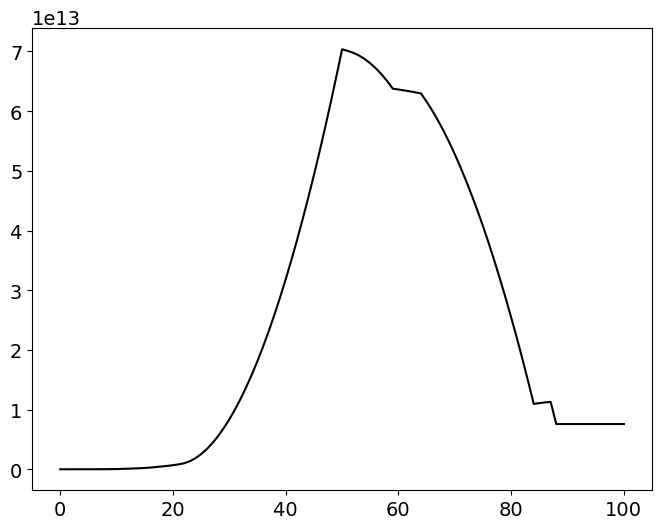

In [236]:
plt.plot(sim1.scenario['r_PERC'].dataOut_m['Effective_Capacity_[W]'])

In [237]:
#sim1.scenario['PV_ICE'].dataOut_m['irradiance_stc'].head(2)
sim1.scenario.keys()

dict_keys(['PV_ICE', 'r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA', 'ex_Life', 'ex_High_eff', 'ex_Circular', 'h_EffLife', 'h_50PERC', 'h_RecycledPERC', 'h_Perovskite_life', 'h_Perovskite_Eff'])

In [238]:
UnderInstall_df_temp = cc_yearly.filter(like='newInstalledCapacity_').subtract(global_projection[['World_annual_[MWdc]']].values)

In [239]:
#Attempt to make the deployment less dumb

UnderInstall_df_cumu = UnderInstall_df_temp.cumsum()

flatinstall = UnderInstall_df_cumu.iloc[-1,:]/(2100-2022)
flatinstall

newInstalledCapacity_sim1_PV_ICE_[MW]               1.342246e+06
newInstalledCapacity_sim1_r_PERC_[MW]               1.306151e+06
newInstalledCapacity_sim1_r_SHJ_[MW]                1.306151e+06
newInstalledCapacity_sim1_r_TOPCon_[MW]             1.306151e+06
newInstalledCapacity_sim1_r_IRENA_[MW]              2.299276e+06
newInstalledCapacity_sim1_ex_Life_[MW]              7.544019e+05
newInstalledCapacity_sim1_ex_High_eff_[MW]          2.263527e+06
newInstalledCapacity_sim1_ex_Circular_[MW]          4.044387e+06
newInstalledCapacity_sim1_h_EffLife_[MW]            1.326605e+06
newInstalledCapacity_sim1_h_50PERC_[MW]             8.527205e+05
newInstalledCapacity_sim1_h_RecycledPERC_[MW]       1.808050e+06
newInstalledCapacity_sim1_h_Perovskite_life_[MW]    2.384767e+06
newInstalledCapacity_sim1_h_Perovskite_Eff_[MW]     4.044387e+06
Name: 2100, dtype: float64

# RESULTS: Effective Capacity and Replacements

In [240]:
sim1.scenario['h_RecycledPERC'].dataOut_m['WeibullParams'].tail(4)

97     {'alpha': 11.337691281946588, 'beta': 39.02126...
98     {'alpha': 11.337691281946588, 'beta': 39.02126...
99     {'alpha': 11.337691281946588, 'beta': 39.02126...
100    {'alpha': 11.337691281946588, 'beta': 39.02126...
Name: WeibullParams, dtype: object

(0.0, 90.26425956655)

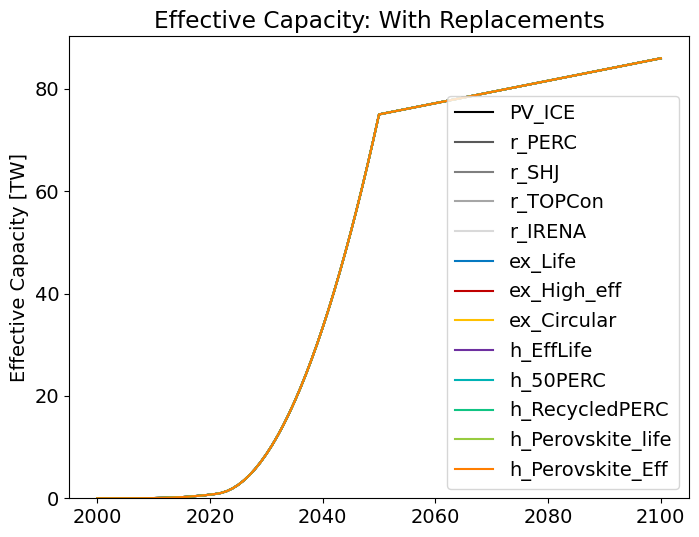

In [241]:
effective_capacity = cc_yearly.filter(like='ActiveCapacity')
plt.plot(effective_capacity/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: With Replacements')
plt.ylim(0,)

(0.0, 331.2353346288363)

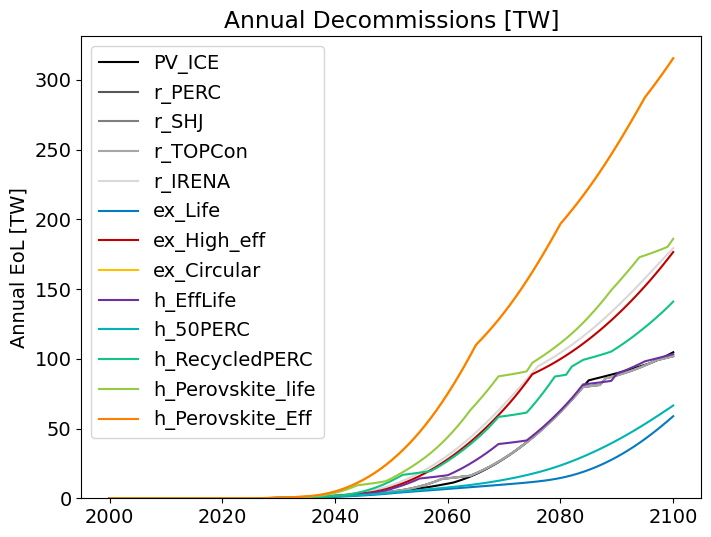

In [242]:
annual_EoL = cc_yearly.filter(like='DecommisionedCapacity')
plt.plot(annual_EoL/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Annual EoL [TW]')
plt.title('Annual Decommissions [TW]')
plt.ylim(0,)

(0.0, 8.641328493586279)

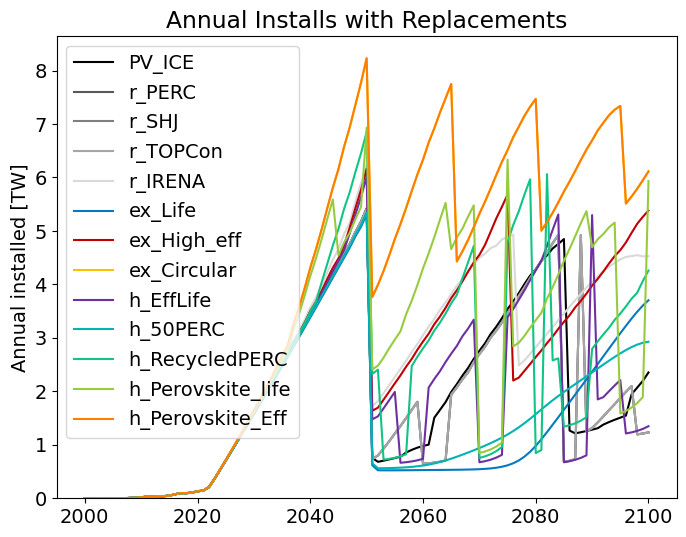

In [243]:
annual_installs = cc_yearly.filter(like='newInstalled')
plt.plot(annual_installs/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Annual installed [TW]')
plt.title('Annual Installs with Replacements')
plt.ylim(0,)

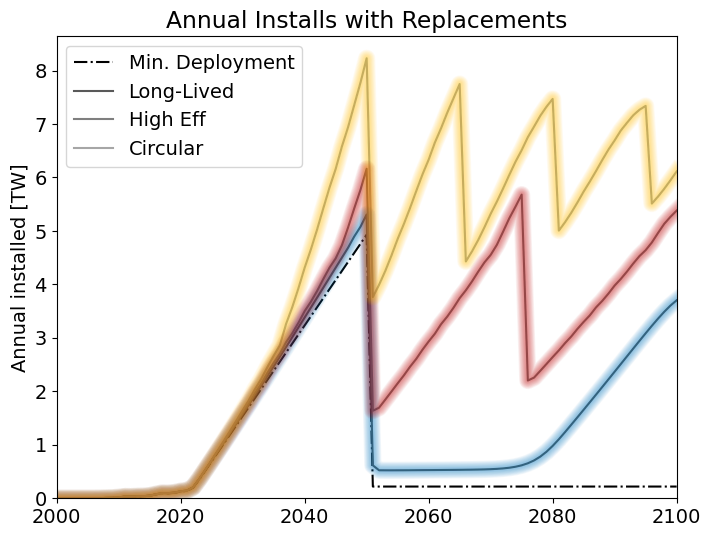

In [244]:
annual_installs_TW = cc_yearly.filter(like='newInstalled')/1e6

plt.plot(global_projection['World_annual_[MWdc]']/1e6, label='Min. Deployment', ls='dashdot')

#extremes
plt.plot(annual_installs_TW.iloc[:,5:8], label = scennames_labels_flat[5:8]) #, color=colorpalette[5:8])
#create glowlines for idealized scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    plt.plot(annual_installs_TW.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    plt.plot(annual_installs_TW.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    plt.plot(annual_installs_TW.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

plt.legend()
plt.ylabel('Annual installed [TW]')
plt.title('Annual Installs with Replacements')
plt.ylim(0,)
plt.xlim(2000,2100)

plt.savefig('energyresults-annualdeployment.png', dpi=300, bbox_inches='tight')

annual_installs_TW = cc_yearly.filter(like='newInstalled')/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})
ax1.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax1.set_prop_cycle(color=colorpalette[1:4])
ax1.plot(annual_installs_TW.iloc[:,1:4], label=scennames_labels_flat[1:4])# , color=colorpalette[1:4])
ax1.set_title('Idealized', fontsize=14)
ax1.set_ylabel('Annual installed [TW]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,8.5)
ax1.legend(bbox_to_anchor=(0.9,-0.05))

ax2.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[4:7])
ax2.plot(annual_installs_TW.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--') #, color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)
ax2.legend(bbox_to_anchor=(1,-0.05))

ax3.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[7:11])
ax3.plot(annual_installs_TW.iloc[:,7:11], label=scennames_labels_flat[7:11])# , color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)
ax3.legend(bbox_to_anchor=(0.9,-0.05))

fig.suptitle('Annual Installs with Replacements', fontsize=24)
plt.show()
fig.savefig('energyresults-annualInstalls.png', dpi=300, bbox_inches='tight')

#### Fixing Jagged Lines

In [245]:
posttransinstalls = annual_installs.loc[2051:,].cumsum()
flatinstallslate = posttransinstalls.loc[2100]/(2100-2050)
flatinstallslate

newInstalledCapacity_sim1_PV_ICE_[MW]               2.221055e+06
newInstalledCapacity_sim1_r_PERC_[MW]               2.159963e+06
newInstalledCapacity_sim1_r_SHJ_[MW]                2.159963e+06
newInstalledCapacity_sim1_r_TOPCon_[MW]             2.159963e+06
newInstalledCapacity_sim1_r_IRENA_[MW]              3.618366e+06
newInstalledCapacity_sim1_ex_Life_[MW]              1.324735e+06
newInstalledCapacity_sim1_ex_High_eff_[MW]          3.595318e+06
newInstalledCapacity_sim1_ex_Circular_[MW]          5.985499e+06
newInstalledCapacity_sim1_h_EffLife_[MW]            2.153959e+06
newInstalledCapacity_sim1_h_50PERC_[MW]             1.467607e+06
newInstalledCapacity_sim1_h_RecycledPERC_[MW]       2.789712e+06
newInstalledCapacity_sim1_h_Perovskite_life_[MW]    3.654927e+06
newInstalledCapacity_sim1_h_Perovskite_Eff_[MW]     5.985499e+06
Name: 2100, dtype: float64

In [246]:
annual_installs_modify = annual_installs.copy()
for col in annual_installs_modify:
    annual_installs_modify.loc[2051:,col] = flatinstallslate[col]

#annual_installs_modify
#plt.plot(annual_installs_modify)

#annual_installs_TW = cc_yearly.filter(like='newInstalled')
annual_installs_modify_TW = annual_installs_modify/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})
ax1.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax1.set_prop_cycle(color=colorpalette[1:4])
ax1.plot(annual_installs_TW.iloc[:,1:4], label=scennames_labels_flat[1:4])# , color=colorpalette[1:4])
ax1.plot(annual_installs_modify_TW.iloc[:,1:4], label=scennames_labels_flat[1:4])# , color=colorpalette[1:4])
ax1.set_title('Idealized', fontsize=14)
ax1.set_ylabel('Annual installed [TW]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,8.5)
ax1.legend(bbox_to_anchor=(0.9,-0.05))

ax2.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[4:7])
ax2.plot(annual_installs_TW.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--')
ax2.plot(annual_installs_modify_TW.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--') #, color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)
ax2.legend(bbox_to_anchor=(1,-0.05))

ax3.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[7:11])
ax3.plot(annual_installs_TW.iloc[:,7:11], label=scennames_labels_flat[7:11])
ax3.plot(annual_installs_modify_TW.iloc[:,7:11], label=scennames_labels_flat[7:11])# , color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)
ax3.legend(bbox_to_anchor=(0.9,-0.05))

fig.suptitle('Annual Installs with Replacements Averaged Post 2050', fontsize=24)
plt.show()
fig.savefig('energyresults-annualInstalls-AVG.png', dpi=300, bbox_inches='tight')

In [247]:
#decade binning of post 2050 installs by decade
posttransinstalls_annual = annual_installs.loc[2051:,]
posttransinstalls_decades = posttransinstalls_annual.groupby(np.arange(len(posttransinstalls_annual))//10).sum()
posttransinstalls_decades.index = ['2051-2060','2061-2070','2071-2080','2081-2090','2091-2100']
posttransinstalls_decades
#this is the sum each decade, still need to divide by 10 for annual

newInstalledCapacity_sim1_PV_ICE_[MW]  \
2051-2060                           8.084245e+06   
2061-2070                           2.017992e+07   
2071-2080                           3.606240e+07   
2081-2090                           2.952406e+07   
2091-2100                           1.720211e+07   

           newInstalledCapacity_sim1_r_PERC_[MW]  \
2051-2060                           1.169165e+07   
2061-2070                           1.655666e+07   
2071-2080                           3.546531e+07   
2081-2090                           2.832288e+07   
2091-2100                           1.596166e+07   

           newInstalledCapacity_sim1_r_SHJ_[MW]  \
2051-2060                          1.169165e+07   
2061-2070                          1.655666e+07   
2071-2080                          3.546531e+07   
2081-2090                          2.832288e+07   
2091-2100                          1.596166e+07   

           newInstalledCapacity_sim1_r_TOPCon_[MW]  \
2051-2060                             1.169165e+07   
2061-2070                             1.655666e+07   
2071-2080                             3.546531e+07   
2081-2090                             2.832288e+07   
2091-2100                             1.596166e+07   

           newInstalledCapacity_sim1_r_IRENA_[MW]  \
2051-2060                            2.354720e+07   
2061-2070                            3.876813e+07   
2071-2080                            3.924160e+07   
2081-2090                            3.511517e+07   
2091-2100                            4.424623e+07   

           newInstalledCapacity_sim1_ex_Life_[MW]  \
2051-2060                            5.336487e+06   
2061-2070                            5.341243e+06   
2071-2080                            6.876479e+06   
2081-2090                            1.730013e+07   
2091-2100                            3.138243e+07   

           newInstalledCapacity_sim1_ex_High_eff_[MW]  \
2051-2060                                2.239809e+07   
2061-2070                                3.818910e+07   
2071-2080                                3.808882e+07   
2081-2090                                3.365549e+07   
2091-2100                                4.743440e+07   

           newInstalledCapacity_sim1_ex_Circular_[MW]  \
2051-2060                                5.009420e+07   
2061-2070                                6.028416e+07   
2071-2080                                6.584287e+07   
2081-2090                                5.837160e+07   
2091-2100                                6.468215e+07   

           newInstalledCapacity_sim1_h_EffLife_[MW]  \
2051-2060                              1.199030e+07   
2061-2070                              2.500011e+07   
2071-2080                              2.585844e+07   
2081-2090                              2.843518e+07   
2091-2100                              1.641394e+07   

           newInstalledCapacity_sim1_h_50PERC_[MW]  \
2051-2060                             5.860625e+06   
2061-2070                             7.692541e+06   
2071-2080                             1.247427e+07   
2081-2090                             2.018488e+07   
2091-2100                             2.716805e+07   

           newInstalledCapacity_sim1_h_RecycledPERC_[MW]  \
2051-2060                                   1.648322e+07   
2061-2070                                   3.428366e+07   
2071-2080                                   3.121564e+07   
2081-2090                                   2.203251e+07   
2091-2100                                   3.547056e+07   

           newInstalledCapacity_sim1_h_Perovskite_life_[MW]  \
2051-2060                                      3.184281e+07   
2061-2070                                      4.637377e+07   
2071-2080                                      2.544112e+07   
2081-2090                                      4.455346e+07   
2091-2100                                      3.453517e+07   

           newInstalledCapacity_s

In [248]:
annual_installs_decademod = annual_installs.copy()
for col in annual_installs_decademod:
    annual_installs_decademod.loc[2051:2060,col] = posttransinstalls_decades.loc['2051-2060',col]/10
    annual_installs_decademod.loc[2061:2070,col] = posttransinstalls_decades.loc['2061-2070',col]/10
    annual_installs_decademod.loc[2071:2080,col] = posttransinstalls_decades.loc['2071-2080',col]/10
    annual_installs_decademod.loc[2081:2090,col] = posttransinstalls_decades.loc['2081-2090',col]/10
    annual_installs_decademod.loc[2091:2100,col] = posttransinstalls_decades.loc['2091-2100',col]/10
    
#plt.plot(annual_installs_decademod)

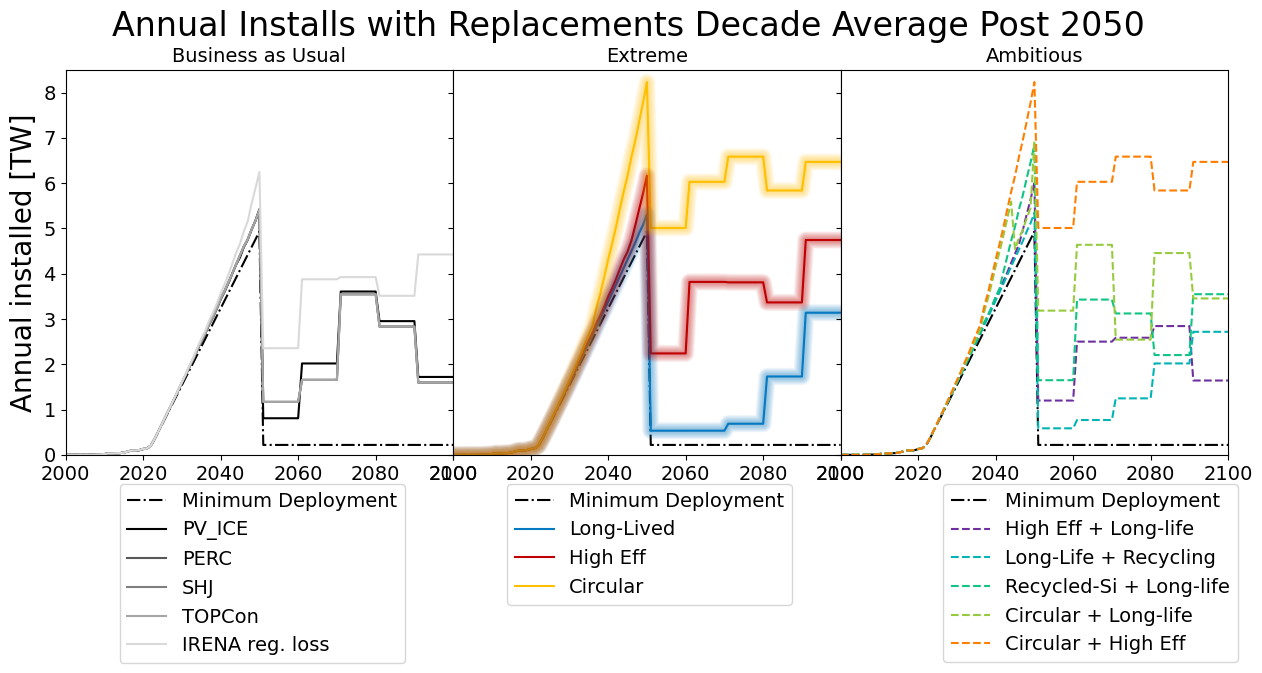

In [249]:
#annual_installs_TW = cc_yearly.filter(like='newInstalled')
annual_installs_decademod_TW = annual_installs_decademod/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})
ax1.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')

#BAU
ax1.set_prop_cycle(color=colorpalette[0:5])
ax1.plot(annual_installs_decademod_TW.iloc[:,0:5], label=scennames_labels_flat[0:5]) # baselines
ax1.set_title('Business as Usual', fontsize=14)
ax1.set_ylabel('Annual installed [TW]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,8.5)
ax1.legend(bbox_to_anchor=(0.9,-0.05))


#Extreme
ax2.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[5:8])
#ax2.plot(annual_installs_TW.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--')
ax2.plot(annual_installs_decademod_TW.iloc[:,5:8], label=scennames_labels_flat[5:8]) #, color=colorpalette[4:7])

#create glowlines for Extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax2.plot(annual_installs_decademod_TW.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    ax2.plot(annual_installs_decademod_TW.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    ax2.plot(annual_installs_decademod_TW.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

ax2.set_title('Extreme', fontsize=14)
ax2.legend(bbox_to_anchor=(0.9,-0.05))

#Ambitious
ax3.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[8:])
ax3.plot(annual_installs_decademod_TW.iloc[:,8:], label=scennames_labels_flat[8:], ls='--')# 
ax3.set_title('Ambitious', fontsize=14)
ax3.legend(bbox_to_anchor=(1.05,-0.05)) #(x,y)

#overall figure
fig.suptitle('Annual Installs with Replacements Decade Average Post 2050', fontsize=24, y=1)
plt.show()
fig.savefig('energyresults-annualInstalls-decade.png', dpi=300, bbox_inches='tight')

(0.0, 421.49959419538624)

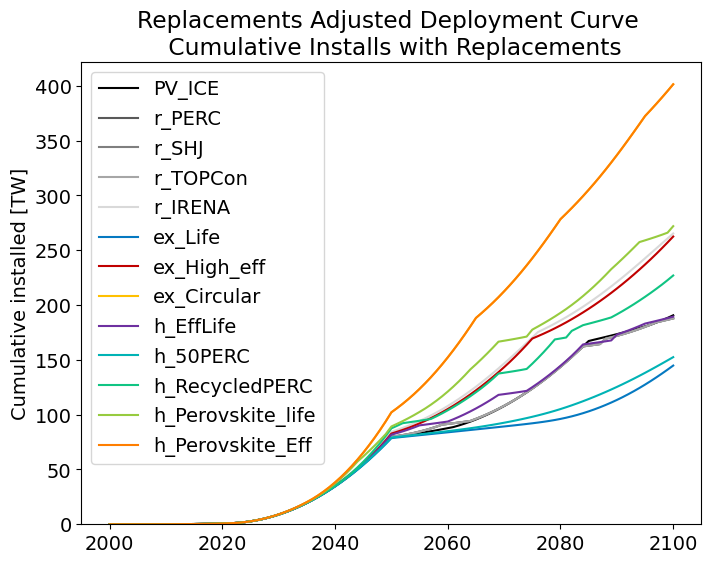

In [250]:
cumu_installs_annually = cc_cumu.filter(like='newInstalled')
plt.plot(cumu_installs_annually/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Cumulative installed [TW]')
plt.title('Replacements Adjusted Deployment Curve \n Cumulative Installs with Replacements')
plt.ylim(0,)

(0.0, 410.0)

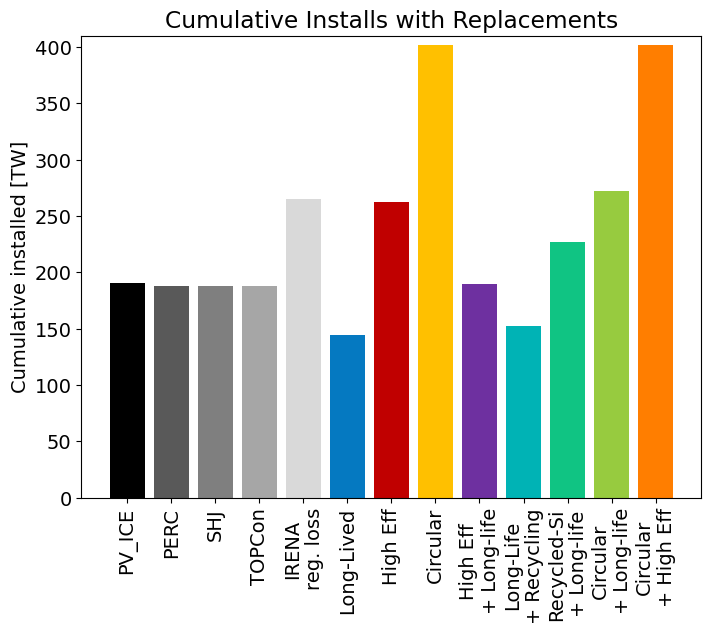

In [251]:
cumu_installs = cc_cumu.filter(like='newInstalled')
plt.bar(scennames_labels, cumu_installs.loc[2100]/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.xticks(rotation=90)
plt.ylabel('Cumulative installed [TW]')
plt.title('Cumulative Installs with Replacements')
plt.ylim(0,410)

In [252]:
replacements = cumu_installs.iloc[-1,]/1e6
replacements.index = scennames_labels_flat

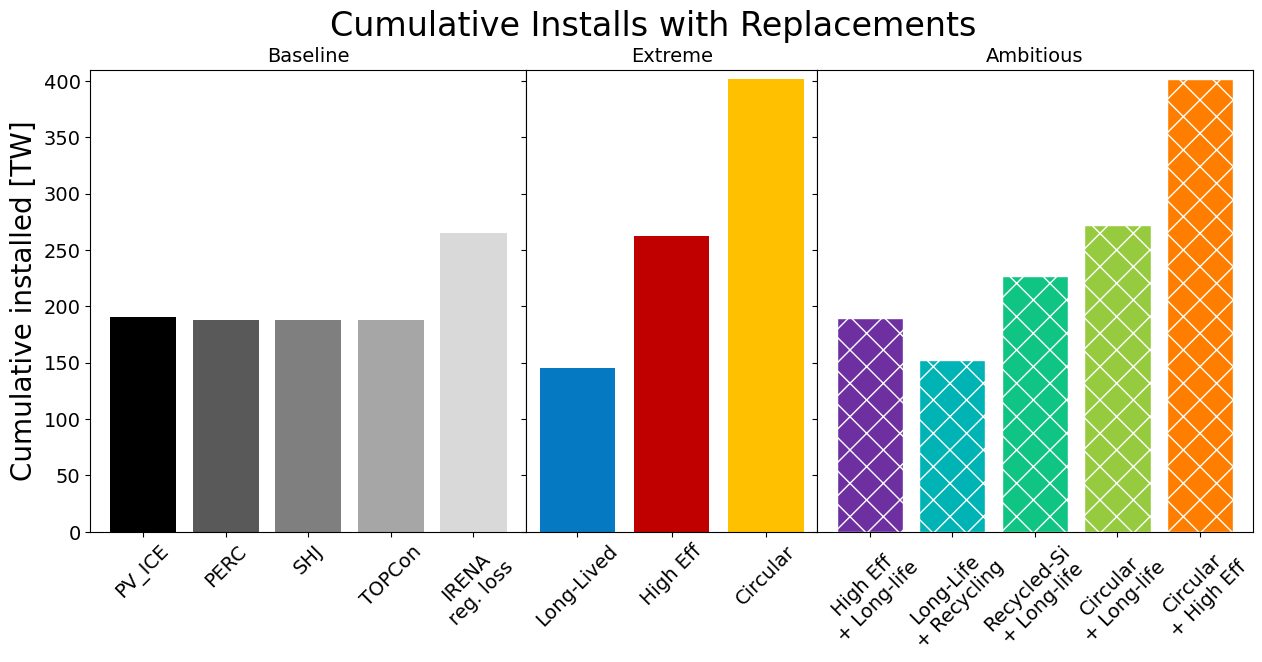

In [253]:
cumu_installs = cc_cumu.filter(like='newInstalled')

fig, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], cumu_installs.iloc[-1,0:5]/1e6,# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
ax0.set_ylim(0,410)
ax0.set_ylabel('Cumulative installed [TW]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)

#Extreme
ax2.bar(scennames_labels[5:8], cumu_installs.iloc[-1,5:8]/1e6, #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)

#Ambitious
ax3.bar(scennames_labels[8:], cumu_installs.iloc[-1,8:]/1e6, #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)

#overall fig
fig.suptitle('Cumulative Installs with Replacements', fontsize=24)

plt.show()

fig.savefig('energyresults-cumulativedeploy.png', dpi=300, bbox_inches='tight')

cumu_installs = cc_cumu.filter(like='newInstalled')

fig = plt.subplots(figsize =(12, 8))

x = np.arange(len(scennames_labels))  # the label locations

plt.bar(x[0:4]-1, cumu_installs.iloc[-1,0:4]/1e6, tick_label=scennames_labels[0:4], color=colorpalette[0:4])

plt.bar(x[4:7], cumu_installs.iloc[-1,4:7]/1e6, tick_label=scennames_labels[4:7], color=colorpalette[4:7])

plt.bar(x[7:11]+1, cumu_installs.iloc[-1,7:11]/1e6, tick_label=scennames_labels[7:11], color=colorpalette[7:11])

plt.ylim(0,410)
plt.ylabel('Cumulative installed [TW]')
plt.title('Cumulative Installs with Replacements')
plt.xticks(rotation=90)

plt.show()

In [254]:
cumulative_nameplate_installs = global_projection.loc[2100,'World_cum'] #MW
print('The nameplate installations for energy transition and through 2100 are '+str(cumulative_nameplate_installs/1e6)+' TW.')

The nameplate installations for energy transition and through 2100 are 85.966 TW.


In [255]:
global_projection['World_annual_[MWdc]'].sum()

85966000.0

(0.0, 410.0)

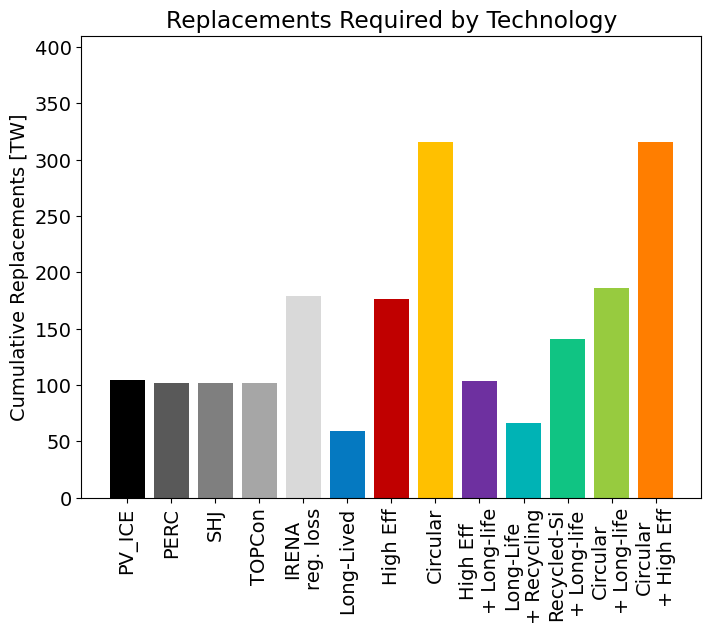

In [256]:
Additional_installs = cumu_installs.loc[2100]-global_projection.loc[2100,'World_cum']
plt.bar(scennames_labels, Additional_installs/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.ylabel('Cumulative Replacements [TW]')
plt.title('Replacements Required by Technology')
plt.xticks(rotation=90)
plt.ylim(0,410)

# RESULTS: Virgin Material Demands

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'PERC'),
  Text(2.0, 0, 'SHJ'),
  Text(3.0, 0, 'TOPCon'),
  Text(4.0, 0, 'IRENA\nreg. loss'),
  Text(5.0, 0, 'Long-Lived'),
  Text(6.0, 0, 'High Eff'),
  Text(7.0, 0, 'Circular'),
  Text(8.0, 0, 'High Eff\n+ Long-life'),
  Text(9.0, 0, 'Long-Life\n+ Recycling'),
  Text(10.0, 0, 'Recycled-Si\n+ Long-life'),
  Text(11.0, 0, 'Circular\n+ Long-life'),
  Text(12.0, 0, 'Circular\n+ High Eff')])

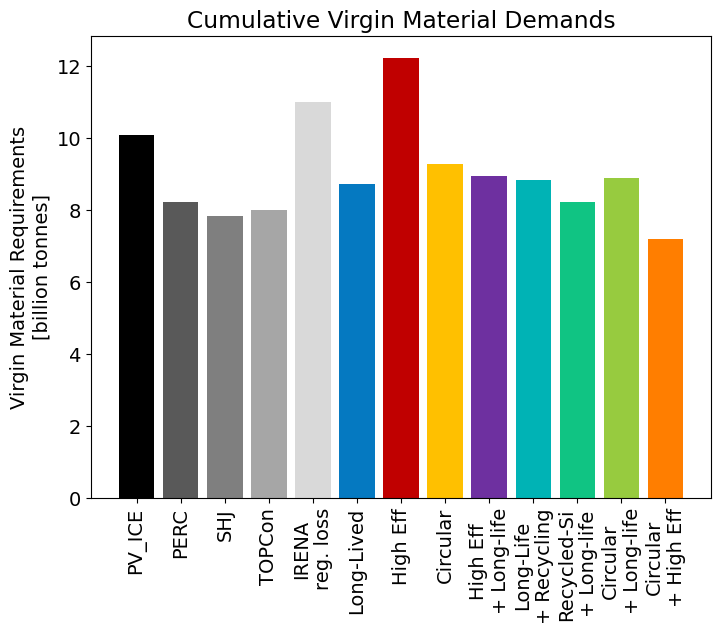

In [257]:
cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.bar(scennames_labels, cumu_virgin_module.loc[2100]/1e9, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Virgin Material Demands')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')
plt.xticks(rotation=90)

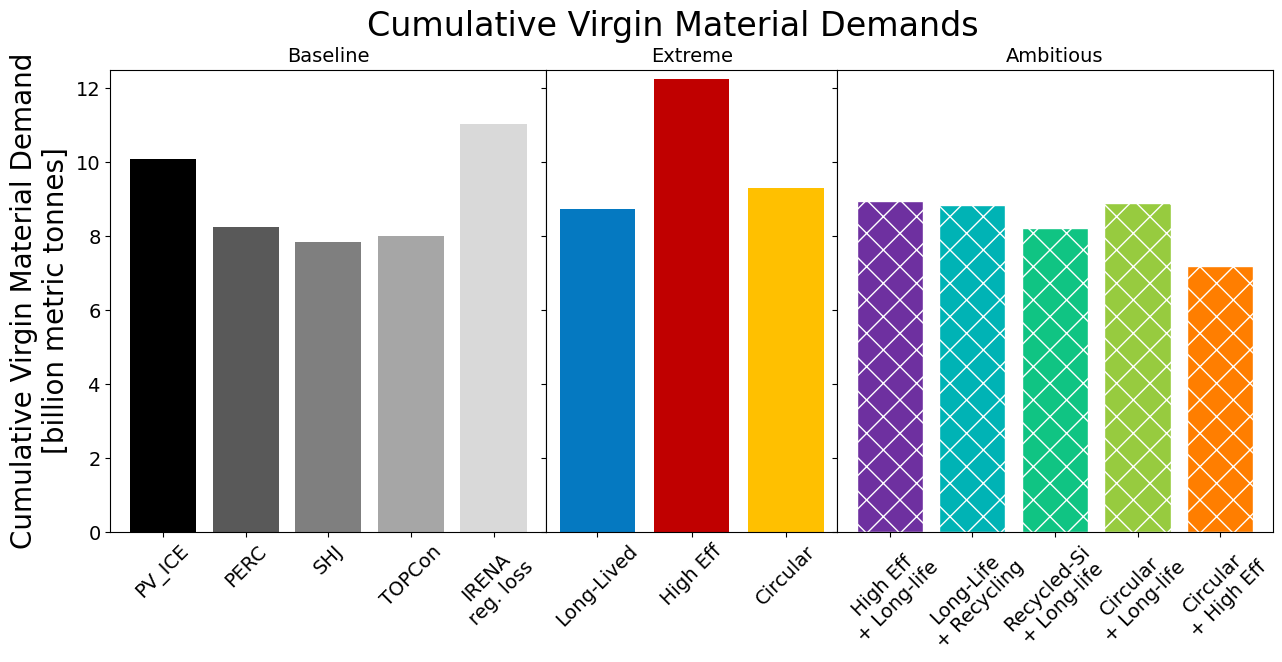

In [258]:
cumu_virgin_module_bt = cc_cumu.filter(like='VirginStock_Module')/1e9

fig, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], cumu_virgin_module_bt.iloc[-1,0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
ax0.set_ylim(0,12.5)
ax0.set_ylabel('Cumulative Virgin Material Demand\n[billion metric tonnes]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)

#Extreme
ax2.bar(scennames_labels[5:8], cumu_virgin_module_bt.iloc[-1,5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)

#Ambitious
ax3.bar(scennames_labels[8:], cumu_virgin_module_bt.iloc[-1,8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)

#overall fig
fig.suptitle('Cumulative Virgin Material Demands', fontsize=24)
plt.show()

fig.savefig('energyresults-cumuMatDemand.png', dpi=300, bbox_inches='tight')

cumu_virgin_module_bt = cc_cumu.filter(like='VirginStock_Module')/1e9

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(18,7), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [0.5,2,2,2.5]})

ax0.bar(scennames_labels[0:1], cumu_virgin_module_bt.iloc[-1,0:1], width=0.1, 
        tick_label=scennames_labels[0:1], color=colorpalette[0:1])
ax0.set_ylim(0,12)
ax0.set_ylabel('Virgin Material Requirements\n[billion tonnes]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)

ax1.bar(scennames_labels[1:4], cumu_virgin_module_bt.iloc[-1,1:4], width=0.8, 
        tick_label=scennames_labels[1:4], color=colorpalette[1:4])
ax1.set_title('Idealized', fontsize=14)

ax2.bar(scennames_labels[4:7], cumu_virgin_module_bt.iloc[-1,4:7], width=0.8,
        tick_label=scennames_labels[4:7], color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)

ax3.bar(scennames_labels[7:11], cumu_virgin_module_bt.iloc[-1,7:11], width=0.8,
        tick_label=scennames_labels[7:11], color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)

fig.suptitle('Cumulative Virgin Material Demands', fontsize=24)
plt.show()

fig.savefig('energyresults-cumuMatDemand.png', dpi=300, bbox_inches='tight')

In [259]:
virgin = cumu_virgin_module_bt.iloc[-1,:]
virgin.index=scennames_labels_flat

Text(0, 0.5, 'Million Metric tonnes')

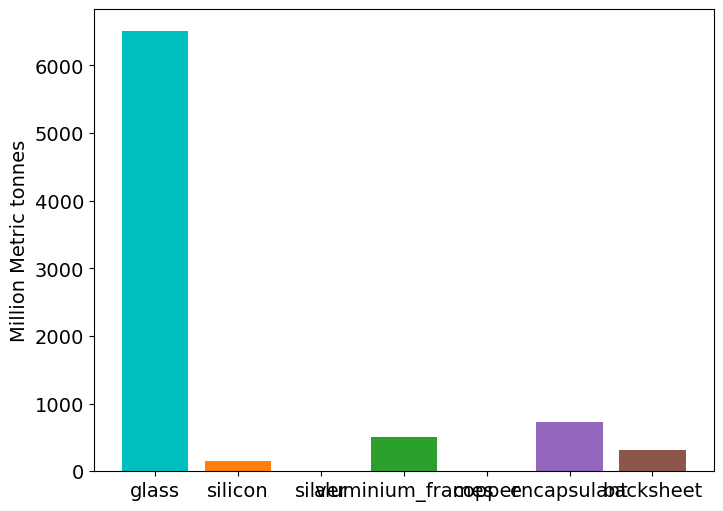

In [260]:
recycledperc_virginstock = cc_cumu.filter(like='VirginStock').filter(like='Recycled')
recycledperc_virginstock.drop('VirginStock_Module_sim1_h_RecycledPERC_[Tonnes]',axis=1, inplace=True)
plt.bar(recycledperc_virginstock.columns, recycledperc_virginstock.loc[2100]/1e6, tick_label = MATERIALS, color=colormats)
plt.ylabel('Million Metric tonnes')

(0.0, 12.844575320227912)

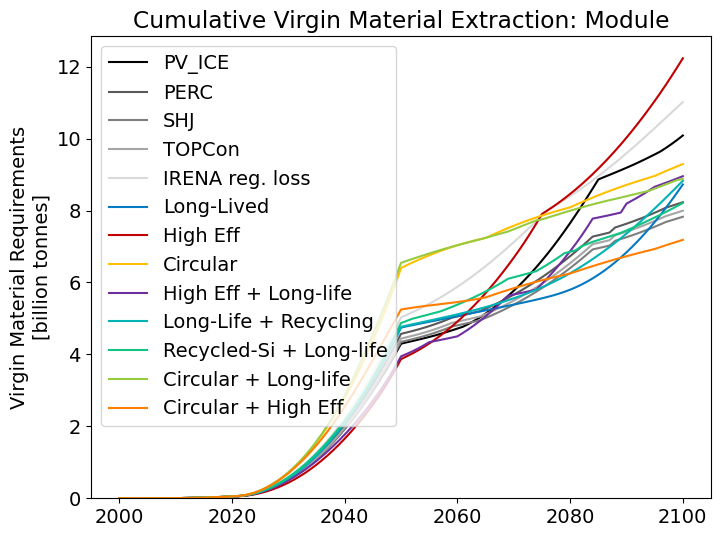

In [261]:
cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.plot(cumu_virgin_module/1e9)
plt.legend(scennames_labels_flat)
plt.title('Cumulative Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')
plt.ylim(0,)

(0.0, 457.55219335401915)

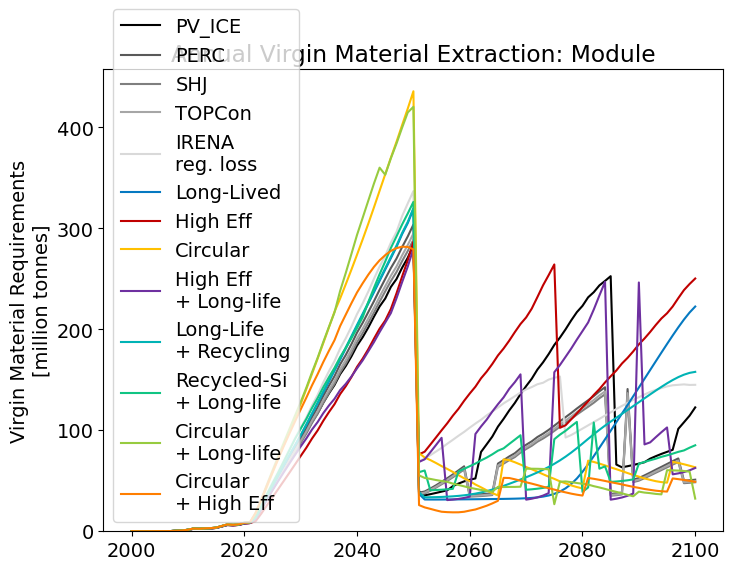

In [262]:
annual_virgin_module = cc_yearly.filter(like='VirginStock_Module')
plt.plot(annual_virgin_module/1e6)
plt.legend(scennames_labels)
plt.title('Annual Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[million tonnes]')
plt.ylim(0,)

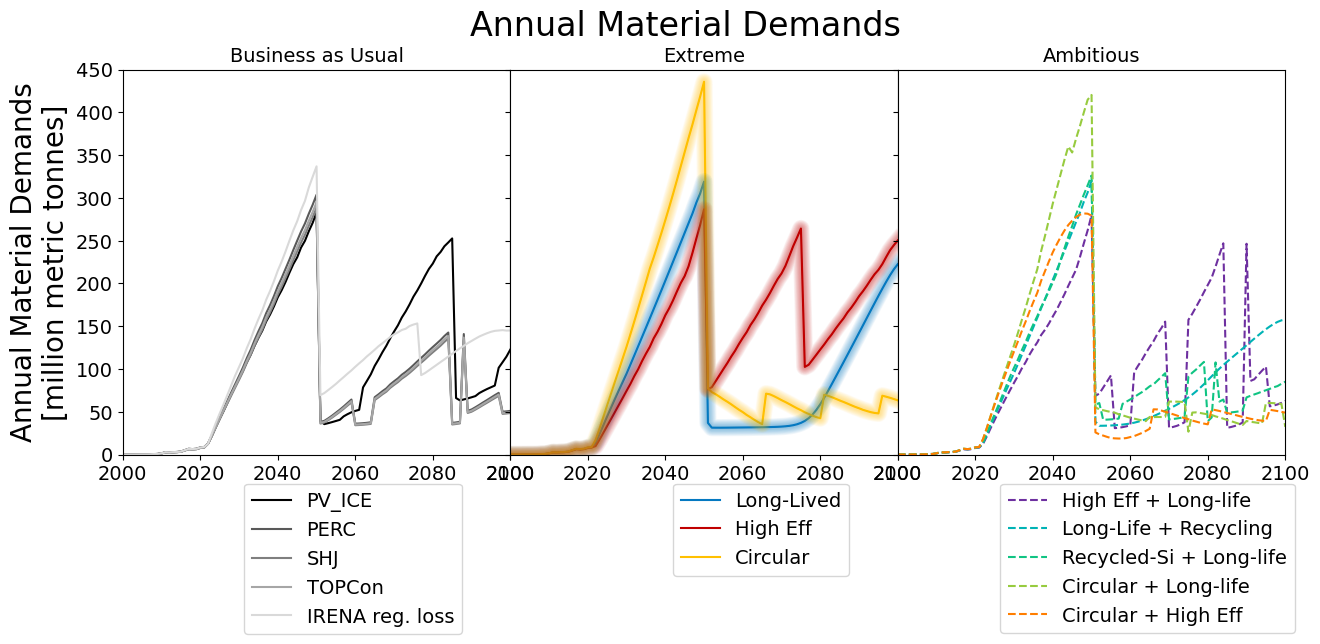

In [263]:
annual_virgin_module_mt = annual_virgin_module/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})

#BAU
ax1.set_prop_cycle(color=colorpalette[0:5])
ax1.plot(annual_virgin_module_mt.iloc[:,0:5], label=scennames_labels_flat[0:5]) # baselines
ax1.set_title('Business as Usual', fontsize=14)
ax1.set_ylabel('Annual Material Demands\n[million metric tonnes]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,8.5)
ax1.legend(bbox_to_anchor=(0.9,-0.05))
ax1.set_ylim(0,450)


#Extreme
ax2.set_prop_cycle(color=colorpalette[5:8])

ax2.plot(annual_virgin_module_mt.iloc[:,5:8], label=scennames_labels_flat[5:8])

#create glowlines for Extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax2.plot(annual_virgin_module_mt.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    ax2.plot(annual_virgin_module_mt.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    ax2.plot(annual_virgin_module_mt.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

ax2.set_title('Extreme', fontsize=14)
ax2.legend(bbox_to_anchor=(0.9,-0.05))

#Ambitious
ax3.set_prop_cycle(color=colorpalette[8:])
ax3.plot(annual_virgin_module_mt.iloc[:,8:], label=scennames_labels_flat[8:], ls='--')# 
ax3.set_title('Ambitious', fontsize=14)
ax3.legend(bbox_to_anchor=(1.05,-0.05)) #(x,y)

#overall figure
fig.suptitle('Annual Material Demands', fontsize=24, y=1)
plt.show()
fig.savefig('energyresults-annualMatDemands.png', dpi=300, bbox_inches='tight')

annual_virgin_module_mt = annual_virgin_module/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})
#ax1.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax1.set_prop_cycle(color=colorpalette[1:4])
ax1.plot(annual_virgin_module_mt.iloc[:,1:4], label=scennames_labels_flat[1:4])# , color=colorpalette[1:4])

#create glowlines for idealized scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax1.plot(annual_virgin_module_mt.iloc[:,1],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[1])

for n in range(1, n_lines+1):    
    ax1.plot(annual_virgin_module_mt.iloc[:,2],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[2])

for n in range(1, n_lines+1):    
    ax1.plot(annual_virgin_module_mt.iloc[:,3],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[3])

ax1.set_title('Idealized', fontsize=14)
ax1.set_ylabel('Annual Material Demands\n[million metric tonnes]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,350)
ax1.legend(bbox_to_anchor=(0.9,-0.05))

#ax2.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[4:7])
ax2.plot(annual_virgin_module_mt.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--') #, color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)
ax2.legend(bbox_to_anchor=(1,-0.05))

#ax3.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[7:11])
ax3.plot(annual_virgin_module_mt.iloc[:,7:11], label=scennames_labels_flat[7:11])# , color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)
ax3.legend(bbox_to_anchor=(0.9,-0.05))

fig.suptitle('Annual Material Demands', fontsize=24)
plt.show()
fig.savefig('energyresults-annualMatDemands.png', dpi=300, bbox_inches='tight')

In [264]:
#do it by decade to match up with annual installs graphs
virgin_module_annual = annual_virgin_module.loc[2051:,]
virgin_module_decades = virgin_module_annual.groupby(np.arange(len(virgin_module_annual))//10).sum()
virgin_module_decades.index = ['2051-2060','2061-2070','2071-2080','2081-2090','2091-2100']
virgin_module_decades
#this is the sum each decade, still need to divide by 10 for annual

VirginStock_Module_sim1_PV_ICE_[Tonnes]  \
2051-2060                             4.220275e+08   
2061-2070                             1.052121e+09   
2071-2080                             1.879663e+09   
2081-2090                             1.539121e+09   
2091-2100                             8.971855e+08   

           VirginStock_Module_sim1_r_PERC_[Tonnes]  \
2051-2060                             4.839217e+08   
2061-2070                             6.044584e+08   
2071-2080                             1.070382e+09   
2081-2090                             9.026543e+08   
2091-2100                             5.981208e+08   

           VirginStock_Module_sim1_r_SHJ_[Tonnes]  \
2051-2060                            4.598654e+08   
2061-2070                            5.746617e+08   
2071-2080                            1.017617e+09   
2081-2090                            8.581590e+08   
2091-2100                            5.686381e+08   

           VirginStock_Module_sim1_r_TOPCon_[Tonnes]  \
2051-2060                               4.696806e+08   
2061-2070                               5.869387e+08   
2071-2080                               1.039357e+09   
2081-2090                               8.764917e+08   
2091-2100                               5.807857e+08   

           VirginStock_Module_sim1_r_IRENA_[Tonnes]  \
2051-2060                              8.512090e+08   
2061-2070                              1.241424e+09   
2071-2080                              1.279354e+09   
2081-2090                              1.192064e+09   
2091-2100                              1.423912e+09   

           VirginStock_Module_sim1_ex_Life_[Tonnes]  \
2051-2060                              3.207430e+08   
2061-2070                              3.210288e+08   
2071-2080                              4.133023e+08   
2081-2090                              1.039803e+09   
2091-2100                              1.886202e+09   

           VirginStock_Module_sim1_ex_High_eff_[Tonnes]  \
2051-2060                                  1.042054e+09   
2061-2070                                  1.776717e+09   
2071-2080                                  1.772052e+09   
2081-2090                                  1.565795e+09   
2091-2100                                  2.206848e+09   

           VirginStock_Module_sim1_ex_Circular_[Tonnes]  \
2051-2060                                  6.313944e+08   
2061-2070                                  5.434961e+08   
2071-2080                                  5.114741e+08   
2081-2090                                  6.228530e+08   
2091-2100                                  5.808271e+08   

           VirginStock_Module_sim1_h_EffLife_[Tonnes]  \
2051-2060                                5.578394e+08   
2061-2070                                1.163110e+09   
2071-2080                                1.203043e+09   
2081-2090                                1.322924e+09   
2091-2100                                7.636454e+08   

           VirginStock_Module_sim1_h_50PERC_[Tonnes]  \
2051-2060                               3.496524e+08   
2061-2070                               4.456898e+08   
2071-2080                               6.967530e+08   
2081-2090                               1.101962e+09   
2091-2100                               1.468387e+09   

           VirginStock_Module_sim1_h_RecycledPERC_[Tonnes]  \
2051-2060                                     5.105496e+08   
2061-2070                                     7.617865e+08   
2071-2080                                     7.084091e+08   
2081-2090                                     5.941487e+08   
2091-2100                                     7.633263e+08   

           VirginStock_Module_sim1_h_Perovskite_life_[Tonnes]  \
2051-2060                                       4.902461e+08    
2061-2070                                       4.438205e+08    
2071-2080                                       5.156364e+08    
2081-2090           

In [265]:
annual_virgin_module_decademod = annual_virgin_module.copy()
for col in annual_virgin_module_decademod:
    annual_virgin_module_decademod.loc[2051:2060,col] = virgin_module_decades.loc['2051-2060',col]/10
    annual_virgin_module_decademod.loc[2061:2070,col] = virgin_module_decades.loc['2061-2070',col]/10
    annual_virgin_module_decademod.loc[2071:2080,col] = virgin_module_decades.loc['2071-2080',col]/10
    annual_virgin_module_decademod.loc[2081:2090,col] = virgin_module_decades.loc['2081-2090',col]/10
    annual_virgin_module_decademod.loc[2091:2100,col] = virgin_module_decades.loc['2091-2100',col]/10
    
#plt.plot(annual_virgin_module_decademod)

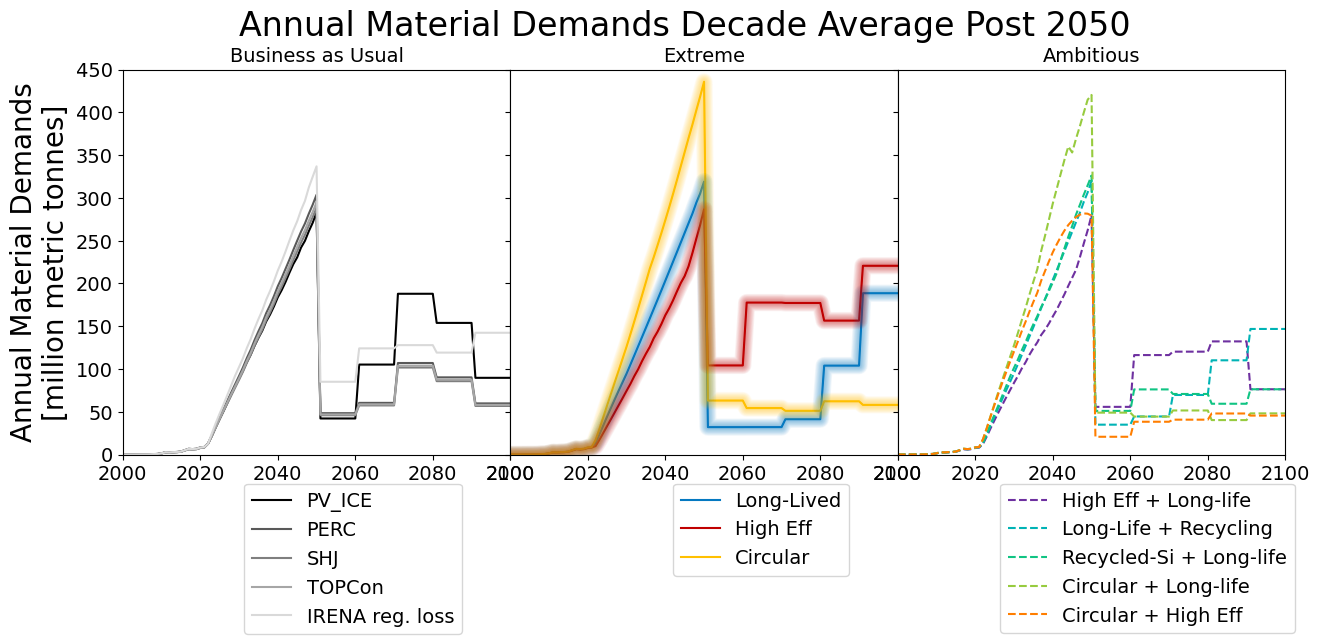

In [266]:
annual_virgin_module_decademod_mt = annual_virgin_module_decademod/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})

#BAU
ax1.set_prop_cycle(color=colorpalette[0:5])
ax1.plot(annual_virgin_module_decademod_mt.iloc[:,0:5], label=scennames_labels_flat[0:5]) # baselines
ax1.set_title('Business as Usual', fontsize=14)
ax1.set_ylabel('Annual Material Demands\n[million metric tonnes]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,8.5)
ax1.legend(bbox_to_anchor=(0.9,-0.05))
ax1.set_ylim(0,450)


#Extreme
ax2.set_prop_cycle(color=colorpalette[5:8])

ax2.plot(annual_virgin_module_decademod_mt.iloc[:,5:8], label=scennames_labels_flat[5:8])

#create glowlines for Extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax2.plot(annual_virgin_module_decademod_mt.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    ax2.plot(annual_virgin_module_decademod_mt.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    ax2.plot(annual_virgin_module_decademod_mt.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

ax2.set_title('Extreme', fontsize=14)
ax2.legend(bbox_to_anchor=(0.9,-0.05))

#Ambitious
ax3.set_prop_cycle(color=colorpalette[8:])
ax3.plot(annual_virgin_module_decademod_mt.iloc[:,8:], label=scennames_labels_flat[8:], ls='--')# 
ax3.set_title('Ambitious', fontsize=14)
ax3.legend(bbox_to_anchor=(1.05,-0.05)) #(x,y)

#overall figure

fig.suptitle('Annual Material Demands Decade Average Post 2050', fontsize=24, y=1)
plt.show()
fig.savefig('energyresults-annualMatDemands-decade.png', dpi=300, bbox_inches='tight')

In [267]:
#print out masses for stacked bar charts
#mass_cumu = cc_cumu.loc[[2100]].filter(like='PV_ICE_[Tonnes]')
mass_cumu_virgin = cc_cumu.filter(like='VirginStock').loc[2100]
mass_cumu_wasteall = cc_cumu.filter(like='WasteAll').loc[2100]
mass_cumu = pd.concat([mass_cumu_virgin,mass_cumu_wasteall])
mass_cumu.to_csv(os.path.join(testfolder, 'cc_cumu_mass_2100results.csv'))

In [268]:
cc_cumu.to_csv(os.path.join(testfolder, 'cc_cumu_mass_results.csv'))

# RESULTS: Lifecycle Wastes

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'PERC'),
  Text(2.0, 0, 'SHJ'),
  Text(3.0, 0, 'TOPCon'),
  Text(4.0, 0, 'IRENA\nreg. loss'),
  Text(5.0, 0, 'Long-Lived'),
  Text(6.0, 0, 'High Eff'),
  Text(7.0, 0, 'Circular'),
  Text(8.0, 0, 'High Eff\n+ Long-life'),
  Text(9.0, 0, 'Long-Life\n+ Recycling'),
  Text(10.0, 0, 'Recycled-Si\n+ Long-life'),
  Text(11.0, 0, 'Circular\n+ Long-life'),
  Text(12.0, 0, 'Circular\n+ High Eff')])

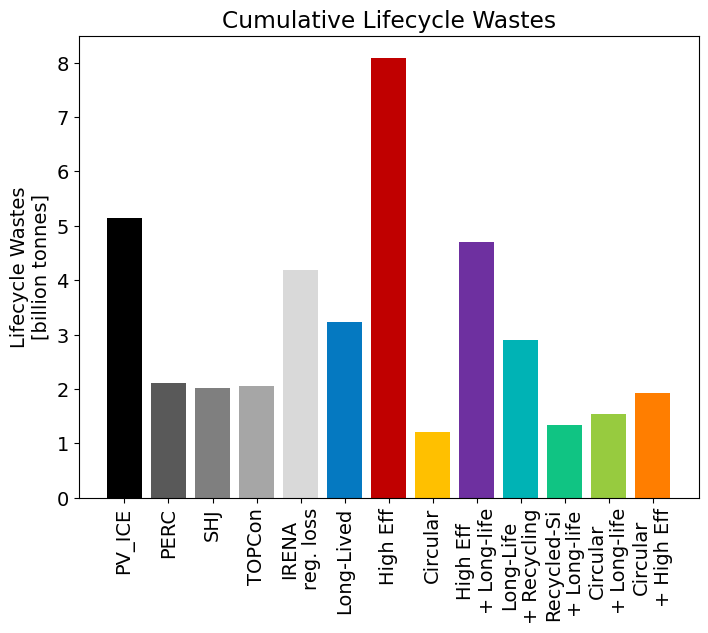

In [269]:
cumu_lifecycle_wastes = cc_cumu.filter(like='WasteAll_Module')

plt.bar(scennames_labels, cumu_lifecycle_wastes.loc[2100]/1e9, 
        tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Lifecycle Wastes')
plt.ylabel('Lifecycle Wastes\n[billion tonnes]')
plt.xticks(rotation=90)

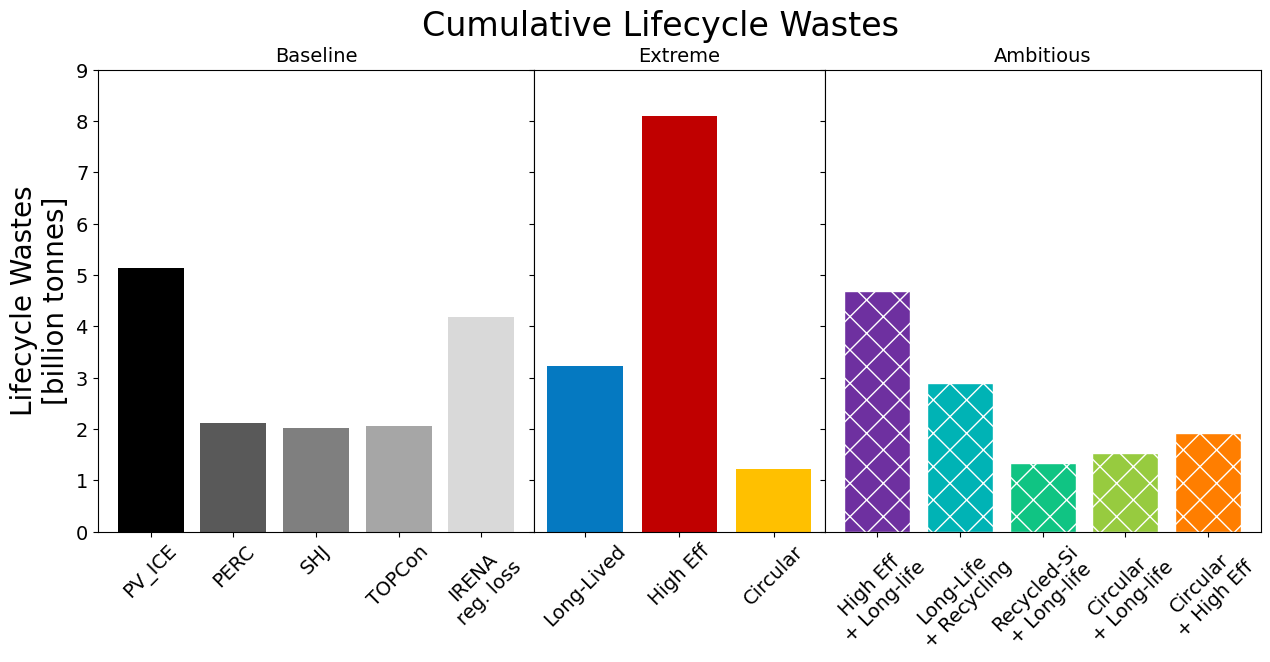

In [270]:
cumu_lifecycle_wastes_bt = cc_cumu.filter(like='WasteAll_Module')/1e9

fig, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], cumu_lifecycle_wastes_bt.iloc[-1,0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
ax0.set_ylim(0,9)
ax0.set_ylabel('Lifecycle Wastes\n[billion tonnes]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)

#Extreme
ax2.bar(scennames_labels[5:8], cumu_lifecycle_wastes_bt.iloc[-1,5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)

#Ambitious
ax3.bar(scennames_labels[8:], cumu_lifecycle_wastes_bt.iloc[-1,8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)

#overall fig

fig.suptitle('Cumulative Lifecycle Wastes', fontsize=24)
plt.show()

fig.savefig('energyresults-cumuWaste.png', dpi=300, bbox_inches='tight')

In [271]:
wastes = cumu_lifecycle_wastes_bt.iloc[-1,:]
wastes.index=scennames_labels_flat

(0.0, 285.9915502001703)

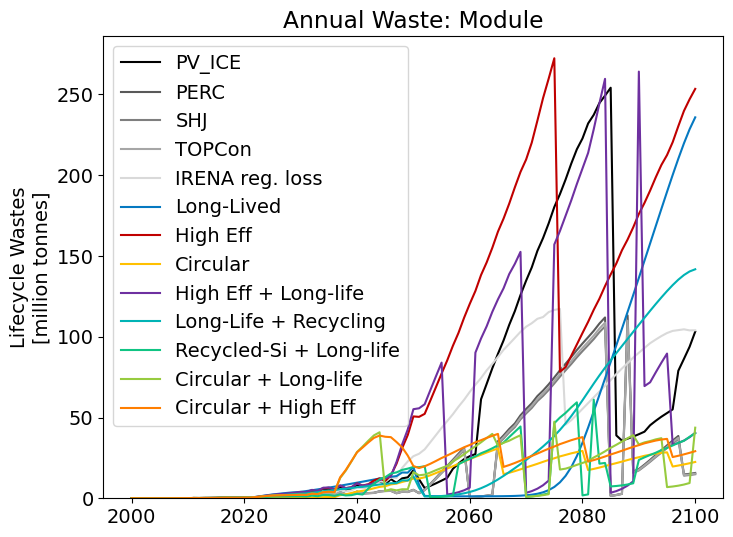

In [272]:
annual_waste_module = cc_yearly.filter(like='WasteAll_Module')
plt.plot(annual_waste_module/1e6)
plt.legend(scennames_labels_flat)
plt.title('Annual Waste: Module')
plt.ylabel('Lifecycle Wastes\n[million tonnes]')
plt.ylim(0,)

In [273]:
#do it by decade to match up with annual installs graphs
waste_module_annual = annual_waste_module.loc[2051:,]
waste_module_decades = waste_module_annual.groupby(np.arange(len(waste_module_annual))//10).sum()
waste_module_decades.index = ['2051-2060','2061-2070','2071-2080','2081-2090','2091-2100']
waste_module_decades
#this is the sum each decade, still need to divide by 10 for annual

WasteAll_Module_sim1_PV_ICE_[Tonnes]  \
2051-2060                          1.486041e+08   
2061-2070                          9.108933e+08   
2071-2080                          1.839154e+09   
2081-2090                          1.406897e+09   
2091-2100                          6.548639e+08   

           WasteAll_Module_sim1_r_PERC_[Tonnes]  \
2051-2060                          1.496898e+08   
2061-2070                          2.760397e+08   
2071-2080                          7.715851e+08   
2081-2090                          5.777744e+08   
2091-2100                          2.537908e+08   

           WasteAll_Module_sim1_r_SHJ_[Tonnes]  \
2051-2060                         1.424772e+08   
2061-2070                         2.624269e+08   
2071-2080                         7.335338e+08   
2081-2090                         5.492802e+08   
2091-2100                         2.412744e+08   

           WasteAll_Module_sim1_r_TOPCon_[Tonnes]  \
2051-2060                            1.455268e+08   
2061-2070                            2.680331e+08   
2071-2080                            7.492048e+08   
2081-2090                            5.610153e+08   
2091-2100                            2.464292e+08   

           WasteAll_Module_sim1_r_IRENA_[Tonnes]  \
2051-2060                           4.585761e+08   
2061-2070                           8.905605e+08   
2071-2080                           8.818120e+08   
2081-2090                           7.483706e+08   
2091-2100                           1.010307e+09   

           WasteAll_Module_sim1_ex_Life_[Tonnes]  \
2051-2060                           1.970140e+07   
2061-2070                           1.377886e+07   
2071-2080                           1.242771e+08   
2081-2090                           8.974020e+08   
2091-2100                           1.936591e+09   

           WasteAll_Module_sim1_ex_High_eff_[Tonnes]  \
2051-2060                               8.233814e+08   
2061-2070                               1.692441e+09   
2071-2080                               1.678985e+09   
2081-2090                               1.422095e+09   
2091-2100                               2.181818e+09   

           WasteAll_Module_sim1_ex_Circular_[Tonnes]  \
2051-2060                               1.786120e+08   
2061-2070                               2.258881e+08   
2071-2080                               2.510558e+08   
2081-2090                               2.136201e+08   
2091-2100                               2.424898e+08   

           WasteAll_Module_sim1_h_EffLife_[Tonnes]  \
2051-2060                             3.607965e+08   
2061-2070                             1.103942e+09   
2071-2080                             1.109874e+09   
2081-2090                             1.242594e+09   
2091-2100                             5.741769e+08   

           WasteAll_Module_sim1_h_50PERC_[Tonnes]  \
2051-2060                            2.447396e+07   
2061-2070                            1.338564e+08   
2071-2080                            4.171952e+08   
2081-2090                            8.723540e+08   
2091-2100                            1.288337e+09   

           WasteAll_Module_sim1_h_RecycledPERC_[Tonnes]  \
2051-2060                                  1.122939e+08   
2061-2070                                  3.057050e+08   
2071-2080                                  2.747754e+08   
2081-2090                                  1.712102e+08   
2091-2100                                  3.222844e+08   

           WasteAll_Module_sim1_h_Perovskite_life_[Tonnes]  \
2051-2060                                     2.057279e+08   
2061-2070                                     3.239871e+08   
2071-2080                                     1.526176e+08   
2081-2090                                     3.134026e+08   
2091-2100                                     2.273176e+08   

           WasteAll_Module_sim1_h_Perovskite_Eff_[Tonnes]  
2051-2060                                    

In [274]:
annual_waste_module_decademod = annual_waste_module.copy()
for col in annual_waste_module_decademod:
    annual_waste_module_decademod.loc[2051:2060,col] = waste_module_decades.loc['2051-2060',col]/10
    annual_waste_module_decademod.loc[2061:2070,col] = waste_module_decades.loc['2061-2070',col]/10
    annual_waste_module_decademod.loc[2071:2080,col] = waste_module_decades.loc['2071-2080',col]/10
    annual_waste_module_decademod.loc[2081:2090,col] = waste_module_decades.loc['2081-2090',col]/10
    annual_waste_module_decademod.loc[2091:2100,col] = waste_module_decades.loc['2091-2100',col]/10
    
#plt.plot(annual_virgin_module_decademod)

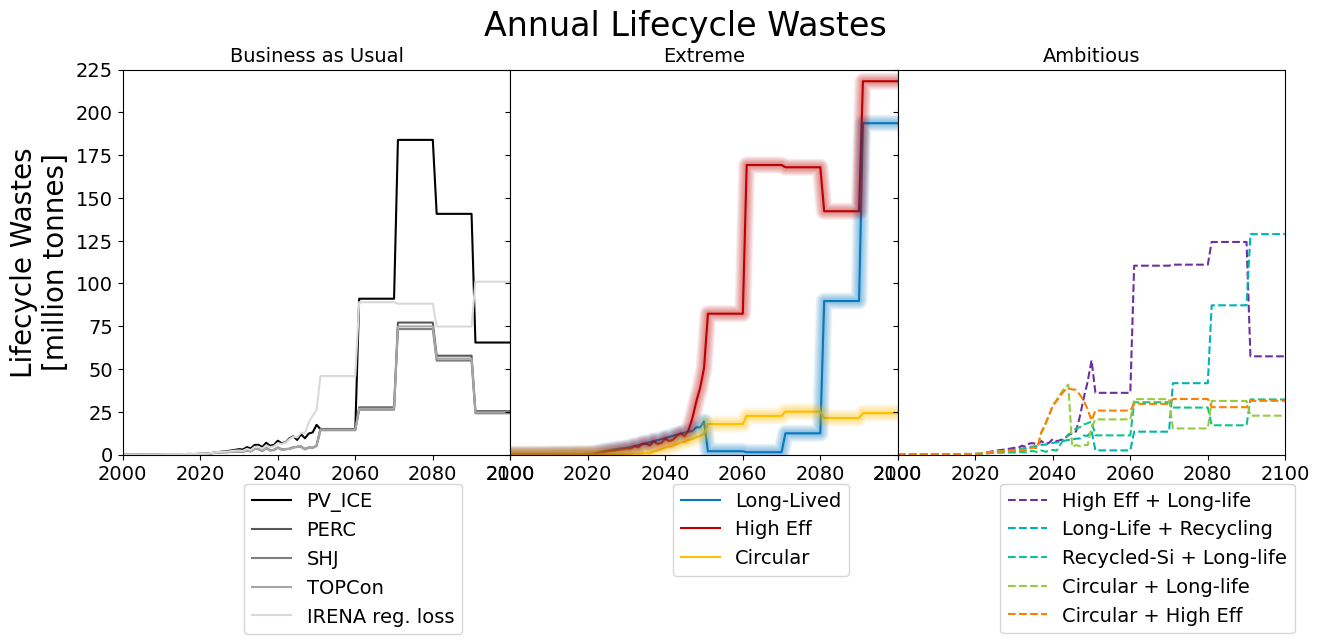

In [275]:
annual_waste_module_decademod_mt = annual_waste_module_decademod/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})

#BAU
ax1.set_prop_cycle(color=colorpalette[0:5])
ax1.plot(annual_waste_module_decademod_mt.iloc[:,0:5], label=scennames_labels_flat[0:5]) # baselines
ax1.set_title('Business as Usual', fontsize=14)
ax1.set_ylabel('Lifecycle Wastes\n[million tonnes]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,225)
ax1.legend(bbox_to_anchor=(0.9,-0.05))


#Extreme
ax2.set_prop_cycle(color=colorpalette[5:8])
ax2.plot(annual_waste_module_decademod_mt.iloc[:,5:8], label=scennames_labels_flat[5:8]) #, 

#create glowlines for Extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax2.plot(annual_waste_module_decademod_mt.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    ax2.plot(annual_waste_module_decademod_mt.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    ax2.plot(annual_waste_module_decademod_mt.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

ax2.set_title('Extreme', fontsize=14)
ax2.legend(bbox_to_anchor=(0.9,-0.05))

#Ambitious
ax3.set_prop_cycle(color=colorpalette[8:])
ax3.plot(annual_waste_module_decademod_mt.iloc[:,8:], label=scennames_labels_flat[8:], ls='--')# 
ax3.set_title('Ambitious', fontsize=14)
ax3.legend(bbox_to_anchor=(1.05,-0.05)) #(x,y)

#overall figure

fig.suptitle('Annual Lifecycle Wastes', fontsize=24, y=1)
plt.show()
fig.savefig('energyresults-annualwaste.png', dpi=300, bbox_inches='tight')

In [276]:
sim1.scenario['r_IRENA'].dataOut_m.loc[45:,]

Area  Cumulative_Active_Area  EOL_BadStatus  EOL_Landfill0  \
45   1.887576e+10            2.426090e+11   6.107428e+08   3.472851e+08   
46   1.959160e+10            2.607759e+11   7.627189e+08   4.844115e+08   
47   2.030250e+10            2.796484e+11   9.759398e+08   4.540086e+08   
48   2.100853e+10            2.981316e+11   1.780402e+09   7.449907e+08   
49   2.170972e+10            3.164642e+11   2.456813e+09   9.202497e+08   
50   2.240613e+10            3.346509e+11   3.164596e+09   1.054865e+09   
51   9.969091e+08            3.306345e+11   3.759961e+09   1.253320e+09   
52   9.969091e+08            3.260922e+11   4.154425e+09   1.384808e+09   
53   9.969091e+08            3.207500e+11   4.754336e+09   1.584779e+09   
54   9.969091e+08            3.146195e+11   5.345584e+09   1.781861e+09   
55   9.969091e+08            3.077114e+11   5.928728e+09   1.976243e+09   
56   9.969091e+08            3.000361e+11   6.504166e+09   2.168055e+09   
57   9.969091e+08            2.915752e+11   7.093356e+09   2.364452e+09   
58   9.969091e+08            2.823370e+11   7.676292e+09   2.558764e+09   
59   9.969091e+08            2.723317e+11   8.251662e+09   2.750554e+09   
60   9.969091e+08            2.615719e+11   8.817596e+09   2.939199e+09   
61   9.969091e+08            2.500734e+11   9.371551e+09   3.123850e+09   
62   9.969091e+08            2.378567e+11   9.910194e+09   3.303398e+09   
63   9.969091e+08            2.249479e+11   1.042929e+10   3.476430e+09   
64   9.969091e+08            2.113800e+11   1.092360e+10   3.641199e+09   
65   9.969091e+08            1.971945e+11   1.138678e+10   3.795594e+09   
66   9.969091e+08            1.824429e+11   1.181138e+10   3.937126e+09   
67   9.969091e+08            1.671881e+11   1.218878e+10   4.062926e+09   
68   9.969091e+08            1.515060e+11   1.250931e+10   4.169770e+09   
69   9.969091e+08            1.354863e+11   1.276241e+10   4.254137e+09   
70   9.969091e+08            1.192340e+11   1.293692e+10   4.312308e+09   
71   9.969091e+08            1.028689e+11   1.302153e+10   4.340511e+09   
72   9.969091e+08            8.652525e+10   1.300538e+10   4.335128e+09   
73   9.969091e+08            7.035033e+10   1.287887e+10   4.292958e+09   
74   9.969091e+08            5.450111e+10   1.263460e+10   4.211532e+09   
75   9.969091e+08            3.914013e+10   1.226842e+10   4.089472e+09   
76   9.969091e+08            2.442959e+10   1.178059e+10   3.926862e+09   
77   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
78   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
79   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
80   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
81   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
82   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
83   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
84   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
85   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
86   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
87   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
88   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
89   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
90   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
91   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
92   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
93   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
94   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
95   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
96   9.969091e+08            2.442959e+10   7.476818e+08   2.492273e+08   
97   9.969091e+08            2.442959e

# RESULTS: Energy

## Energy Generation
Because of different bifi factors, they do NOT produce the same energy

(0.0, 146788.32213802627)

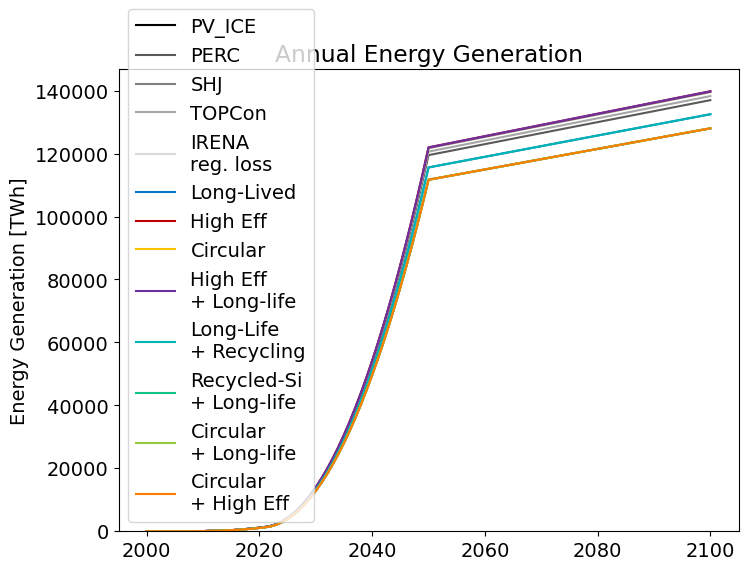

In [277]:
#energyGen = allenergy.filter(like='e_out_annual')
plt.plot(energyGen/1e12)
plt.legend(scennames_labels)
plt.title('Annual Energy Generation')
plt.ylabel('Energy Generation [TWh]')
plt.ylim(0,)

## Annual Energy Demands through 2050
Increasing the steepness of the curve

In [278]:
e_annual_sumDemands = energy_demands.filter(like='demand_total')

(2000.0, 2050.0)

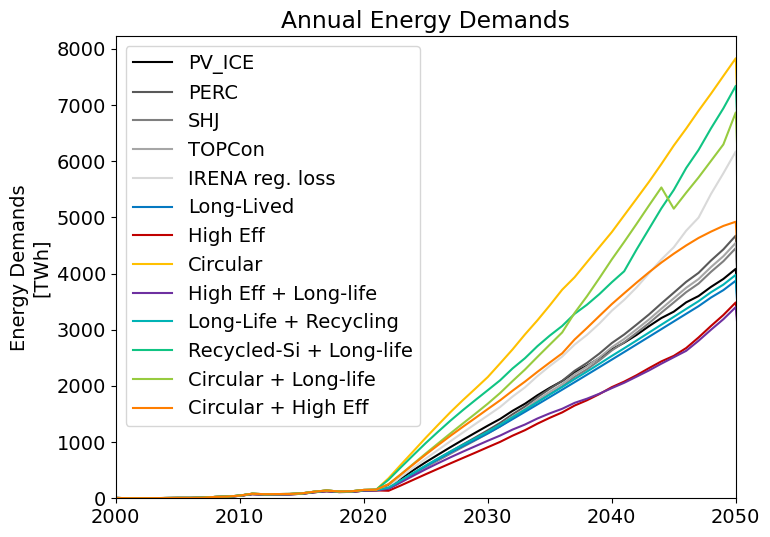

In [316]:
plt.plot(e_annual_sumDemands/1e12)
plt.legend(scennames_labels_flat)
plt.title('Annual Energy Demands')
plt.ylabel('Energy Demands\n[TWh]')
plt.ylim(0,)
plt.xlim(2000,2050)

In [280]:
#ember electricity demand
world_elec_demand = pd.read_csv(os.path.join(altBaselinesfolder, 'ember-world-electricity-demand.csv'), index_col='year')
#Haegel energy demand research
#added 4 2050 datapoints to above DF
elec_2050 = pd.DataFrame({2050:[58000],2050:[103400],2050:[105000],2050:[85300],})
elec_2050

2050
0  85300

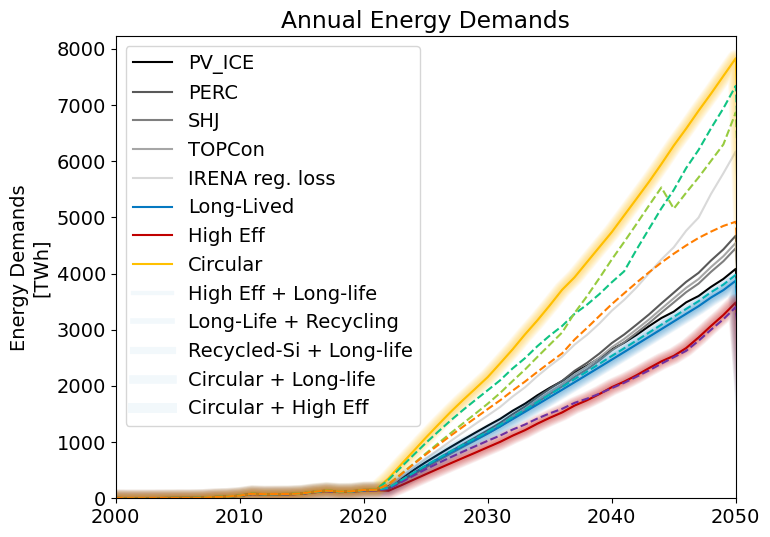

In [335]:
e_annual_sumDemands_TWh = e_annual_sumDemands/1e12

fig, ax1 = plt.subplots()

#world electricity demand
#ax1.plot(world_elec_demand.iloc[0:2022,0], label='Global Electricity Demand', ls='dashdot')

#BAU
ax1.plot(e_annual_sumDemands_TWh.iloc[:,0:5])

#Extreme
ax1.plot(e_annual_sumDemands_TWh.iloc[:,5:8])
#create glowlines for Extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):
    ax1.plot(e_annual_sumDemands_TWh.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    ax1.plot(e_annual_sumDemands_TWh.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    ax1.plot(e_annual_sumDemands_TWh.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

#Ambitious
ax1.plot(e_annual_sumDemands_TWh.iloc[:,8:], ls='--')

ax1.legend(scennames_labels_flat)
plt.title('Annual Energy Demands')
plt.ylabel('Energy Demands\n[TWh]')
plt.ylim(0,)
plt.xlim(2000,2050)

plt.show()

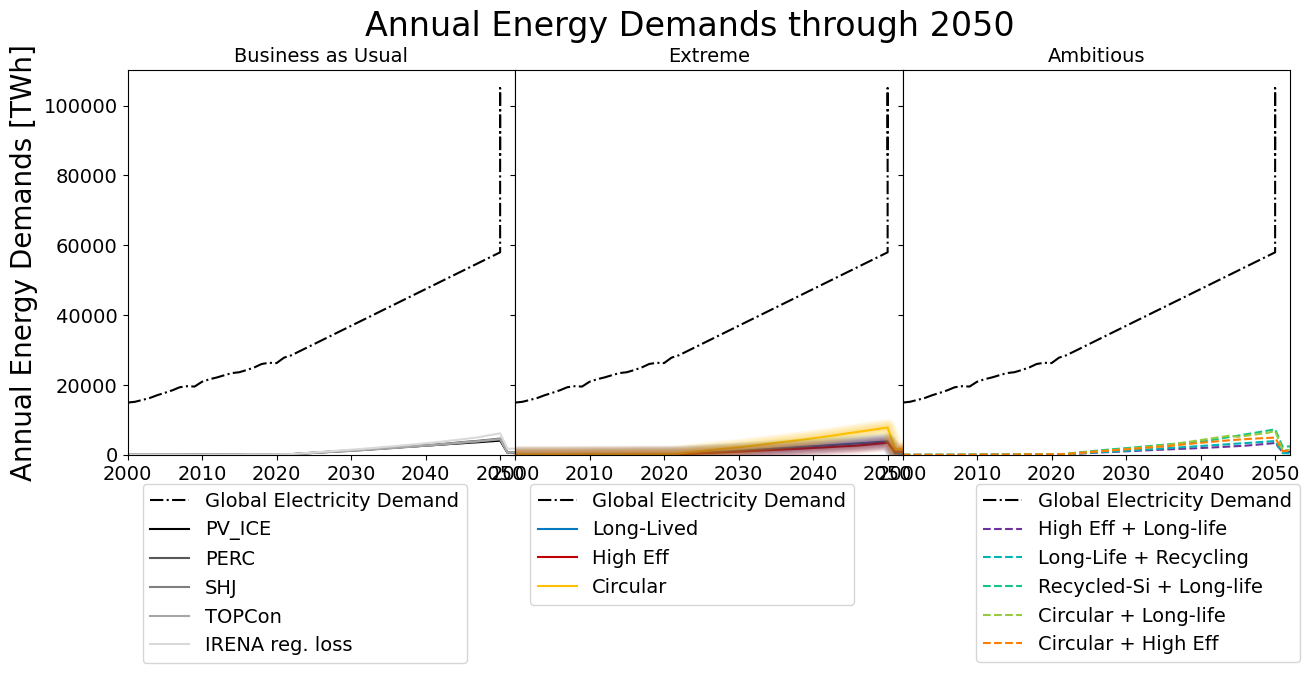

In [281]:
e_annual_demands_TWh = e_annual_sumDemands/1e12

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})
ax1.plot(world_elec_demand.iloc[:2022,0], label='Global Electricity Demand', ls='dashdot')
#ax1.scatter(x=2050, y=elec_2050.T, label='Global Electricity Demand')

#BAU
ax1.set_prop_cycle(color=colorpalette[0:5])
ax1.plot(e_annual_demands_TWh.iloc[:2050,0:5], label=scennames_labels_flat[0:5]) # baselines
ax1.set_title('Business as Usual', fontsize=14)
ax1.set_ylabel('Annual Energy Demands [TWh]', fontsize=20)
ax1.set_xlim(2000,2052)
ax1.set_ylim(0,)
ax1.legend(bbox_to_anchor=(0.9,-0.05))


#Extreme
ax2.plot(world_elec_demand.iloc[:,0], label='Global Electricity Demand', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[5:8])
ax2.plot(e_annual_demands_TWh.iloc[:2050,5:8], label=scennames_labels_flat[5:8]) #, color=colorpalette[4:7])

#create glowlines for Extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax2.plot(e_annual_demands_TWh.iloc[:2050,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    ax2.plot(e_annual_demands_TWh.iloc[:2050,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    ax2.plot(e_annual_demands_TWh.iloc[:2050,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

ax2.set_title('Extreme', fontsize=14)
ax2.legend(bbox_to_anchor=(0.9,-0.05))

#Ambitious
ax3.plot(world_elec_demand.iloc[:,0], label='Global Electricity Demand', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[8:])
ax3.plot(e_annual_demands_TWh.iloc[:2050,8:], label=scennames_labels_flat[8:], ls='--')# 
ax3.set_title('Ambitious', fontsize=14)
ax3.legend(bbox_to_anchor=(1.05,-0.05)) #(x,y)

#overall figure
fig.suptitle('Annual Energy Demands through 2050', fontsize=24, y=1)
plt.show()
fig.savefig('energyresults-annualEnergyDemands2050.png', dpi=300, bbox_inches='tight')

## Net Energy

In [309]:
e_annual_sumDemands_cumu = e_annual_sumDemands.cumsum()

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'PERC'),
  Text(2.0, 0, 'SHJ'),
  Text(3.0, 0, 'TOPCon'),
  Text(4.0, 0, 'IRENA\nreg. loss'),
  Text(5.0, 0, 'Long-Lived'),
  Text(6.0, 0, 'High Eff'),
  Text(7.0, 0, 'Circular'),
  Text(8.0, 0, 'High Eff\n+ Long-life'),
  Text(9.0, 0, 'Long-Life\n+ Recycling'),
  Text(10.0, 0, 'Recycled-Si\n+ Long-life'),
  Text(11.0, 0, 'Circular\n+ Long-life'),
  Text(12.0, 0, 'Circular\n+ High Eff')])

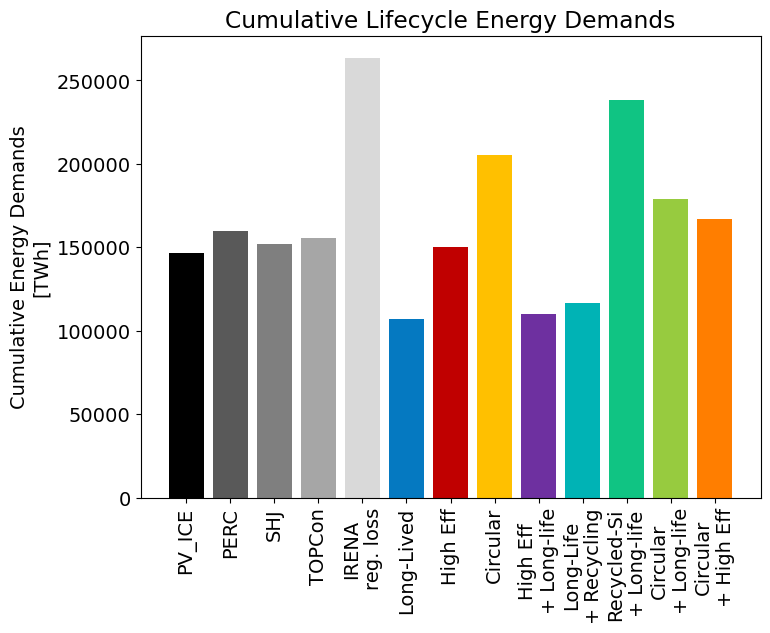

In [283]:
plt.bar(e_annual_sumDemands_cumu.columns, e_annual_sumDemands_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Cumulative Lifecycle Energy Demands')
plt.ylabel('Cumulative Energy Demands\n[TWh]')
plt.xticks(rotation=90)

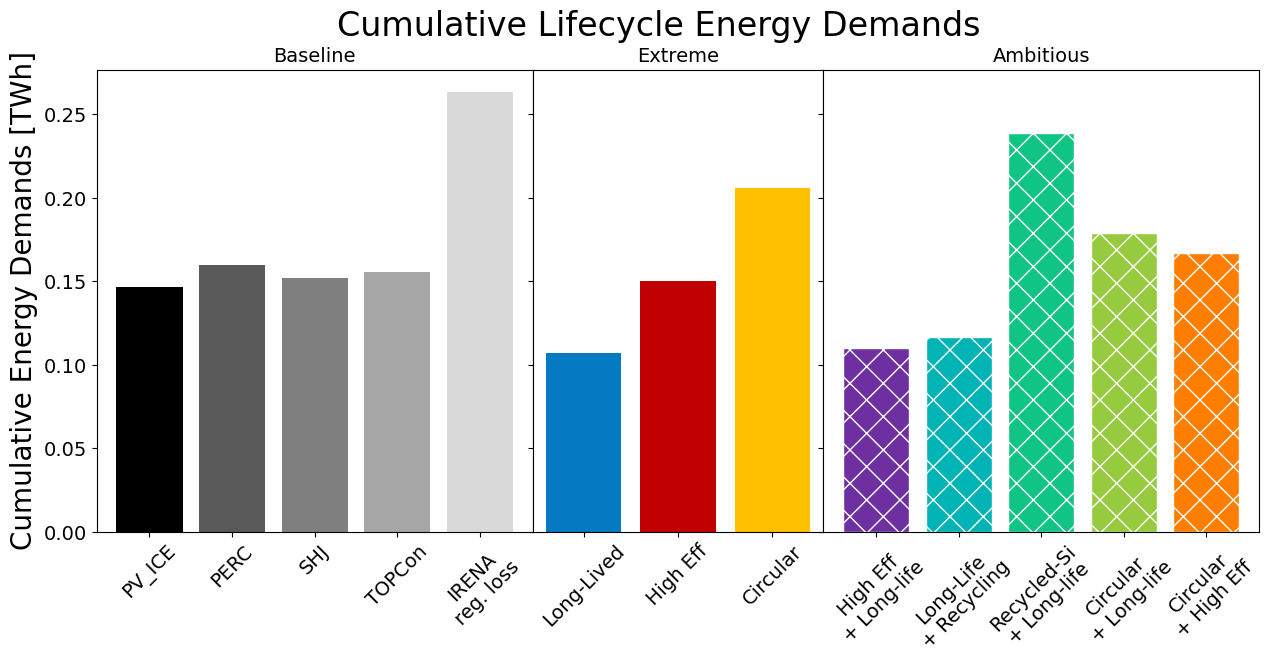

In [284]:
cumu_e_demands_twh = e_annual_sumDemands_cumu.loc[2100]/1e12
cumu_e_demands_twh.index = scennames_labels_flat

fig, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], cumu_e_demands_twh.iloc[0:5]/1e6,# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
ax0.set_ylim(0,)
ax0.set_ylabel('Cumulative Energy Demands [TWh]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)

#Extreme
ax2.bar(scennames_labels[5:8], cumu_e_demands_twh.iloc[5:8]/1e6, #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)

#Ambitious
ax3.bar(scennames_labels[8:], cumu_e_demands_twh.iloc[8:]/1e6, #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)

#overall fig

fig.suptitle('Cumulative Lifecycle Energy Demands', fontsize=24)
plt.show()

fig.savefig('energyresults-energyDemands.png', dpi=300, bbox_inches='tight')

In [285]:
#select material demands that are not fuel
e_fuels = energy_demands.filter(like='_fuel')
e_energydemands = energy_demands.loc[:,~energy_demands.columns.isin(e_fuels.columns)]
#sum energy demands by material
e_mfging_bymat = pd.DataFrame()
for scen in sim1.scenario.keys():
    e_energy_mfg_scen = e_energydemands.filter(like=scen).filter(like='_MFG_')
    e_energy_mod_mfg_scen = energy_demands.filter(like=scen).filter(like='mod_MFG')
    e_mfging_bymat = pd.concat([e_mfging_bymat,e_energy_mfg_scen,e_energy_mod_mfg_scen], axis=1)

In [286]:
cum_e_mfging_bymat = e_mfging_bymat.cumsum().loc[2100]
cum_e_mfging_bymat

PV_ICE_glass_mat_MFG_virgin                         2.830129e+16
PV_ICE_silicon_mat_MFG_virgin                       6.254999e+16
PV_ICE_silver_mat_MFG_virgin                        4.701355e+14
PV_ICE_aluminium_frames_mat_MFG_virgin              1.991850e+16
PV_ICE_copper_mat_MFG_virgin                        9.871803e+13
                                                        ...     
h_Perovskite_Eff_aluminium_frames_mat_MFG_virgin    1.008780e+16
h_Perovskite_Eff_copper_mat_MFG_virgin              1.950974e+14
h_Perovskite_Eff_encapsulant_mat_MFG_virgin         4.328103e+15
h_Perovskite_Eff_backsheet_mat_MFG_virgin           2.728711e+13
h_Perovskite_Eff_mod_MFG                            5.144008e+15
Name: 2100, Length: 104, dtype: float64

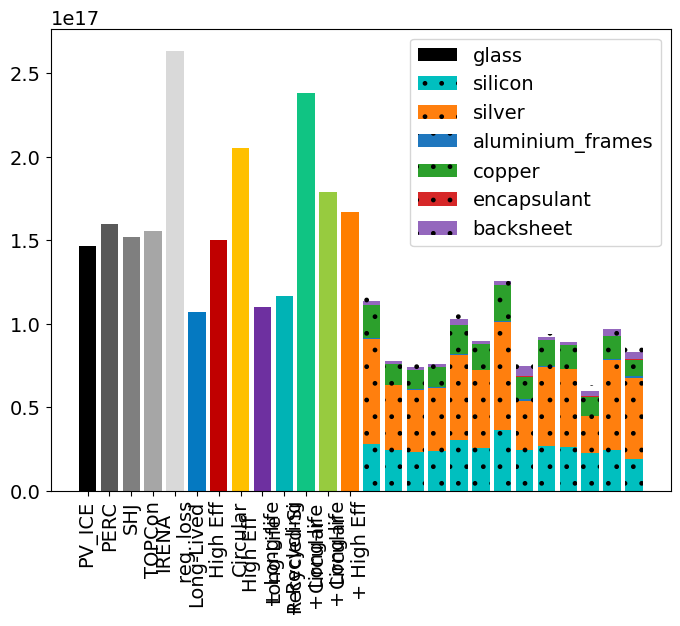

In [287]:
#run 2x rn??
#energy demands by material mfging
plt.bar(e_annual_sumDemands_cumu.columns, e_annual_sumDemands_cumu.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)

#Materials
cume_mfg_glass = cum_e_mfging_bymat.filter(like='glass')
cume_mfg_silicon = cum_e_mfging_bymat.filter(like='silicon')
cume_mfg_silver = cum_e_mfging_bymat.filter(like='silver')
cume_mfg_aluminium_frames = cum_e_mfging_bymat.filter(like='aluminium_frames')
cume_mfg_copper = cum_e_mfging_bymat.filter(like='copper')
cume_mfg_encapsulant = cum_e_mfging_bymat.filter(like='encapsulant')
cume_mfg_backsheet = cum_e_mfging_bymat.filter(like='backsheet')
cume_mfg_mod = cum_e_mfging_bymat.filter(like='mod')

bot_ag = cume_mfg_glass.values+cume_mfg_silicon.values
bot_al = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values
bot_cu = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values
bot_encap = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values
bot_back = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values+cume_mfg_encapsulant.values
bot_mod = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values+cume_mfg_encapsulant.values+cume_mfg_backsheet.values

plt.bar(scennames_labels, cume_mfg_glass, color = colormats[0], hatch='.')
plt.bar(scennames_labels, cume_mfg_silicon, bottom = cume_mfg_glass, color=colormats[1], hatch='.')
plt.bar(scennames_labels, cume_mfg_silver, bottom = bot_ag, color=colormats[2], hatch='.')
plt.bar(scennames_labels, cume_mfg_aluminium_frames, bottom = bot_al, color=colormats[3], hatch='.')
plt.bar(scennames_labels, cume_mfg_copper, bottom = bot_cu , color=colormats[4], hatch='.')
plt.bar(scennames_labels, cume_mfg_encapsulant, bottom = bot_encap ,color=colormats[5], hatch='.')
plt.bar(scennames_labels, cume_mfg_backsheet, bottom = bot_back, color=colormats[6], hatch='.')
plt.bar(scennames_labels, cume_mfg_mod, bottom = bot_back, color='white', hatch='.')

plt.xticks(rotation=90)

plt.legend(MATERIALS)

In [288]:
energyGen_cumu = energyGen.cumsum()
energyGen_cumu.columns = e_annual_sumDemands_cumu.columns = scennames_labels_flat
netEnergy_cumu = energyGen_cumu.loc[[2100]] - e_annual_sumDemands_cumu.loc[[2100]]

In [289]:
e_annual_sumDemands_cumu.loc[[2100]]

PV_ICE          PERC           SHJ        TOPCon  IRENA reg. loss  \
year                                                                            
2100  1.467254e+17  1.597664e+17  1.521457e+17  1.553629e+17     2.635917e+17   

        Long-Lived      High Eff      Circular  High Eff + Long-life  \
year                                                                   
2100  1.069366e+17  1.499490e+17  2.056136e+17          1.098641e+17   

      Long-Life + Recycling  Recycled-Si + Long-life  Circular + Long-life  \
year                                                                         
2100           1.164796e+17             2.385947e+17          1.791845e+17   

      Circular + High Eff  
year                       
2100         1.668764e+17

In [290]:
netEnergy_cumu

PV_ICE          PERC           SHJ        TOPCon  IRENA reg. loss  \
year                                                                            
2100  7.041304e+18  7.531425e+18  7.682807e+18  7.607709e+18     6.924438e+18   

        Long-Lived      High Eff      Circular  High Eff + Long-life  \
year                                                                   
2100  7.332674e+18  7.699379e+18  6.982416e+18          7.739464e+18   

      Long-Life + Recycling  Recycled-Si + Long-life  Circular + Long-life  \
year                                                                         
2100           7.323131e+18             6.949435e+18          7.008845e+18   

      Circular + High Eff  
year                       
2100         7.021153e+18

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'PERC'),
  Text(2.0, 0, 'SHJ'),
  Text(3.0, 0, 'TOPCon'),
  Text(4.0, 0, 'IRENA\nreg. loss'),
  Text(5.0, 0, 'Long-Lived'),
  Text(6.0, 0, 'High Eff'),
  Text(7.0, 0, 'Circular'),
  Text(8.0, 0, 'High Eff\n+ Long-life'),
  Text(9.0, 0, 'Long-Life\n+ Recycling'),
  Text(10.0, 0, 'Recycled-Si\n+ Long-life'),
  Text(11.0, 0, 'Circular\n+ Long-life'),
  Text(12.0, 0, 'Circular\n+ High Eff')])

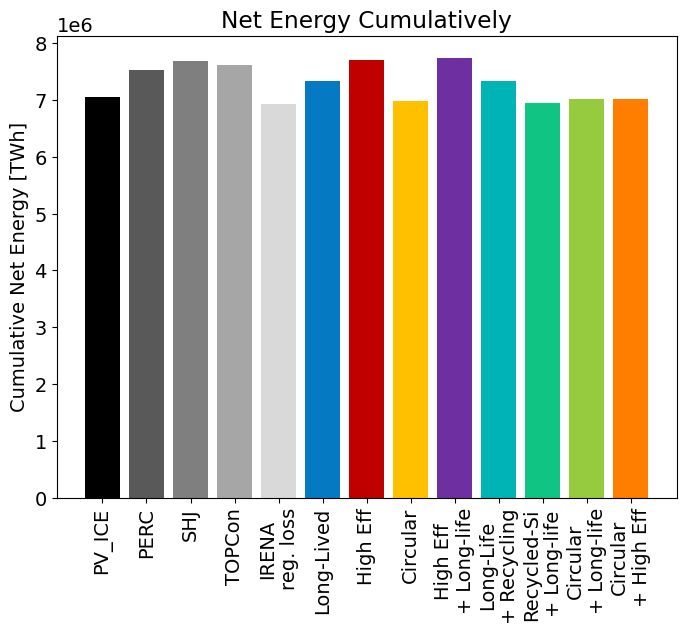

In [291]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively')
plt.ylabel('Cumulative Net Energy [TWh]')
#plt.ylim(4e6,5.5e6)
plt.xticks(rotation=90)

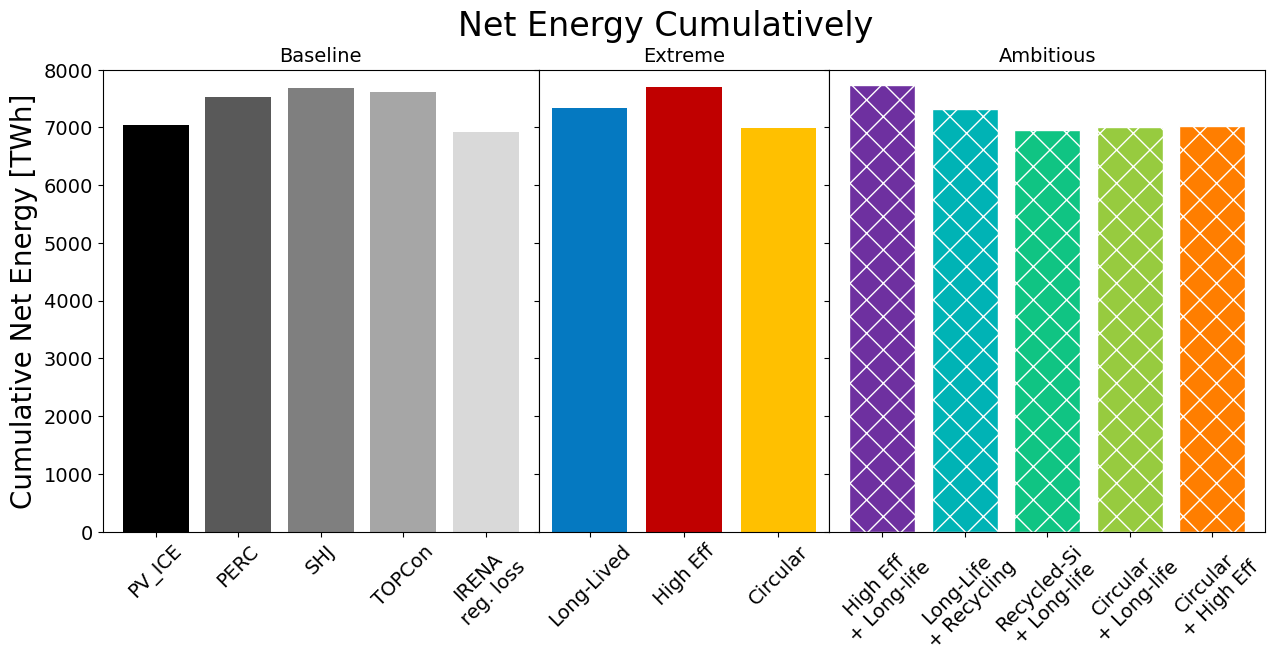

In [292]:
cumu_netEnergy_twh = netEnergy_cumu.loc[2100]/1e15

fig, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], cumu_netEnergy_twh.iloc[0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
ax0.set_ylim(0,8000)
ax0.set_ylabel('Cumulative Net Energy [TWh]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)

#Extreme
ax2.bar(scennames_labels[5:8], cumu_netEnergy_twh.iloc[5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)

#Ambitious
ax3.bar(scennames_labels[8:], cumu_netEnergy_twh.iloc[8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)

#overall fig

fig.suptitle('Net Energy Cumulatively', fontsize=24)
plt.show()

fig.savefig('energyresults-cumuNetEnergy.png', dpi=300, bbox_inches='tight')

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'PERC'),
  Text(2.0, 0, 'SHJ'),
  Text(3.0, 0, 'TOPCon'),
  Text(4.0, 0, 'IRENA\nreg. loss'),
  Text(5.0, 0, 'Long-Lived'),
  Text(6.0, 0, 'High Eff'),
  Text(7.0, 0, 'Circular'),
  Text(8.0, 0, 'High Eff\n+ Long-life'),
  Text(9.0, 0, 'Long-Life\n+ Recycling'),
  Text(10.0, 0, 'Recycled-Si\n+ Long-life'),
  Text(11.0, 0, 'Circular\n+ Long-life'),
  Text(12.0, 0, 'Circular\n+ High Eff')])

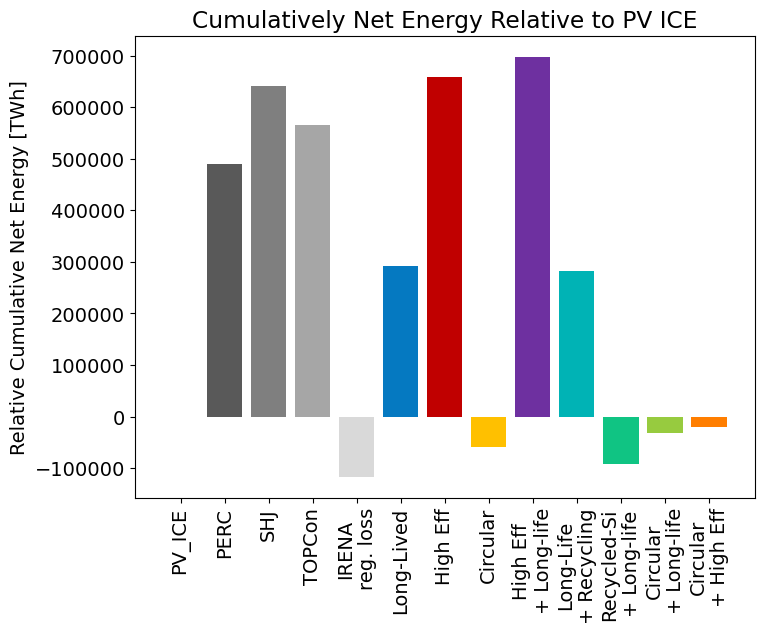

In [293]:
netEnergy_relative = netEnergy_cumu - netEnergy_cumu.loc[2100,'PV_ICE']
netEnergy_relative
plt.bar(netEnergy_relative.columns, netEnergy_relative.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Cumulatively Net Energy Relative to PV ICE')
plt.ylabel('Relative Cumulative Net Energy [TWh]')
plt.xticks(rotation=90)

In [294]:
netEnergy_cumu_norm = netEnergy_cumu/netEnergy_cumu.loc[2100,'PV_ICE']
netEnergy_cumu_norm_waterfall = netEnergy_cumu_norm-1
netEnergy_cumu_norm


PV_ICE      PERC       SHJ   TOPCon  IRENA reg. loss  Long-Lived  \
year                                                                     
2100     1.0  1.069607  1.091106  1.08044         0.983403     1.04138   

      High Eff  Circular  High Eff + Long-life  Long-Life + Recycling  \
year                                                                    
2100  1.093459  0.991637              1.099152               1.040025   

      Recycled-Si + Long-life  Circular + Long-life  Circular + High Eff  
year                                                                      
2100                 0.986953               0.99539             0.997138

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'PERC'),
  Text(2.0, 0, 'SHJ'),
  Text(3.0, 0, 'TOPCon'),
  Text(4.0, 0, 'IRENA\nreg. loss'),
  Text(5.0, 0, 'Long-Lived'),
  Text(6.0, 0, 'High Eff'),
  Text(7.0, 0, 'Circular'),
  Text(8.0, 0, 'High Eff\n+ Long-life'),
  Text(9.0, 0, 'Long-Life\n+ Recycling'),
  Text(10.0, 0, 'Recycled-Si\n+ Long-life'),
  Text(11.0, 0, 'Circular\n+ Long-life'),
  Text(12.0, 0, 'Circular\n+ High Eff')])

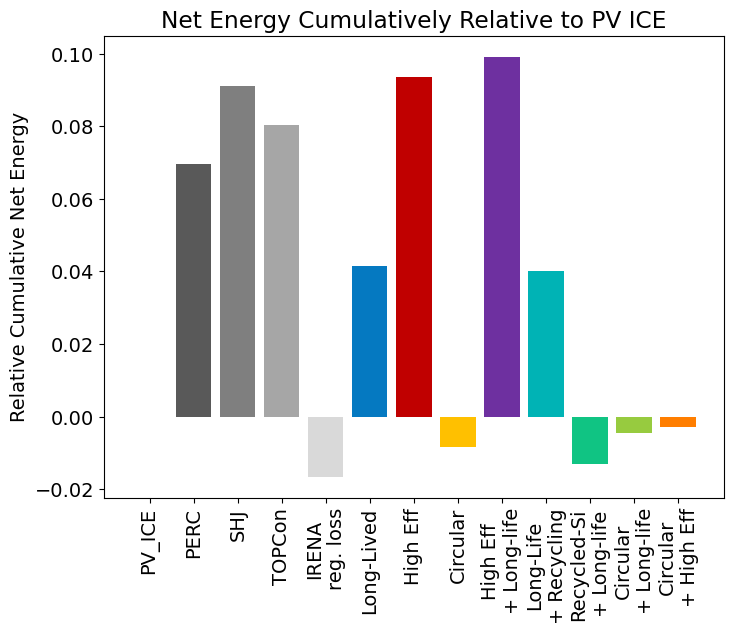

In [295]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu_norm_waterfall.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively Relative to PV ICE')
plt.ylabel('Relative Cumulative Net Energy')
#plt.ylim(-0.026,0.005)
plt.plot(0.0, lw=2)
plt.xticks(rotation=90)

In [296]:
netEnergy_cumu_norm_waterfall

PV_ICE      PERC       SHJ   TOPCon  IRENA reg. loss  Long-Lived  \
year                                                                     
2100     0.0  0.069607  0.091106  0.08044        -0.016597     0.04138   

      High Eff  Circular  High Eff + Long-life  Long-Life + Recycling  \
year                                                                    
2100  0.093459 -0.008363              0.099152               0.040025   

      Recycled-Si + Long-life  Circular + Long-life  Circular + High Eff  
year                                                                      
2100                -0.013047              -0.00461            -0.002862

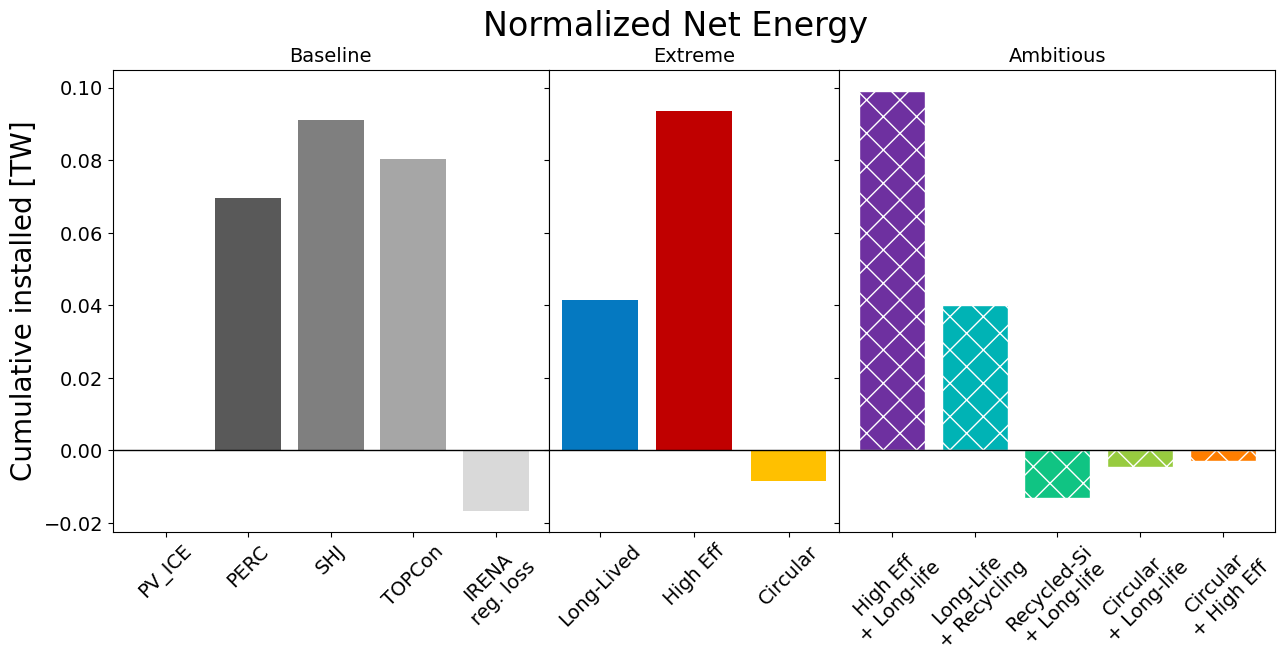

In [297]:

fig, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], netEnergy_cumu_norm_waterfall.iloc[-1,0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
#ax0.set_ylim(0,410)
ax0.set_ylabel('Cumulative installed [TW]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)
ax0.axhline(0, lw=1, color='black')

#Extreme
ax2.bar(scennames_labels[5:8], netEnergy_cumu_norm_waterfall.iloc[-1,5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)
ax2.axhline(0, lw=1, color='black')

#Ambitious
ax3.bar(scennames_labels[8:], netEnergy_cumu_norm_waterfall.iloc[-1,8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)

#overall fig
ax3.axhline(0, lw=1, color='black')

fig.suptitle('Normalized Net Energy', fontsize=24)
plt.show()

fig.savefig('energyresults-cumuNetEnergyNorm.png', dpi=300, bbox_inches='tight')

In [298]:
netenergy_final = netEnergy_cumu.loc[2100]/1e12

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'PERC'),
  Text(2.0, 0, 'SHJ'),
  Text(3.0, 0, 'TOPCon'),
  Text(4.0, 0, 'IRENA\nreg. loss'),
  Text(5.0, 0, 'Long-Lived'),
  Text(6.0, 0, 'High Eff'),
  Text(7.0, 0, 'Circular'),
  Text(8.0, 0, 'High Eff\n+ Long-life'),
  Text(9.0, 0, 'Long-Life\n+ Recycling'),
  Text(10.0, 0, 'Recycled-Si\n+ Long-life'),
  Text(11.0, 0, 'Circular\n+ Long-life'),
  Text(12.0, 0, 'Circular\n+ High Eff')])

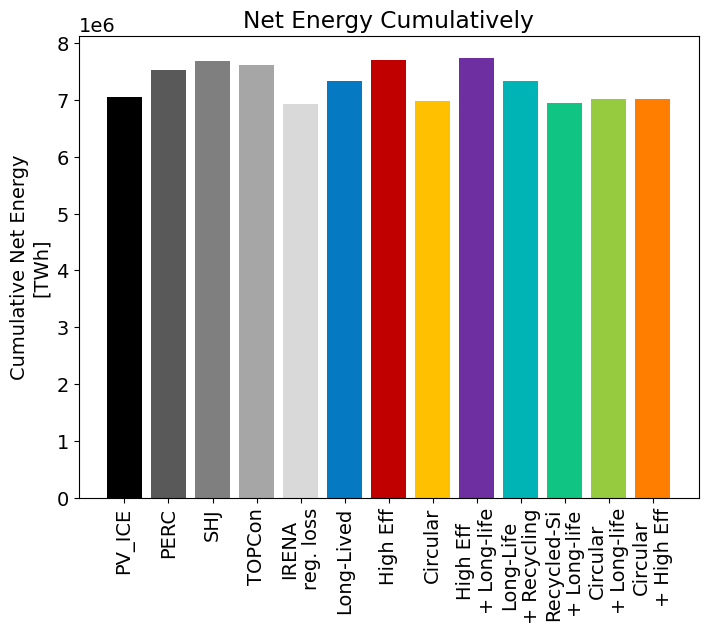

In [299]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively')
plt.ylabel('Cumulative Net Energy\n[TWh]')
plt.xticks(rotation=90)

In [300]:
energyGen.columns = e_annual_sumDemands.columns = scennames_labels_flat
annual_net_energy = energyGen - e_annual_sumDemands

(2000.0, 2100.0)

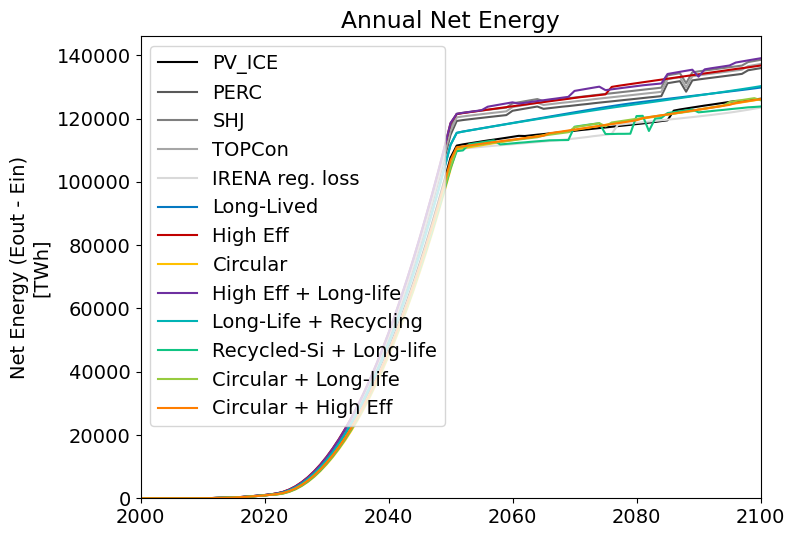

In [301]:
plt.plot(annual_net_energy/1e12)
plt.legend(scennames_labels_flat)
plt.title('Annual Net Energy')
plt.ylabel('Net Energy (Eout - Ein)\n[TWh]')
plt.ylim(0,)
plt.xlim(2000,2100)

## Energy Balance
Inspired by EROI, this is all the energy generation divided by all the energy demanded for all systems deployed in energy transition. This is giving us an idea of our energy bang for energy buck

In [302]:
energyBalance_allyears = energyGen_cumu/e_annual_sumDemands_cumu

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'PERC'),
  Text(2.0, 0, 'SHJ'),
  Text(3.0, 0, 'TOPCon'),
  Text(4.0, 0, 'IRENA\nreg. loss'),
  Text(5.0, 0, 'Long-Lived'),
  Text(6.0, 0, 'High Eff'),
  Text(7.0, 0, 'Circular'),
  Text(8.0, 0, 'High Eff\n+ Long-life'),
  Text(9.0, 0, 'Long-Life\n+ Recycling'),
  Text(10.0, 0, 'Recycled-Si\n+ Long-life'),
  Text(11.0, 0, 'Circular\n+ Long-life'),
  Text(12.0, 0, 'Circular\n+ High Eff')])

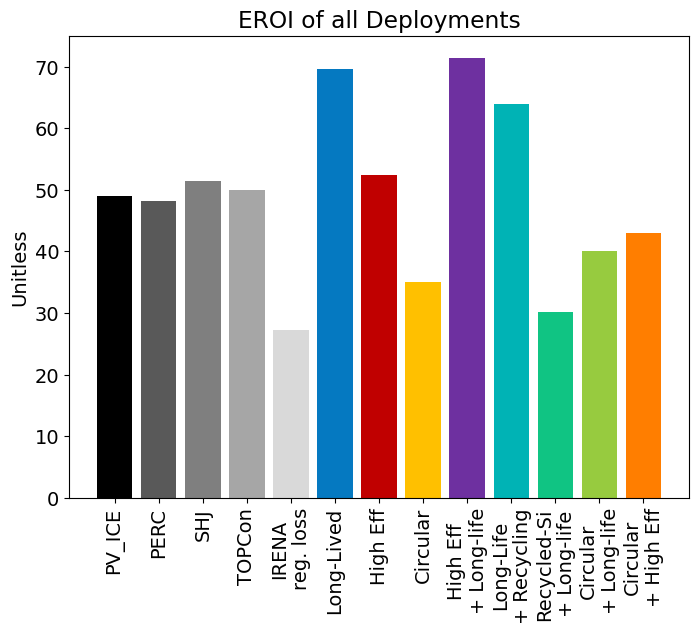

In [303]:
plt.bar(energyBalance_allyears.columns, energyBalance_allyears.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('EROI of all Deployments')
plt.ylabel('Unitless')
plt.xticks(rotation=90)

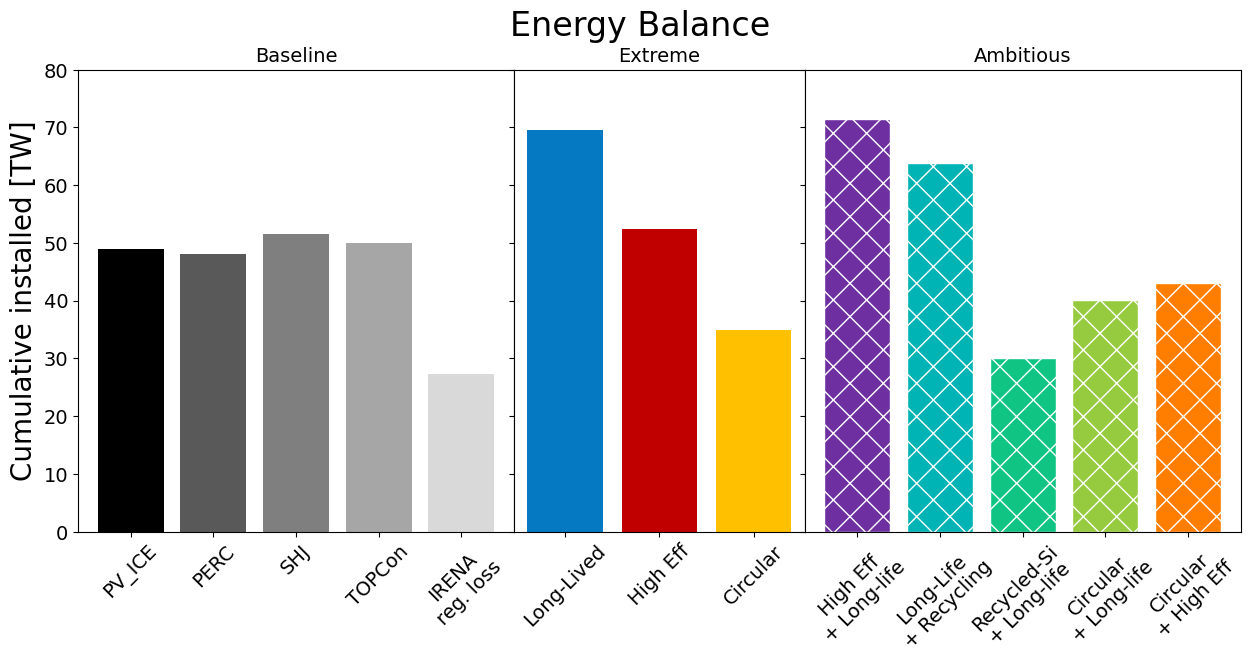

In [304]:
energyBalance = energyBalance_allyears.loc[2100]

fig, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], energyBalance.iloc[0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
ax0.set_ylim(0,80)
ax0.set_ylabel('Cumulative installed [TW]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)

#Extreme
ax2.bar(scennames_labels[5:8], energyBalance.iloc[5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)

#Ambitious
ax3.bar(scennames_labels[8:], energyBalance.iloc[8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)

#overall fig

fig.suptitle('Energy Balance', fontsize=24)
plt.show()

fig.savefig('energyresults-energyBalance.png', dpi=300, bbox_inches='tight')

### Discussion summary table

In [313]:
discussTable = pd.concat([replacements,virgin,wastes, cumu_e_demands_twh,netenergy_final,energyBalance], axis=1,
         keys=['replacements','virgin','wastes','energydemand','netenergy','energybalance']).T
discussTable.to_csv(os.path.join(testfolder,'discussiontable.csv'))
discussTable

PV_ICE          PERC           SHJ        TOPCon  \
replacements   1.906612e+02  1.878458e+02  1.878458e+02  1.878458e+02   
virgin         1.008632e+01  8.231230e+00  7.826974e+00  7.993723e+00   
wastes         5.139612e+00  2.112444e+00  2.009417e+00  2.051980e+00   
energydemand   1.467254e+05  1.597664e+05  1.521457e+05  1.553629e+05   
netenergy      7.041304e+06  7.531425e+06  7.682807e+06  7.607709e+06   
energybalance  4.898967e+01  4.814022e+01  5.149638e+01  4.996734e+01   

               IRENA reg. loss    Long-Lived      High Eff      Circular  \
replacements      2.653095e+02  1.448093e+02  2.625211e+02  4.014282e+02   
virgin            1.101605e+01  8.724813e+00  1.223293e+01  9.292273e+00   
wastes            4.185460e+00  3.224157e+00  8.088473e+00  1.213731e+00   
energydemand      2.635917e+05  1.069366e+05  1.499490e+05  2.056136e+05   
netenergy         6.924438e+06  7.332674e+06  7.699379e+06  6.982416e+06   
energybalance     2.726956e+01  6.957031e+01  5.234665e+01  3.495892e+01   

               High Eff + Long-life  Long-Life + Recycling  \
replacements           1.894412e+02           1.524782e+02   
virgin                 8.954970e+00           8.827335e+00   
wastes                 4.695229e+00           2.899110e+00   
energydemand           1.098641e+05           1.164796e+05   
netenergy              7.739464e+06           7.323131e+06   
energybalance          7.144581e+01           6.387049e+01   

               Recycled-Si + Long-life  Circular + Long-life  \
replacements              2.269939e+02          2.719778e+02   
virgin                    8.210236e+00          8.879959e+00   
wastes                    1.345835e+00          1.531751e+00   
energydemand              2.385947e+05          1.791845e+05   
netenergy                 6.949435e+06          7.008845e+06   
energybalance             3.012652e+01          4.011524e+01   

               Circular + High Eff  
replacements          4.014282e+02  
virgin                7.184763e+00  
wastes                1.919526e+00  
energydemand          1.668764e+05  
netenergy             7.021153e+06  
energybalance         4.307398e+01